In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CNN2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.horizontal_and_vertical_flip_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(495000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 80)          0

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/436 [..............................] - ETA: 1:28:20 - loss: 2.3978

  9/436 [..............................] - ETA: 2s - loss: 2.3977     

 17/436 [>.............................] - ETA: 2s - loss: 2.3976

 25/436 [>.............................] - ETA: 2s - loss: 2.3973

 33/436 [=>............................] - ETA: 2s - loss: 2.3967

 42/436 [=>............................] - ETA: 2s - loss: 2.3953

 51/436 [==>...........................] - ETA: 2s - loss: 2.3926

 60/436 [===>..........................] - ETA: 2s - loss: 2.3887

 69/436 [===>..........................] - ETA: 2s - loss: 2.3845

 78/436 [====>.........................] - ETA: 2s - loss: 2.3803

 87/436 [====>.........................] - ETA: 2s - loss: 2.3761

 95/436 [=====>........................] - ETA: 2s - loss: 2.3725

103/436 [======>.......................] - ETA: 2s - loss: 2.3689

112/436 [======>.......................] - ETA: 2s - loss: 2.3649

121/436 [=======>......................] - ETA: 1s - loss: 2.3610

130/436 [=======>......................] - ETA: 1s - loss: 2.3572

139/436 [========>.....................] - ETA: 1s - loss: 2.3535

148/436 [=========>....................] - ETA: 1s - loss: 2.3499

157/436 [=========>....................] - ETA: 1s - loss: 2.3464

166/436 [==========>...................] - ETA: 1s - loss: 2.3430

175/436 [===========>..................] - ETA: 1s - loss: 2.3397

184/436 [===========>..................] - ETA: 1s - loss: 2.3365

193/436 [============>.................] - ETA: 1s - loss: 2.3333

202/436 [============>.................] - ETA: 1s - loss: 2.3302

211/436 [=============>................] - ETA: 1s - loss: 2.3271

220/436 [==============>...............] - ETA: 1s - loss: 2.3239

228/436 [==============>...............] - ETA: 1s - loss: 2.3211

237/436 [===============>..............] - ETA: 1s - loss: 2.3179

246/436 [===============>..............] - ETA: 1s - loss: 2.3147

255/436 [================>.............] - ETA: 1s - loss: 2.3115

264/436 [=================>............] - ETA: 1s - loss: 2.3083

273/436 [=================>............] - ETA: 0s - loss: 2.3051



281/436 [==================>...........] - ETA: 0s - loss: 2.3023

290/436 [==================>...........] - ETA: 0s - loss: 2.2991

298/436 [===================>..........] - ETA: 0s - loss: 2.2962

307/436 [====================>.........] - ETA: 0s - loss: 2.2931

316/436 [====================>.........] - ETA: 0s - loss: 2.2899

325/436 [=====================>........] - ETA: 0s - loss: 2.2868

334/436 [=====================>........] - ETA: 0s - loss: 2.2837



343/436 [======================>.......] - ETA: 0s - loss: 2.2806

352/436 [=======================>......] - ETA: 0s - loss: 2.2776

361/436 [=======================>......] - ETA: 0s - loss: 2.2746

370/436 [========================>.....] - ETA: 0s - loss: 2.2717

379/436 [=========================>....] - ETA: 0s - loss: 2.2688

388/436 [=========================>....] - ETA: 0s - loss: 2.2659

397/436 [==========================>...] - ETA: 0s - loss: 2.2631

406/436 [==========================>...] - ETA: 0s - loss: 2.2603

415/436 [===========================>..] - ETA: 0s - loss: 2.2575

424/436 [============================>.] - ETA: 0s - loss: 2.2548

432/436 [============================>.] - ETA: 0s - loss: 2.2524

436/436 [==============================] - ETA: 0s - loss: 2.2512

436/436 [==============================] - 15s 7ms/step - loss: 2.2510 - val_loss: 1.9082


Epoch 2/100
  1/436 [..............................] - ETA: 3s - loss: 1.9378

 10/436 [..............................] - ETA: 2s - loss: 1.9511

 19/436 [>.............................] - ETA: 2s - loss: 1.9506

 28/436 [>.............................] - ETA: 2s - loss: 1.9506

 37/436 [=>............................] - ETA: 2s - loss: 1.9499

 46/436 [==>...........................] - ETA: 2s - loss: 1.9488

 55/436 [==>...........................] - ETA: 2s - loss: 1.9473

 64/436 [===>..........................] - ETA: 2s - loss: 1.9461

 73/436 [====>.........................] - ETA: 2s - loss: 1.9450

 82/436 [====>.........................] - ETA: 2s - loss: 1.9440

 91/436 [=====>........................] - ETA: 2s - loss: 1.9430

100/436 [=====>........................] - ETA: 2s - loss: 1.9422

109/436 [======>.......................] - ETA: 1s - loss: 1.9413

118/436 [=======>......................] - ETA: 1s - loss: 1.9404

126/436 [=======>......................] - ETA: 1s - loss: 1.9396

135/436 [========>.....................] - ETA: 1s - loss: 1.9387

144/436 [========>.....................] - ETA: 1s - loss: 1.9378

153/436 [=========>....................] - ETA: 1s - loss: 1.9370

162/436 [==========>...................] - ETA: 1s - loss: 1.9361

170/436 [==========>...................] - ETA: 1s - loss: 1.9354

179/436 [===========>..................] - ETA: 1s - loss: 1.9346

188/436 [===========>..................] - ETA: 1s - loss: 1.9338

197/436 [============>.................] - ETA: 1s - loss: 1.9331

206/436 [=============>................] - ETA: 1s - loss: 1.9324

215/436 [=============>................] - ETA: 1s - loss: 1.9317

224/436 [==============>...............] - ETA: 1s - loss: 1.9311

233/436 [===============>..............] - ETA: 1s - loss: 1.9304

242/436 [===============>..............] - ETA: 1s - loss: 1.9298

251/436 [================>.............] - ETA: 1s - loss: 1.9292

260/436 [================>.............] - ETA: 1s - loss: 1.9286

269/436 [=================>............] - ETA: 1s - loss: 1.9280

278/436 [==================>...........] - ETA: 0s - loss: 1.9274

287/436 [==================>...........] - ETA: 0s - loss: 1.9268

296/436 [===================>..........] - ETA: 0s - loss: 1.9262

305/436 [===================>..........] - ETA: 0s - loss: 1.9256

314/436 [====================>.........] - ETA: 0s - loss: 1.9250

323/436 [=====================>........] - ETA: 0s - loss: 1.9244

332/436 [=====================>........] - ETA: 0s - loss: 1.9239

341/436 [======================>.......] - ETA: 0s - loss: 1.9233

350/436 [=======================>......] - ETA: 0s - loss: 1.9228

359/436 [=======================>......] - ETA: 0s - loss: 1.9223

368/436 [========================>.....] - ETA: 0s - loss: 1.9217

377/436 [========================>.....] - ETA: 0s - loss: 1.9212

386/436 [=========================>....] - ETA: 0s - loss: 1.9207

395/436 [==========================>...] - ETA: 0s - loss: 1.9202

404/436 [==========================>...] - ETA: 0s - loss: 1.9197

413/436 [===========================>..] - ETA: 0s - loss: 1.9192

422/436 [============================>.] - ETA: 0s - loss: 1.9187

431/436 [============================>.] - ETA: 0s - loss: 1.9182

436/436 [==============================] - 3s 6ms/step - loss: 1.9179 - val_loss: 1.7978


Epoch 3/100
  1/436 [..............................] - ETA: 3s - loss: 1.8377

 10/436 [..............................] - ETA: 2s - loss: 1.8507

 18/436 [>.............................] - ETA: 2s - loss: 1.8572

 27/436 [>.............................] - ETA: 2s - loss: 1.8584

 36/436 [=>............................] - ETA: 2s - loss: 1.8586

 45/436 [==>...........................] - ETA: 2s - loss: 1.8585

 54/436 [==>...........................] - ETA: 2s - loss: 1.8582

 63/436 [===>..........................] - ETA: 2s - loss: 1.8579

 72/436 [===>..........................] - ETA: 2s - loss: 1.8575

 81/436 [====>.........................] - ETA: 2s - loss: 1.8572

 90/436 [=====>........................] - ETA: 2s - loss: 1.8569

 99/436 [=====>........................] - ETA: 2s - loss: 1.8566

108/436 [======>.......................] - ETA: 1s - loss: 1.8564

117/436 [=======>......................] - ETA: 1s - loss: 1.8562

126/436 [=======>......................] - ETA: 1s - loss: 1.8560

135/436 [========>.....................] - ETA: 1s - loss: 1.8558

143/436 [========>.....................] - ETA: 1s - loss: 1.8556

152/436 [=========>....................] - ETA: 1s - loss: 1.8554

161/436 [==========>...................] - ETA: 1s - loss: 1.8551

170/436 [==========>...................] - ETA: 1s - loss: 1.8549

179/436 [===========>..................] - ETA: 1s - loss: 1.8546

188/436 [===========>..................] - ETA: 1s - loss: 1.8544

197/436 [============>.................] - ETA: 1s - loss: 1.8542

206/436 [=============>................] - ETA: 1s - loss: 1.8539

215/436 [=============>................] - ETA: 1s - loss: 1.8537

224/436 [==============>...............] - ETA: 1s - loss: 1.8534

233/436 [===============>..............] - ETA: 1s - loss: 1.8532

242/436 [===============>..............] - ETA: 1s - loss: 1.8529

251/436 [================>.............] - ETA: 1s - loss: 1.8527

260/436 [================>.............] - ETA: 1s - loss: 1.8525

269/436 [=================>............] - ETA: 0s - loss: 1.8522

278/436 [==================>...........] - ETA: 0s - loss: 1.8520

287/436 [==================>...........] - ETA: 0s - loss: 1.8518

296/436 [===================>..........] - ETA: 0s - loss: 1.8517

305/436 [===================>..........] - ETA: 0s - loss: 1.8515

314/436 [====================>.........] - ETA: 0s - loss: 1.8513

323/436 [=====================>........] - ETA: 0s - loss: 1.8511

332/436 [=====================>........] - ETA: 0s - loss: 1.8509

341/436 [======================>.......] - ETA: 0s - loss: 1.8507

350/436 [=======================>......] - ETA: 0s - loss: 1.8505



359/436 [=======================>......] - ETA: 0s - loss: 1.8504

367/436 [========================>.....] - ETA: 0s - loss: 1.8502

376/436 [========================>.....] - ETA: 0s - loss: 1.8500

385/436 [=========================>....] - ETA: 0s - loss: 1.8499

394/436 [==========================>...] - ETA: 0s - loss: 1.8497

402/436 [==========================>...] - ETA: 0s - loss: 1.8496

411/436 [===========================>..] - ETA: 0s - loss: 1.8494

419/436 [===========================>..] - ETA: 0s - loss: 1.8492

428/436 [============================>.] - ETA: 0s - loss: 1.8491

436/436 [==============================] - 3s 6ms/step - loss: 1.8489 - val_loss: 1.7699


Epoch 4/100
  1/436 [..............................] - ETA: 4s - loss: 1.8037

  9/436 [..............................] - ETA: 2s - loss: 1.8251

 17/436 [>.............................] - ETA: 2s - loss: 1.8268

 26/436 [>.............................] - ETA: 2s - loss: 1.8276

 35/436 [=>............................] - ETA: 2s - loss: 1.8278

 44/436 [==>...........................] - ETA: 2s - loss: 1.8284

 53/436 [==>...........................] - ETA: 2s - loss: 1.8289

 62/436 [===>..........................] - ETA: 2s - loss: 1.8290

 71/436 [===>..........................] - ETA: 2s - loss: 1.8290

 80/436 [====>.........................] - ETA: 2s - loss: 1.8289

 89/436 [=====>........................] - ETA: 2s - loss: 1.8287

 98/436 [=====>........................] - ETA: 2s - loss: 1.8285

106/436 [======>.......................] - ETA: 1s - loss: 1.8284

115/436 [======>.......................] - ETA: 1s - loss: 1.8283

124/436 [=======>......................] - ETA: 1s - loss: 1.8283

133/436 [========>.....................] - ETA: 1s - loss: 1.8282

142/436 [========>.....................] - ETA: 1s - loss: 1.8282

151/436 [=========>....................] - ETA: 1s - loss: 1.8281

160/436 [==========>...................] - ETA: 1s - loss: 1.8280

169/436 [==========>...................] - ETA: 1s - loss: 1.8280

178/436 [===========>..................] - ETA: 1s - loss: 1.8279

187/436 [===========>..................] - ETA: 1s - loss: 1.8279

196/436 [============>.................] - ETA: 1s - loss: 1.8278

204/436 [=============>................] - ETA: 1s - loss: 1.8278

213/436 [=============>................] - ETA: 1s - loss: 1.8277



222/436 [==============>...............] - ETA: 1s - loss: 1.8276

231/436 [==============>...............] - ETA: 1s - loss: 1.8276

240/436 [===============>..............] - ETA: 1s - loss: 1.8275

249/436 [================>.............] - ETA: 1s - loss: 1.8274

258/436 [================>.............] - ETA: 1s - loss: 1.8273

267/436 [=================>............] - ETA: 1s - loss: 1.8272

276/436 [=================>............] - ETA: 0s - loss: 1.8272

285/436 [==================>...........] - ETA: 0s - loss: 1.8271

294/436 [===================>..........] - ETA: 0s - loss: 1.8271

303/436 [===================>..........] - ETA: 0s - loss: 1.8270

312/436 [====================>.........] - ETA: 0s - loss: 1.8269

321/436 [=====================>........] - ETA: 0s - loss: 1.8268

330/436 [=====================>........] - ETA: 0s - loss: 1.8268

339/436 [======================>.......] - ETA: 0s - loss: 1.8267

348/436 [======================>.......] - ETA: 0s - loss: 1.8266

357/436 [=======================>......] - ETA: 0s - loss: 1.8265

366/436 [========================>.....] - ETA: 0s - loss: 1.8264

375/436 [========================>.....] - ETA: 0s - loss: 1.8263

384/436 [=========================>....] - ETA: 0s - loss: 1.8262

393/436 [==========================>...] - ETA: 0s - loss: 1.8261

402/436 [==========================>...] - ETA: 0s - loss: 1.8260

411/436 [===========================>..] - ETA: 0s - loss: 1.8259

420/436 [===========================>..] - ETA: 0s - loss: 1.8258

429/436 [============================>.] - ETA: 0s - loss: 1.8257

436/436 [==============================] - 3s 6ms/step - loss: 1.8257 - val_loss: 1.7605


Epoch 5/100
  1/436 [..............................] - ETA: 3s - loss: 1.7890

 10/436 [..............................] - ETA: 2s - loss: 1.8063

 19/436 [>.............................] - ETA: 2s - loss: 1.8083

 28/436 [>.............................] - ETA: 2s - loss: 1.8094

 37/436 [=>............................] - ETA: 2s - loss: 1.8111

 46/436 [==>...........................] - ETA: 2s - loss: 1.8122

 55/436 [==>...........................] - ETA: 2s - loss: 1.8126

 64/436 [===>..........................] - ETA: 2s - loss: 1.8129

 73/436 [====>.........................] - ETA: 2s - loss: 1.8132

 82/436 [====>.........................] - ETA: 2s - loss: 1.8133

 91/436 [=====>........................] - ETA: 2s - loss: 1.8133

100/436 [=====>........................] - ETA: 2s - loss: 1.8133

109/436 [======>.......................] - ETA: 1s - loss: 1.8132

117/436 [=======>......................] - ETA: 1s - loss: 1.8131

126/436 [=======>......................] - ETA: 1s - loss: 1.8131

135/436 [========>.....................] - ETA: 1s - loss: 1.8131

144/436 [========>.....................] - ETA: 1s - loss: 1.8131

153/436 [=========>....................] - ETA: 1s - loss: 1.8130

161/436 [==========>...................] - ETA: 1s - loss: 1.8129

169/436 [==========>...................] - ETA: 1s - loss: 1.8129

178/436 [===========>..................] - ETA: 1s - loss: 1.8128

187/436 [===========>..................] - ETA: 1s - loss: 1.8128

196/436 [============>.................] - ETA: 1s - loss: 1.8127

205/436 [=============>................] - ETA: 1s - loss: 1.8126



214/436 [=============>................] - ETA: 1s - loss: 1.8125

223/436 [==============>...............] - ETA: 1s - loss: 1.8125

232/436 [==============>...............] - ETA: 1s - loss: 1.8124

241/436 [===============>..............] - ETA: 1s - loss: 1.8123

250/436 [================>.............] - ETA: 1s - loss: 1.8122

259/436 [================>.............] - ETA: 1s - loss: 1.8122

268/436 [=================>............] - ETA: 1s - loss: 1.8121

277/436 [==================>...........] - ETA: 0s - loss: 1.8121

286/436 [==================>...........] - ETA: 0s - loss: 1.8121

294/436 [===================>..........] - ETA: 0s - loss: 1.8120

303/436 [===================>..........] - ETA: 0s - loss: 1.8120

312/436 [====================>.........] - ETA: 0s - loss: 1.8119

321/436 [=====================>........] - ETA: 0s - loss: 1.8119

330/436 [=====================>........] - ETA: 0s - loss: 1.8118

339/436 [======================>.......] - ETA: 0s - loss: 1.8118

348/436 [======================>.......] - ETA: 0s - loss: 1.8117

357/436 [=======================>......] - ETA: 0s - loss: 1.8117

366/436 [========================>.....] - ETA: 0s - loss: 1.8116

375/436 [========================>.....] - ETA: 0s - loss: 1.8115

383/436 [=========================>....] - ETA: 0s - loss: 1.8115

392/436 [=========================>....] - ETA: 0s - loss: 1.8114

401/436 [==========================>...] - ETA: 0s - loss: 1.8113

410/436 [===========================>..] - ETA: 0s - loss: 1.8112

419/436 [===========================>..] - ETA: 0s - loss: 1.8112

428/436 [============================>.] - ETA: 0s - loss: 1.8111

436/436 [==============================] - 3s 6ms/step - loss: 1.8110 - val_loss: 1.7465


Epoch 6/100
  1/436 [..............................] - ETA: 3s - loss: 1.7779

  9/436 [..............................] - ETA: 2s - loss: 1.8031

 18/436 [>.............................] - ETA: 2s - loss: 1.8066

 27/436 [>.............................] - ETA: 2s - loss: 1.8073

 36/436 [=>............................] - ETA: 2s - loss: 1.8073

 45/436 [==>...........................] - ETA: 2s - loss: 1.8070



 54/436 [==>...........................] - ETA: 2s - loss: 1.8068

 63/436 [===>..........................] - ETA: 2s - loss: 1.8063

 72/436 [===>..........................] - ETA: 2s - loss: 1.8058

 81/436 [====>.........................] - ETA: 2s - loss: 1.8054

 89/436 [=====>........................] - ETA: 2s - loss: 1.8052

 98/436 [=====>........................] - ETA: 2s - loss: 1.8049

107/436 [======>.......................] - ETA: 1s - loss: 1.8046

116/436 [======>.......................] - ETA: 1s - loss: 1.8044

124/436 [=======>......................] - ETA: 1s - loss: 1.8042

133/436 [========>.....................] - ETA: 1s - loss: 1.8040

142/436 [========>.....................] - ETA: 1s - loss: 1.8038

151/436 [=========>....................] - ETA: 1s - loss: 1.8037

160/436 [==========>...................] - ETA: 1s - loss: 1.8035

169/436 [==========>...................] - ETA: 1s - loss: 1.8034

178/436 [===========>..................] - ETA: 1s - loss: 1.8033

187/436 [===========>..................] - ETA: 1s - loss: 1.8032

196/436 [============>.................] - ETA: 1s - loss: 1.8031

204/436 [=============>................] - ETA: 1s - loss: 1.8030

213/436 [=============>................] - ETA: 1s - loss: 1.8030

222/436 [==============>...............] - ETA: 1s - loss: 1.8029

231/436 [==============>...............] - ETA: 1s - loss: 1.8028

240/436 [===============>..............] - ETA: 1s - loss: 1.8027

249/436 [================>.............] - ETA: 1s - loss: 1.8026

258/436 [================>.............] - ETA: 1s - loss: 1.8025

267/436 [=================>............] - ETA: 1s - loss: 1.8024

276/436 [=================>............] - ETA: 0s - loss: 1.8023

285/436 [==================>...........] - ETA: 0s - loss: 1.8022

294/436 [===================>..........] - ETA: 0s - loss: 1.8021

303/436 [===================>..........] - ETA: 0s - loss: 1.8020

312/436 [====================>.........] - ETA: 0s - loss: 1.8019

321/436 [=====================>........] - ETA: 0s - loss: 1.8018

330/436 [=====================>........] - ETA: 0s - loss: 1.8018

339/436 [======================>.......] - ETA: 0s - loss: 1.8017

348/436 [======================>.......] - ETA: 0s - loss: 1.8016

357/436 [=======================>......] - ETA: 0s - loss: 1.8016

366/436 [========================>.....] - ETA: 0s - loss: 1.8015

374/436 [========================>.....] - ETA: 0s - loss: 1.8014

383/436 [=========================>....] - ETA: 0s - loss: 1.8014

392/436 [=========================>....] - ETA: 0s - loss: 1.8013

401/436 [==========================>...] - ETA: 0s - loss: 1.8013

410/436 [===========================>..] - ETA: 0s - loss: 1.8012

419/436 [===========================>..] - ETA: 0s - loss: 1.8011

428/436 [============================>.] - ETA: 0s - loss: 1.8011

436/436 [==============================] - 3s 6ms/step - loss: 1.8010 - val_loss: 1.7404


Epoch 7/100
  1/436 [..............................] - ETA: 3s - loss: 1.8188

 10/436 [..............................] - ETA: 2s - loss: 1.8022

 19/436 [>.............................] - ETA: 2s - loss: 1.7964

 28/436 [>.............................] - ETA: 2s - loss: 1.7938

 37/436 [=>............................] - ETA: 2s - loss: 1.7931

 46/436 [==>...........................] - ETA: 2s - loss: 1.7930

 55/436 [==>...........................] - ETA: 2s - loss: 1.7931

 64/436 [===>..........................] - ETA: 2s - loss: 1.7933

 73/436 [====>.........................] - ETA: 2s - loss: 1.7934

 82/436 [====>.........................] - ETA: 2s - loss: 1.7932

 91/436 [=====>........................] - ETA: 2s - loss: 1.7931

100/436 [=====>........................] - ETA: 2s - loss: 1.7931

109/436 [======>.......................] - ETA: 1s - loss: 1.7930

118/436 [=======>......................] - ETA: 1s - loss: 1.7930

127/436 [=======>......................] - ETA: 1s - loss: 1.7930

136/436 [========>.....................] - ETA: 1s - loss: 1.7929

145/436 [========>.....................] - ETA: 1s - loss: 1.7929

154/436 [=========>....................] - ETA: 1s - loss: 1.7929

163/436 [==========>...................] - ETA: 1s - loss: 1.7928

172/436 [==========>...................] - ETA: 1s - loss: 1.7928

181/436 [===========>..................] - ETA: 1s - loss: 1.7927

189/436 [============>.................] - ETA: 1s - loss: 1.7927

198/436 [============>.................] - ETA: 1s - loss: 1.7926

207/436 [=============>................] - ETA: 1s - loss: 1.7925

216/436 [=============>................] - ETA: 1s - loss: 1.7925

225/436 [==============>...............] - ETA: 1s - loss: 1.7925

234/436 [===============>..............] - ETA: 1s - loss: 1.7925

243/436 [===============>..............] - ETA: 1s - loss: 1.7925

252/436 [================>.............] - ETA: 1s - loss: 1.7925

261/436 [================>.............] - ETA: 1s - loss: 1.7925

270/436 [=================>............] - ETA: 1s - loss: 1.7925

279/436 [==================>...........] - ETA: 0s - loss: 1.7925

288/436 [==================>...........] - ETA: 0s - loss: 1.7925

297/436 [===================>..........] - ETA: 0s - loss: 1.7924

305/436 [===================>..........] - ETA: 0s - loss: 1.7924

314/436 [====================>.........] - ETA: 0s - loss: 1.7924

323/436 [=====================>........] - ETA: 0s - loss: 1.7923

332/436 [=====================>........] - ETA: 0s - loss: 1.7923

340/436 [======================>.......] - ETA: 0s - loss: 1.7923

349/436 [=======================>......] - ETA: 0s - loss: 1.7922

357/436 [=======================>......] - ETA: 0s - loss: 1.7922

366/436 [========================>.....] - ETA: 0s - loss: 1.7922

375/436 [========================>.....] - ETA: 0s - loss: 1.7921

384/436 [=========================>....] - ETA: 0s - loss: 1.7921

393/436 [==========================>...] - ETA: 0s - loss: 1.7921

402/436 [==========================>...] - ETA: 0s - loss: 1.7920

411/436 [===========================>..] - ETA: 0s - loss: 1.7920

420/436 [===========================>..] - ETA: 0s - loss: 1.7920

429/436 [============================>.] - ETA: 0s - loss: 1.7919

436/436 [==============================] - 3s 6ms/step - loss: 1.7919 - val_loss: 1.7384


Epoch 8/100
  1/436 [..............................] - ETA: 3s - loss: 1.7671

  9/436 [..............................] - ETA: 2s - loss: 1.7771

 17/436 [>.............................] - ETA: 2s - loss: 1.7787

 26/436 [>.............................] - ETA: 2s - loss: 1.7799

 35/436 [=>............................] - ETA: 2s - loss: 1.7801

 44/436 [==>...........................] - ETA: 2s - loss: 1.7800

 53/436 [==>...........................] - ETA: 2s - loss: 1.7805

 62/436 [===>..........................] - ETA: 2s - loss: 1.7810

 71/436 [===>..........................] - ETA: 2s - loss: 1.7813

 80/436 [====>.........................] - ETA: 2s - loss: 1.7816

 89/436 [=====>........................] - ETA: 2s - loss: 1.7820

 98/436 [=====>........................] - ETA: 2s - loss: 1.7823

107/436 [======>.......................] - ETA: 1s - loss: 1.7825

116/436 [======>.......................] - ETA: 1s - loss: 1.7828

125/436 [=======>......................] - ETA: 1s - loss: 1.7831

134/436 [========>.....................] - ETA: 1s - loss: 1.7834

143/436 [========>.....................] - ETA: 1s - loss: 1.7837

152/436 [=========>....................] - ETA: 1s - loss: 1.7839

161/436 [==========>...................] - ETA: 1s - loss: 1.7840

170/436 [==========>...................] - ETA: 1s - loss: 1.7842

179/436 [===========>..................] - ETA: 1s - loss: 1.7843

188/436 [===========>..................] - ETA: 1s - loss: 1.7844

197/436 [============>.................] - ETA: 1s - loss: 1.7845

205/436 [=============>................] - ETA: 1s - loss: 1.7845

214/436 [=============>................] - ETA: 1s - loss: 1.7845

223/436 [==============>...............] - ETA: 1s - loss: 1.7846

232/436 [==============>...............] - ETA: 1s - loss: 1.7846

241/436 [===============>..............] - ETA: 1s - loss: 1.7847

250/436 [================>.............] - ETA: 1s - loss: 1.7847

259/436 [================>.............] - ETA: 1s - loss: 1.7847

268/436 [=================>............] - ETA: 1s - loss: 1.7847

277/436 [==================>...........] - ETA: 0s - loss: 1.7848

286/436 [==================>...........] - ETA: 0s - loss: 1.7848

295/436 [===================>..........] - ETA: 0s - loss: 1.7848

304/436 [===================>..........] - ETA: 0s - loss: 1.7848

313/436 [====================>.........] - ETA: 0s - loss: 1.7849

322/436 [=====================>........] - ETA: 0s - loss: 1.7849

331/436 [=====================>........] - ETA: 0s - loss: 1.7849

340/436 [======================>.......] - ETA: 0s - loss: 1.7849

349/436 [=======================>......] - ETA: 0s - loss: 1.7849

358/436 [=======================>......] - ETA: 0s - loss: 1.7849

367/436 [========================>.....] - ETA: 0s - loss: 1.7849

376/436 [========================>.....] - ETA: 0s - loss: 1.7849

385/436 [=========================>....] - ETA: 0s - loss: 1.7849

394/436 [==========================>...] - ETA: 0s - loss: 1.7849

403/436 [==========================>...] - ETA: 0s - loss: 1.7849

412/436 [===========================>..] - ETA: 0s - loss: 1.7850

421/436 [===========================>..] - ETA: 0s - loss: 1.7850

429/436 [============================>.] - ETA: 0s - loss: 1.7850

436/436 [==============================] - 3s 6ms/step - loss: 1.7850 - val_loss: 1.7308


Epoch 9/100
  1/436 [..............................] - ETA: 3s - loss: 1.7944

 10/436 [..............................] - ETA: 2s - loss: 1.7751

 19/436 [>.............................] - ETA: 2s - loss: 1.7716

 28/436 [>.............................] - ETA: 2s - loss: 1.7732

 36/436 [=>............................] - ETA: 2s - loss: 1.7747

 44/436 [==>...........................] - ETA: 2s - loss: 1.7754

 52/436 [==>...........................] - ETA: 2s - loss: 1.7760

 61/436 [===>..........................] - ETA: 2s - loss: 1.7765

 70/436 [===>..........................] - ETA: 2s - loss: 1.7770

 79/436 [====>.........................] - ETA: 2s - loss: 1.7774

 88/436 [=====>........................] - ETA: 2s - loss: 1.7777

 97/436 [=====>........................] - ETA: 2s - loss: 1.7778

106/436 [======>.......................] - ETA: 2s - loss: 1.7779

115/436 [======>.......................] - ETA: 1s - loss: 1.7780

124/436 [=======>......................] - ETA: 1s - loss: 1.7781

133/436 [========>.....................] - ETA: 1s - loss: 1.7782

142/436 [========>.....................] - ETA: 1s - loss: 1.7783

151/436 [=========>....................] - ETA: 1s - loss: 1.7785

160/436 [==========>...................] - ETA: 1s - loss: 1.7785

169/436 [==========>...................] - ETA: 1s - loss: 1.7786

178/436 [===========>..................] - ETA: 1s - loss: 1.7787

187/436 [===========>..................] - ETA: 1s - loss: 1.7788

196/436 [============>.................] - ETA: 1s - loss: 1.7789

205/436 [=============>................] - ETA: 1s - loss: 1.7789

214/436 [=============>................] - ETA: 1s - loss: 1.7790

223/436 [==============>...............] - ETA: 1s - loss: 1.7791

232/436 [==============>...............] - ETA: 1s - loss: 1.7792

241/436 [===============>..............] - ETA: 1s - loss: 1.7793

250/436 [================>.............] - ETA: 1s - loss: 1.7793

258/436 [================>.............] - ETA: 1s - loss: 1.7793

267/436 [=================>............] - ETA: 1s - loss: 1.7794

276/436 [=================>............] - ETA: 0s - loss: 1.7794

285/436 [==================>...........] - ETA: 0s - loss: 1.7794

294/436 [===================>..........] - ETA: 0s - loss: 1.7794

303/436 [===================>..........] - ETA: 0s - loss: 1.7794

312/436 [====================>.........] - ETA: 0s - loss: 1.7794

321/436 [=====================>........] - ETA: 0s - loss: 1.7794

329/436 [=====================>........] - ETA: 0s - loss: 1.7795

338/436 [======================>.......] - ETA: 0s - loss: 1.7795

347/436 [======================>.......] - ETA: 0s - loss: 1.7795

356/436 [=======================>......] - ETA: 0s - loss: 1.7795

365/436 [========================>.....] - ETA: 0s - loss: 1.7795

374/436 [========================>.....] - ETA: 0s - loss: 1.7795

383/436 [=========================>....] - ETA: 0s - loss: 1.7795

392/436 [=========================>....] - ETA: 0s - loss: 1.7796

401/436 [==========================>...] - ETA: 0s - loss: 1.7796

410/436 [===========================>..] - ETA: 0s - loss: 1.7796

419/436 [===========================>..] - ETA: 0s - loss: 1.7796

428/436 [============================>.] - ETA: 0s - loss: 1.7796

436/436 [==============================] - 3s 6ms/step - loss: 1.7796 - val_loss: 1.7272


Epoch 10/100
  1/436 [..............................] - ETA: 3s - loss: 1.7502

 10/436 [..............................] - ETA: 2s - loss: 1.7628

 19/436 [>.............................] - ETA: 2s - loss: 1.7689

 28/436 [>.............................] - ETA: 2s - loss: 1.7708

 37/436 [=>............................] - ETA: 2s - loss: 1.7723

 46/436 [==>...........................] - ETA: 2s - loss: 1.7740

 54/436 [==>...........................] - ETA: 2s - loss: 1.7750

 62/436 [===>..........................] - ETA: 2s - loss: 1.7759

 70/436 [===>..........................] - ETA: 2s - loss: 1.7765

 79/436 [====>.........................] - ETA: 2s - loss: 1.7771

 88/436 [=====>........................] - ETA: 2s - loss: 1.7775

 97/436 [=====>........................] - ETA: 2s - loss: 1.7778

106/436 [======>.......................] - ETA: 1s - loss: 1.7781

115/436 [======>.......................] - ETA: 1s - loss: 1.7782

124/436 [=======>......................] - ETA: 1s - loss: 1.7783

133/436 [========>.....................] - ETA: 1s - loss: 1.7784

142/436 [========>.....................] - ETA: 1s - loss: 1.7785

151/436 [=========>....................] - ETA: 1s - loss: 1.7786

160/436 [==========>...................] - ETA: 1s - loss: 1.7787

169/436 [==========>...................] - ETA: 1s - loss: 1.7787

178/436 [===========>..................] - ETA: 1s - loss: 1.7788

187/436 [===========>..................] - ETA: 1s - loss: 1.7788

196/436 [============>.................] - ETA: 1s - loss: 1.7788

205/436 [=============>................] - ETA: 1s - loss: 1.7788

214/436 [=============>................] - ETA: 1s - loss: 1.7788

223/436 [==============>...............] - ETA: 1s - loss: 1.7788

232/436 [==============>...............] - ETA: 1s - loss: 1.7787

241/436 [===============>..............] - ETA: 1s - loss: 1.7787

250/436 [================>.............] - ETA: 1s - loss: 1.7786

259/436 [================>.............] - ETA: 1s - loss: 1.7786

268/436 [=================>............] - ETA: 1s - loss: 1.7785

277/436 [==================>...........] - ETA: 0s - loss: 1.7785

286/436 [==================>...........] - ETA: 0s - loss: 1.7784

295/436 [===================>..........] - ETA: 0s - loss: 1.7784

304/436 [===================>..........] - ETA: 0s - loss: 1.7783

313/436 [====================>.........] - ETA: 0s - loss: 1.7783

322/436 [=====================>........] - ETA: 0s - loss: 1.7782

331/436 [=====================>........] - ETA: 0s - loss: 1.7781

340/436 [======================>.......] - ETA: 0s - loss: 1.7781

349/436 [=======================>......] - ETA: 0s - loss: 1.7780

358/436 [=======================>......] - ETA: 0s - loss: 1.7780

367/436 [========================>.....] - ETA: 0s - loss: 1.7779

376/436 [========================>.....] - ETA: 0s - loss: 1.7779

385/436 [=========================>....] - ETA: 0s - loss: 1.7778

394/436 [==========================>...] - ETA: 0s - loss: 1.7778

403/436 [==========================>...] - ETA: 0s - loss: 1.7778

412/436 [===========================>..] - ETA: 0s - loss: 1.7777

421/436 [===========================>..] - ETA: 0s - loss: 1.7777

430/436 [============================>.] - ETA: 0s - loss: 1.7777

436/436 [==============================] - 3s 6ms/step - loss: 1.7776 - val_loss: 1.7252


Epoch 11/100
  1/436 [..............................] - ETA: 3s - loss: 1.7843

  9/436 [..............................] - ETA: 2s - loss: 1.7730

 18/436 [>.............................] - ETA: 2s - loss: 1.7734

 27/436 [>.............................] - ETA: 2s - loss: 1.7747

 36/436 [=>............................] - ETA: 2s - loss: 1.7753

 45/436 [==>...........................] - ETA: 2s - loss: 1.7759

 54/436 [==>...........................] - ETA: 2s - loss: 1.7762

 63/436 [===>..........................] - ETA: 2s - loss: 1.7761

 72/436 [===>..........................] - ETA: 2s - loss: 1.7759

 81/436 [====>.........................] - ETA: 2s - loss: 1.7757

 90/436 [=====>........................] - ETA: 2s - loss: 1.7755

 99/436 [=====>........................] - ETA: 2s - loss: 1.7754

108/436 [======>.......................] - ETA: 1s - loss: 1.7753

117/436 [=======>......................] - ETA: 1s - loss: 1.7752

126/436 [=======>......................] - ETA: 1s - loss: 1.7751

135/436 [========>.....................] - ETA: 1s - loss: 1.7751

144/436 [========>.....................] - ETA: 1s - loss: 1.7751

153/436 [=========>....................] - ETA: 1s - loss: 1.7750

162/436 [==========>...................] - ETA: 1s - loss: 1.7750

171/436 [==========>...................] - ETA: 1s - loss: 1.7750

180/436 [===========>..................] - ETA: 1s - loss: 1.7750

189/436 [============>.................] - ETA: 1s - loss: 1.7750

198/436 [============>.................] - ETA: 1s - loss: 1.7749

207/436 [=============>................] - ETA: 1s - loss: 1.7749

216/436 [=============>................] - ETA: 1s - loss: 1.7749

225/436 [==============>...............] - ETA: 1s - loss: 1.7748

234/436 [===============>..............] - ETA: 1s - loss: 1.7748

243/436 [===============>..............] - ETA: 1s - loss: 1.7748

252/436 [================>.............] - ETA: 1s - loss: 1.7748

261/436 [================>.............] - ETA: 1s - loss: 1.7747

270/436 [=================>............] - ETA: 1s - loss: 1.7747

279/436 [==================>...........] - ETA: 0s - loss: 1.7747

288/436 [==================>...........] - ETA: 0s - loss: 1.7746

297/436 [===================>..........] - ETA: 0s - loss: 1.7746

306/436 [====================>.........] - ETA: 0s - loss: 1.7746

315/436 [====================>.........] - ETA: 0s - loss: 1.7746

324/436 [=====================>........] - ETA: 0s - loss: 1.7746

333/436 [=====================>........] - ETA: 0s - loss: 1.7745

342/436 [======================>.......] - ETA: 0s - loss: 1.7745

351/436 [=======================>......] - ETA: 0s - loss: 1.7745

360/436 [=======================>......] - ETA: 0s - loss: 1.7744

369/436 [========================>.....] - ETA: 0s - loss: 1.7744

378/436 [=========================>....] - ETA: 0s - loss: 1.7744

387/436 [=========================>....] - ETA: 0s - loss: 1.7744

396/436 [==========================>...] - ETA: 0s - loss: 1.7743

405/436 [==========================>...] - ETA: 0s - loss: 1.7743

414/436 [===========================>..] - ETA: 0s - loss: 1.7742

423/436 [============================>.] - ETA: 0s - loss: 1.7742

432/436 [============================>.] - ETA: 0s - loss: 1.7742

436/436 [==============================] - 3s 6ms/step - loss: 1.7742 - val_loss: 1.7224


Epoch 12/100
  1/436 [..............................] - ETA: 3s - loss: 1.7720

 10/436 [..............................] - ETA: 2s - loss: 1.7695

 19/436 [>.............................] - ETA: 2s - loss: 1.7697

 28/436 [>.............................] - ETA: 2s - loss: 1.7702

 36/436 [=>............................] - ETA: 2s - loss: 1.7705

 45/436 [==>...........................] - ETA: 2s - loss: 1.7701

 54/436 [==>...........................] - ETA: 2s - loss: 1.7697

 63/436 [===>..........................] - ETA: 2s - loss: 1.7694

 72/436 [===>..........................] - ETA: 2s - loss: 1.7692

 81/436 [====>.........................] - ETA: 2s - loss: 1.7690

 89/436 [=====>........................] - ETA: 2s - loss: 1.7688

 98/436 [=====>........................] - ETA: 2s - loss: 1.7685

107/436 [======>.......................] - ETA: 2s - loss: 1.7684

116/436 [======>.......................] - ETA: 1s - loss: 1.7684

125/436 [=======>......................] - ETA: 1s - loss: 1.7684

134/436 [========>.....................] - ETA: 1s - loss: 1.7684

143/436 [========>.....................] - ETA: 1s - loss: 1.7684

152/436 [=========>....................] - ETA: 1s - loss: 1.7685

161/436 [==========>...................] - ETA: 1s - loss: 1.7686

169/436 [==========>...................] - ETA: 1s - loss: 1.7686

178/436 [===========>..................] - ETA: 1s - loss: 1.7687

187/436 [===========>..................] - ETA: 1s - loss: 1.7687

196/436 [============>.................] - ETA: 1s - loss: 1.7688

205/436 [=============>................] - ETA: 1s - loss: 1.7688

214/436 [=============>................] - ETA: 1s - loss: 1.7689

223/436 [==============>...............] - ETA: 1s - loss: 1.7689

232/436 [==============>...............] - ETA: 1s - loss: 1.7690

241/436 [===============>..............] - ETA: 1s - loss: 1.7691

250/436 [================>.............] - ETA: 1s - loss: 1.7692

259/436 [================>.............] - ETA: 1s - loss: 1.7692

267/436 [=================>............] - ETA: 1s - loss: 1.7693

276/436 [=================>............] - ETA: 0s - loss: 1.7693

285/436 [==================>...........] - ETA: 0s - loss: 1.7694

294/436 [===================>..........] - ETA: 0s - loss: 1.7694

303/436 [===================>..........] - ETA: 0s - loss: 1.7695

312/436 [====================>.........] - ETA: 0s - loss: 1.7696

321/436 [=====================>........] - ETA: 0s - loss: 1.7696

329/436 [=====================>........] - ETA: 0s - loss: 1.7696

338/436 [======================>.......] - ETA: 0s - loss: 1.7696

347/436 [======================>.......] - ETA: 0s - loss: 1.7697

355/436 [=======================>......] - ETA: 0s - loss: 1.7697

364/436 [========================>.....] - ETA: 0s - loss: 1.7697

373/436 [========================>.....] - ETA: 0s - loss: 1.7697

382/436 [=========================>....] - ETA: 0s - loss: 1.7697

391/436 [=========================>....] - ETA: 0s - loss: 1.7697

400/436 [==========================>...] - ETA: 0s - loss: 1.7697

409/436 [===========================>..] - ETA: 0s - loss: 1.7697

418/436 [===========================>..] - ETA: 0s - loss: 1.7697

427/436 [============================>.] - ETA: 0s - loss: 1.7697

435/436 [============================>.] - ETA: 0s - loss: 1.7697

436/436 [==============================] - 3s 6ms/step - loss: 1.7697 - val_loss: 1.7185


Epoch 13/100
  1/436 [..............................] - ETA: 3s - loss: 1.7252

  9/436 [..............................] - ETA: 2s - loss: 1.7560

 18/436 [>.............................] - ETA: 2s - loss: 1.7641

 26/436 [>.............................] - ETA: 2s - loss: 1.7661

 35/436 [=>............................] - ETA: 2s - loss: 1.7673

 44/436 [==>...........................] - ETA: 2s - loss: 1.7680

 53/436 [==>...........................] - ETA: 2s - loss: 1.7686

 61/436 [===>..........................] - ETA: 2s - loss: 1.7688

 70/436 [===>..........................] - ETA: 2s - loss: 1.7690

 79/436 [====>.........................] - ETA: 2s - loss: 1.7691

 88/436 [=====>........................] - ETA: 2s - loss: 1.7692

 97/436 [=====>........................] - ETA: 2s - loss: 1.7692

106/436 [======>.......................] - ETA: 2s - loss: 1.7691

115/436 [======>.......................] - ETA: 1s - loss: 1.7691

124/436 [=======>......................] - ETA: 1s - loss: 1.7691

133/436 [========>.....................] - ETA: 1s - loss: 1.7691

142/436 [========>.....................] - ETA: 1s - loss: 1.7691

151/436 [=========>....................] - ETA: 1s - loss: 1.7691

160/436 [==========>...................] - ETA: 1s - loss: 1.7691

169/436 [==========>...................] - ETA: 1s - loss: 1.7690

178/436 [===========>..................] - ETA: 1s - loss: 1.7689

187/436 [===========>..................] - ETA: 1s - loss: 1.7688

196/436 [============>.................] - ETA: 1s - loss: 1.7687



204/436 [=============>................] - ETA: 1s - loss: 1.7686

213/436 [=============>................] - ETA: 1s - loss: 1.7684



222/436 [==============>...............] - ETA: 1s - loss: 1.7683

231/436 [==============>...............] - ETA: 1s - loss: 1.7682



240/436 [===============>..............] - ETA: 1s - loss: 1.7682

249/436 [================>.............] - ETA: 1s - loss: 1.7681

258/436 [================>.............] - ETA: 1s - loss: 1.7680

267/436 [=================>............] - ETA: 1s - loss: 1.7679

275/436 [=================>............] - ETA: 0s - loss: 1.7679

284/436 [==================>...........] - ETA: 0s - loss: 1.7678

293/436 [===================>..........] - ETA: 0s - loss: 1.7678

302/436 [===================>..........] - ETA: 0s - loss: 1.7677

311/436 [====================>.........] - ETA: 0s - loss: 1.7676

320/436 [=====================>........] - ETA: 0s - loss: 1.7676

329/436 [=====================>........] - ETA: 0s - loss: 1.7675

338/436 [======================>.......] - ETA: 0s - loss: 1.7674

347/436 [======================>.......] - ETA: 0s - loss: 1.7674

356/436 [=======================>......] - ETA: 0s - loss: 1.7673

365/436 [========================>.....] - ETA: 0s - loss: 1.7673

374/436 [========================>.....] - ETA: 0s - loss: 1.7672

383/436 [=========================>....] - ETA: 0s - loss: 1.7671

392/436 [=========================>....] - ETA: 0s - loss: 1.7671

401/436 [==========================>...] - ETA: 0s - loss: 1.7670

410/436 [===========================>..] - ETA: 0s - loss: 1.7670

418/436 [===========================>..] - ETA: 0s - loss: 1.7669

427/436 [============================>.] - ETA: 0s - loss: 1.7669

436/436 [==============================] - ETA: 0s - loss: 1.7668

436/436 [==============================] - 3s 6ms/step - loss: 1.7668 - val_loss: 1.7159


Epoch 14/100


  1/436 [..............................] - ETA: 3s - loss: 1.7268

 10/436 [..............................] - ETA: 2s - loss: 1.7366

 19/436 [>.............................] - ETA: 2s - loss: 1.7478

 28/436 [>.............................] - ETA: 2s - loss: 1.7511

 37/436 [=>............................] - ETA: 2s - loss: 1.7527

 46/436 [==>...........................] - ETA: 2s - loss: 1.7542

 55/436 [==>...........................] - ETA: 2s - loss: 1.7555

 64/436 [===>..........................] - ETA: 2s - loss: 1.7568

 73/436 [====>.........................] - ETA: 2s - loss: 1.7578

 82/436 [====>.........................] - ETA: 2s - loss: 1.7584

 91/436 [=====>........................] - ETA: 2s - loss: 1.7588

100/436 [=====>........................] - ETA: 2s - loss: 1.7591

109/436 [======>.......................] - ETA: 1s - loss: 1.7594

118/436 [=======>......................] - ETA: 1s - loss: 1.7597

127/436 [=======>......................] - ETA: 1s - loss: 1.7599

136/436 [========>.....................] - ETA: 1s - loss: 1.7601

145/436 [========>.....................] - ETA: 1s - loss: 1.7603

154/436 [=========>....................] - ETA: 1s - loss: 1.7604

163/436 [==========>...................] - ETA: 1s - loss: 1.7606

172/436 [==========>...................] - ETA: 1s - loss: 1.7607

181/436 [===========>..................] - ETA: 1s - loss: 1.7609

190/436 [============>.................] - ETA: 1s - loss: 1.7610

199/436 [============>.................] - ETA: 1s - loss: 1.7611

208/436 [=============>................] - ETA: 1s - loss: 1.7612

217/436 [=============>................] - ETA: 1s - loss: 1.7613

226/436 [==============>...............] - ETA: 1s - loss: 1.7614

235/436 [===============>..............] - ETA: 1s - loss: 1.7614

244/436 [===============>..............] - ETA: 1s - loss: 1.7615

252/436 [================>.............] - ETA: 1s - loss: 1.7615

261/436 [================>.............] - ETA: 1s - loss: 1.7616

270/436 [=================>............] - ETA: 1s - loss: 1.7616

279/436 [==================>...........] - ETA: 0s - loss: 1.7617

288/436 [==================>...........] - ETA: 0s - loss: 1.7617

297/436 [===================>..........] - ETA: 0s - loss: 1.7618

306/436 [====================>.........] - ETA: 0s - loss: 1.7618

315/436 [====================>.........] - ETA: 0s - loss: 1.7618

324/436 [=====================>........] - ETA: 0s - loss: 1.7619

333/436 [=====================>........] - ETA: 0s - loss: 1.7619

342/436 [======================>.......] - ETA: 0s - loss: 1.7619

351/436 [=======================>......] - ETA: 0s - loss: 1.7619

359/436 [=======================>......] - ETA: 0s - loss: 1.7619

368/436 [========================>.....] - ETA: 0s - loss: 1.7619

377/436 [========================>.....] - ETA: 0s - loss: 1.7619

385/436 [=========================>....] - ETA: 0s - loss: 1.7619

394/436 [==========================>...] - ETA: 0s - loss: 1.7619

403/436 [==========================>...] - ETA: 0s - loss: 1.7619

412/436 [===========================>..] - ETA: 0s - loss: 1.7619

421/436 [===========================>..] - ETA: 0s - loss: 1.7619

430/436 [============================>.] - ETA: 0s - loss: 1.7619

436/436 [==============================] - 3s 6ms/step - loss: 1.7619 - val_loss: 1.7111


Epoch 15/100


  1/436 [..............................] - ETA: 3s - loss: 1.7822

  9/436 [..............................] - ETA: 2s - loss: 1.7723

 18/436 [>.............................] - ETA: 2s - loss: 1.7714

 27/436 [>.............................] - ETA: 2s - loss: 1.7695

 36/436 [=>............................] - ETA: 2s - loss: 1.7692

 45/436 [==>...........................] - ETA: 2s - loss: 1.7687

 53/436 [==>...........................] - ETA: 2s - loss: 1.7685

 62/436 [===>..........................] - ETA: 2s - loss: 1.7679

 71/436 [===>..........................] - ETA: 2s - loss: 1.7672

 80/436 [====>.........................] - ETA: 2s - loss: 1.7666

 89/436 [=====>........................] - ETA: 2s - loss: 1.7660

 97/436 [=====>........................] - ETA: 2s - loss: 1.7655



106/436 [======>.......................] - ETA: 2s - loss: 1.7651

115/436 [======>.......................] - ETA: 1s - loss: 1.7648

124/436 [=======>......................] - ETA: 1s - loss: 1.7646

133/436 [========>.....................] - ETA: 1s - loss: 1.7644

142/436 [========>.....................] - ETA: 1s - loss: 1.7642

151/436 [=========>....................] - ETA: 1s - loss: 1.7640

160/436 [==========>...................] - ETA: 1s - loss: 1.7638

169/436 [==========>...................] - ETA: 1s - loss: 1.7636

178/436 [===========>..................] - ETA: 1s - loss: 1.7635

187/436 [===========>..................] - ETA: 1s - loss: 1.7633

196/436 [============>.................] - ETA: 1s - loss: 1.7632

205/436 [=============>................] - ETA: 1s - loss: 1.7630

214/436 [=============>................] - ETA: 1s - loss: 1.7629

223/436 [==============>...............] - ETA: 1s - loss: 1.7628

232/436 [==============>...............] - ETA: 1s - loss: 1.7626

241/436 [===============>..............] - ETA: 1s - loss: 1.7625

250/436 [================>.............] - ETA: 1s - loss: 1.7625

259/436 [================>.............] - ETA: 1s - loss: 1.7624

268/436 [=================>............] - ETA: 1s - loss: 1.7623

277/436 [==================>...........] - ETA: 0s - loss: 1.7622

285/436 [==================>...........] - ETA: 0s - loss: 1.7621

294/436 [===================>..........] - ETA: 0s - loss: 1.7621

303/436 [===================>..........] - ETA: 0s - loss: 1.7620

312/436 [====================>.........] - ETA: 0s - loss: 1.7619

321/436 [=====================>........] - ETA: 0s - loss: 1.7619

330/436 [=====================>........] - ETA: 0s - loss: 1.7618

339/436 [======================>.......] - ETA: 0s - loss: 1.7618

348/436 [======================>.......] - ETA: 0s - loss: 1.7618

357/436 [=======================>......] - ETA: 0s - loss: 1.7617

365/436 [========================>.....] - ETA: 0s - loss: 1.7617

374/436 [========================>.....] - ETA: 0s - loss: 1.7616

383/436 [=========================>....] - ETA: 0s - loss: 1.7616

392/436 [=========================>....] - ETA: 0s - loss: 1.7616

401/436 [==========================>...] - ETA: 0s - loss: 1.7615

410/436 [===========================>..] - ETA: 0s - loss: 1.7615

419/436 [===========================>..] - ETA: 0s - loss: 1.7614

428/436 [============================>.] - ETA: 0s - loss: 1.7614

436/436 [==============================] - 3s 6ms/step - loss: 1.7613 - val_loss: 1.7088


Epoch 16/100
  1/436 [..............................] - ETA: 3s - loss: 1.7672

  9/436 [..............................] - ETA: 2s - loss: 1.7640

 17/436 [>.............................] - ETA: 2s - loss: 1.7622

 26/436 [>.............................] - ETA: 2s - loss: 1.7606

 35/436 [=>............................] - ETA: 2s - loss: 1.7597

 43/436 [=>............................] - ETA: 2s - loss: 1.7594

 52/436 [==>...........................] - ETA: 2s - loss: 1.7595

 61/436 [===>..........................] - ETA: 2s - loss: 1.7597

 70/436 [===>..........................] - ETA: 2s - loss: 1.7599

 79/436 [====>.........................] - ETA: 2s - loss: 1.7599

 88/436 [=====>........................] - ETA: 2s - loss: 1.7598

 96/436 [=====>........................] - ETA: 2s - loss: 1.7599



105/436 [======>.......................] - ETA: 2s - loss: 1.7599

114/436 [======>.......................] - ETA: 1s - loss: 1.7599

123/436 [=======>......................] - ETA: 1s - loss: 1.7599

132/436 [========>.....................] - ETA: 1s - loss: 1.7599

141/436 [========>.....................] - ETA: 1s - loss: 1.7598

150/436 [=========>....................] - ETA: 1s - loss: 1.7597

159/436 [=========>....................] - ETA: 1s - loss: 1.7597

168/436 [==========>...................] - ETA: 1s - loss: 1.7596

177/436 [===========>..................] - ETA: 1s - loss: 1.7595

186/436 [===========>..................] - ETA: 1s - loss: 1.7594

195/436 [============>.................] - ETA: 1s - loss: 1.7593

204/436 [=============>................] - ETA: 1s - loss: 1.7592

212/436 [=============>................] - ETA: 1s - loss: 1.7591

221/436 [==============>...............] - ETA: 1s - loss: 1.7590

230/436 [==============>...............] - ETA: 1s - loss: 1.7589

239/436 [===============>..............] - ETA: 1s - loss: 1.7589

248/436 [================>.............] - ETA: 1s - loss: 1.7588

257/436 [================>.............] - ETA: 1s - loss: 1.7588

265/436 [=================>............] - ETA: 1s - loss: 1.7588

274/436 [=================>............] - ETA: 0s - loss: 1.7587

283/436 [==================>...........] - ETA: 0s - loss: 1.7586



292/436 [===================>..........] - ETA: 0s - loss: 1.7586

301/436 [===================>..........] - ETA: 0s - loss: 1.7585

310/436 [====================>.........] - ETA: 0s - loss: 1.7585

319/436 [====================>.........] - ETA: 0s - loss: 1.7585

328/436 [=====================>........] - ETA: 0s - loss: 1.7584

337/436 [======================>.......] - ETA: 0s - loss: 1.7584

346/436 [======================>.......] - ETA: 0s - loss: 1.7583

355/436 [=======================>......] - ETA: 0s - loss: 1.7583

363/436 [=======================>......] - ETA: 0s - loss: 1.7582

372/436 [========================>.....] - ETA: 0s - loss: 1.7582

381/436 [=========================>....] - ETA: 0s - loss: 1.7582

390/436 [=========================>....] - ETA: 0s - loss: 1.7581

399/436 [==========================>...] - ETA: 0s - loss: 1.7581

407/436 [===========================>..] - ETA: 0s - loss: 1.7581

416/436 [===========================>..] - ETA: 0s - loss: 1.7580

425/436 [============================>.] - ETA: 0s - loss: 1.7580

433/436 [============================>.] - ETA: 0s - loss: 1.7580

436/436 [==============================] - 3s 6ms/step - loss: 1.7580 - val_loss: 1.7045


Epoch 17/100
  1/436 [..............................] - ETA: 3s - loss: 1.7482

  9/436 [..............................] - ETA: 2s - loss: 1.7456

 17/436 [>.............................] - ETA: 2s - loss: 1.7506

 26/436 [>.............................] - ETA: 2s - loss: 1.7533

 35/436 [=>............................] - ETA: 2s - loss: 1.7553

 43/436 [=>............................] - ETA: 2s - loss: 1.7563

 52/436 [==>...........................] - ETA: 2s - loss: 1.7567

 61/436 [===>..........................] - ETA: 2s - loss: 1.7568

 70/436 [===>..........................] - ETA: 2s - loss: 1.7571

 78/436 [====>.........................] - ETA: 2s - loss: 1.7573

 87/436 [====>.........................] - ETA: 2s - loss: 1.7572

 96/436 [=====>........................] - ETA: 2s - loss: 1.7571

105/436 [======>.......................] - ETA: 2s - loss: 1.7569

114/436 [======>.......................] - ETA: 1s - loss: 1.7569

123/436 [=======>......................] - ETA: 1s - loss: 1.7568

132/436 [========>.....................] - ETA: 1s - loss: 1.7567

141/436 [========>.....................] - ETA: 1s - loss: 1.7567

150/436 [=========>....................] - ETA: 1s - loss: 1.7567

159/436 [=========>....................] - ETA: 1s - loss: 1.7567

168/436 [==========>...................] - ETA: 1s - loss: 1.7568

176/436 [===========>..................] - ETA: 1s - loss: 1.7568

185/436 [===========>..................] - ETA: 1s - loss: 1.7568

194/436 [============>.................] - ETA: 1s - loss: 1.7568

203/436 [============>.................] - ETA: 1s - loss: 1.7568

211/436 [=============>................] - ETA: 1s - loss: 1.7568

220/436 [==============>...............] - ETA: 1s - loss: 1.7569

229/436 [==============>...............] - ETA: 1s - loss: 1.7569

238/436 [===============>..............] - ETA: 1s - loss: 1.7569

247/436 [===============>..............] - ETA: 1s - loss: 1.7569

256/436 [================>.............] - ETA: 1s - loss: 1.7569

265/436 [=================>............] - ETA: 1s - loss: 1.7569

274/436 [=================>............] - ETA: 0s - loss: 1.7569

283/436 [==================>...........] - ETA: 0s - loss: 1.7569

292/436 [===================>..........] - ETA: 0s - loss: 1.7568

301/436 [===================>..........] - ETA: 0s - loss: 1.7568

310/436 [====================>.........] - ETA: 0s - loss: 1.7568

319/436 [====================>.........] - ETA: 0s - loss: 1.7568

328/436 [=====================>........] - ETA: 0s - loss: 1.7568

337/436 [======================>.......] - ETA: 0s - loss: 1.7568

346/436 [======================>.......] - ETA: 0s - loss: 1.7567

355/436 [=======================>......] - ETA: 0s - loss: 1.7567

364/436 [========================>.....] - ETA: 0s - loss: 1.7567

373/436 [========================>.....] - ETA: 0s - loss: 1.7567

382/436 [=========================>....] - ETA: 0s - loss: 1.7567

390/436 [=========================>....] - ETA: 0s - loss: 1.7566

399/436 [==========================>...] - ETA: 0s - loss: 1.7566

407/436 [===========================>..] - ETA: 0s - loss: 1.7566

416/436 [===========================>..] - ETA: 0s - loss: 1.7565

425/436 [============================>.] - ETA: 0s - loss: 1.7565

434/436 [============================>.] - ETA: 0s - loss: 1.7565

436/436 [==============================] - 3s 6ms/step - loss: 1.7564 - val_loss: 1.7075


Epoch 18/100
  1/436 [..............................] - ETA: 2s - loss: 1.7209

 10/436 [..............................] - ETA: 2s - loss: 1.7501

 18/436 [>.............................] - ETA: 2s - loss: 1.7512

 27/436 [>.............................] - ETA: 2s - loss: 1.7520

 36/436 [=>............................] - ETA: 2s - loss: 1.7517

 44/436 [==>...........................] - ETA: 2s - loss: 1.7516

 53/436 [==>...........................] - ETA: 2s - loss: 1.7517

 62/436 [===>..........................] - ETA: 2s - loss: 1.7515

 71/436 [===>..........................] - ETA: 2s - loss: 1.7513

 79/436 [====>.........................] - ETA: 2s - loss: 1.7511

 87/436 [====>.........................] - ETA: 2s - loss: 1.7511

 96/436 [=====>........................] - ETA: 2s - loss: 1.7512

105/436 [======>.......................] - ETA: 2s - loss: 1.7512

114/436 [======>.......................] - ETA: 1s - loss: 1.7512

123/436 [=======>......................] - ETA: 1s - loss: 1.7512

131/436 [========>.....................] - ETA: 1s - loss: 1.7513

140/436 [========>.....................] - ETA: 1s - loss: 1.7514

149/436 [=========>....................] - ETA: 1s - loss: 1.7514

158/436 [=========>....................] - ETA: 1s - loss: 1.7515

167/436 [==========>...................] - ETA: 1s - loss: 1.7515

176/436 [===========>..................] - ETA: 1s - loss: 1.7515

185/436 [===========>..................] - ETA: 1s - loss: 1.7515

194/436 [============>.................] - ETA: 1s - loss: 1.7515

203/436 [============>.................] - ETA: 1s - loss: 1.7515

212/436 [=============>................] - ETA: 1s - loss: 1.7515

220/436 [==============>...............] - ETA: 1s - loss: 1.7515

229/436 [==============>...............] - ETA: 1s - loss: 1.7515

238/436 [===============>..............] - ETA: 1s - loss: 1.7516

247/436 [===============>..............] - ETA: 1s - loss: 1.7516

256/436 [================>.............] - ETA: 1s - loss: 1.7516

265/436 [=================>............] - ETA: 1s - loss: 1.7516

274/436 [=================>............] - ETA: 0s - loss: 1.7516

283/436 [==================>...........] - ETA: 0s - loss: 1.7516

292/436 [===================>..........] - ETA: 0s - loss: 1.7516

301/436 [===================>..........] - ETA: 0s - loss: 1.7516

310/436 [====================>.........] - ETA: 0s - loss: 1.7516

319/436 [====================>.........] - ETA: 0s - loss: 1.7516

328/436 [=====================>........] - ETA: 0s - loss: 1.7516

337/436 [======================>.......] - ETA: 0s - loss: 1.7516

345/436 [======================>.......] - ETA: 0s - loss: 1.7516

353/436 [=======================>......] - ETA: 0s - loss: 1.7516

362/436 [=======================>......] - ETA: 0s - loss: 1.7516

371/436 [========================>.....] - ETA: 0s - loss: 1.7516

380/436 [=========================>....] - ETA: 0s - loss: 1.7516

388/436 [=========================>....] - ETA: 0s - loss: 1.7516

397/436 [==========================>...] - ETA: 0s - loss: 1.7516

406/436 [==========================>...] - ETA: 0s - loss: 1.7516

415/436 [===========================>..] - ETA: 0s - loss: 1.7516

423/436 [============================>.] - ETA: 0s - loss: 1.7516

432/436 [============================>.] - ETA: 0s - loss: 1.7516

436/436 [==============================] - 3s 6ms/step - loss: 1.7516 - val_loss: 1.7060


Epoch 19/100
  1/436 [..............................] - ETA: 2s - loss: 1.7297

  9/436 [..............................] - ETA: 2s - loss: 1.7398

 18/436 [>.............................] - ETA: 2s - loss: 1.7434

 27/436 [>.............................] - ETA: 2s - loss: 1.7435

 36/436 [=>............................] - ETA: 2s - loss: 1.7439

 45/436 [==>...........................] - ETA: 2s - loss: 1.7444

 54/436 [==>...........................] - ETA: 2s - loss: 1.7448

 62/436 [===>..........................] - ETA: 2s - loss: 1.7451

 71/436 [===>..........................] - ETA: 2s - loss: 1.7454

 80/436 [====>.........................] - ETA: 2s - loss: 1.7457

 89/436 [=====>........................] - ETA: 2s - loss: 1.7461

 98/436 [=====>........................] - ETA: 2s - loss: 1.7463

107/436 [======>.......................] - ETA: 2s - loss: 1.7465

116/436 [======>.......................] - ETA: 1s - loss: 1.7466

125/436 [=======>......................] - ETA: 1s - loss: 1.7467

134/436 [========>.....................] - ETA: 1s - loss: 1.7468

143/436 [========>.....................] - ETA: 1s - loss: 1.7468

152/436 [=========>....................] - ETA: 1s - loss: 1.7468

161/436 [==========>...................] - ETA: 1s - loss: 1.7469

169/436 [==========>...................] - ETA: 1s - loss: 1.7470

178/436 [===========>..................] - ETA: 1s - loss: 1.7471

187/436 [===========>..................] - ETA: 1s - loss: 1.7472

196/436 [============>.................] - ETA: 1s - loss: 1.7473

205/436 [=============>................] - ETA: 1s - loss: 1.7473

214/436 [=============>................] - ETA: 1s - loss: 1.7474

223/436 [==============>...............] - ETA: 1s - loss: 1.7474

232/436 [==============>...............] - ETA: 1s - loss: 1.7475

240/436 [===============>..............] - ETA: 1s - loss: 1.7475

248/436 [================>.............] - ETA: 1s - loss: 1.7475

257/436 [================>.............] - ETA: 1s - loss: 1.7475

266/436 [=================>............] - ETA: 1s - loss: 1.7476

275/436 [=================>............] - ETA: 0s - loss: 1.7476

283/436 [==================>...........] - ETA: 0s - loss: 1.7477

292/436 [===================>..........] - ETA: 0s - loss: 1.7477

301/436 [===================>..........] - ETA: 0s - loss: 1.7478

310/436 [====================>.........] - ETA: 0s - loss: 1.7478

319/436 [====================>.........] - ETA: 0s - loss: 1.7479

328/436 [=====================>........] - ETA: 0s - loss: 1.7479

337/436 [======================>.......] - ETA: 0s - loss: 1.7479

346/436 [======================>.......] - ETA: 0s - loss: 1.7480

355/436 [=======================>......] - ETA: 0s - loss: 1.7480

364/436 [========================>.....] - ETA: 0s - loss: 1.7481



372/436 [========================>.....] - ETA: 0s - loss: 1.7481

380/436 [=========================>....] - ETA: 0s - loss: 1.7482

388/436 [=========================>....] - ETA: 0s - loss: 1.7482

396/436 [==========================>...] - ETA: 0s - loss: 1.7482

405/436 [==========================>...] - ETA: 0s - loss: 1.7483

413/436 [===========================>..] - ETA: 0s - loss: 1.7483

422/436 [============================>.] - ETA: 0s - loss: 1.7483

431/436 [============================>.] - ETA: 0s - loss: 1.7484

436/436 [==============================] - 3s 6ms/step - loss: 1.7484 - val_loss: 1.7008


Epoch 20/100
  1/436 [..............................] - ETA: 3s - loss: 1.7477

 10/436 [..............................] - ETA: 2s - loss: 1.7537

 19/436 [>.............................] - ETA: 2s - loss: 1.7557

 28/436 [>.............................] - ETA: 2s - loss: 1.7561

 37/436 [=>............................] - ETA: 2s - loss: 1.7560

 46/436 [==>...........................] - ETA: 2s - loss: 1.7554

 55/436 [==>...........................] - ETA: 2s - loss: 1.7547

 64/436 [===>..........................] - ETA: 2s - loss: 1.7543

 72/436 [===>..........................] - ETA: 2s - loss: 1.7542

 80/436 [====>.........................] - ETA: 2s - loss: 1.7542

 88/436 [=====>........................] - ETA: 2s - loss: 1.7541

 97/436 [=====>........................]

 - ETA: 2s - loss: 1.7540

105/436 [======>.......................] - ETA: 2s - loss: 1.7538

113/436 [======>.......................] - ETA: 2s - loss: 1.7536

122/436 [=======>......................] - ETA: 1s - loss: 1.7535

131/436 [========>.....................] - ETA: 1s - loss: 1.7534

140/436 [========>.....................] - ETA: 1s - loss: 1.7532

149/436 [=========>....................] - ETA: 1s - loss: 1.7530

157/436 [=========>....................] - ETA: 1s - loss: 1.7528

166/436 [==========>...................] - ETA: 1s - loss: 1.7526

174/436 [==========>...................] - ETA: 1s - loss: 1.7525

182/436 [===========>..................] - ETA: 1s - loss: 1.7523

191/436 [============>.................] - ETA: 1s - loss: 1.7522

200/436 [============>.................] - ETA: 1s - loss: 1.7521

208/436 [=============>................] - ETA: 1s - loss: 1.7520

217/436 [=============>................] - ETA: 1s - loss: 1.7519

226/436 [==============>...............] - ETA: 1s - loss: 1.7518

235/436 [===============>..............] - ETA: 1s - loss: 1.7516

244/436 [===============>..............] - ETA: 1s - loss: 1.7515

253/436 [================>.............] - ETA: 1s - loss: 1.7514

262/436 [=================>............] - ETA: 1s - loss: 1.7514

270/436 [=================>............] - ETA: 1s - loss: 1.7513

279/436 [==================>...........] - ETA: 0s - loss: 1.7512

287/436 [==================>...........] - ETA: 0s - loss: 1.7512

296/436 [===================>..........] - ETA: 0s - loss: 1.7511

305/436 [===================>..........] - ETA: 0s - loss: 1.7511

313/436 [====================>.........] - ETA: 0s - loss: 1.7510

322/436 [=====================>........] - ETA: 0s - loss: 1.7509

331/436 [=====================>........] - ETA: 0s - loss: 1.7509

340/436 [======================>.......] - ETA: 0s - loss: 1.7508

349/436 [=======================>......] - ETA: 0s - loss: 1.7508

358/436 [=======================>......] - ETA: 0s - loss: 1.7507

367/436 [========================>.....] - ETA: 0s - loss: 1.7506

376/436 [========================>.....] - ETA: 0s - loss: 1.7506

385/436 [=========================>....] - ETA: 0s - loss: 1.7505

394/436 [==========================>...] - ETA: 0s - loss: 1.7505

403/436 [==========================>...] - ETA: 0s - loss: 1.7504

412/436 [===========================>..] - ETA: 0s - loss: 1.7504

421/436 [===========================>..] - ETA: 0s - loss: 1.7504

429/436 [============================>.] - ETA: 0s - loss: 1.7503

436/436 [==============================] - 3s 6ms/step - loss: 1.7503 - val_loss: 1.7023


Epoch 21/100
  1/436 [..............................] - ETA: 2s - loss: 1.7631

  9/436 [..............................] - ETA: 2s - loss: 1.7471

 18/436 [>.............................] - ETA: 2s - loss: 1.7441

 26/436 [>.............................] - ETA: 2s - loss: 1.7436

 35/436 [=>............................] - ETA: 2s - loss: 1.7433

 43/436 [=>............................] - ETA: 2s - loss: 1.7436

 52/436 [==>...........................] - ETA: 2s - loss: 1.7439

 61/436 [===>..........................] - ETA: 2s - loss: 1.7444

 70/436 [===>..........................] - ETA: 2s - loss: 1.7447

 78/436 [====>.........................] - ETA: 2s - loss: 1.7450

 86/436 [====>.........................] - ETA: 2s - loss: 1.7452

 94/436 [=====>........................] - ETA: 2s - loss: 1.7452

103/436 [======>.......................] - ETA: 2s - loss: 1.7452

112/436 [======>.......................] - ETA: 2s - loss: 1.7452



120/436 [=======>......................] - ETA: 1s - loss: 1.7453

129/436 [=======>......................] - ETA: 1s - loss: 1.7455

138/436 [========>.....................] - ETA: 1s - loss: 1.7456

146/436 [=========>....................] - ETA: 1s - loss: 1.7457

155/436 [=========>....................] - ETA: 1s - loss: 1.7459

164/436 [==========>...................] - ETA: 1s - loss: 1.7460

173/436 [==========>...................] - ETA: 1s - loss: 1.7461

182/436 [===========>..................] - ETA: 1s - loss: 1.7462

191/436 [============>.................] - ETA: 1s - loss: 1.7463

199/436 [============>.................] - ETA: 1s - loss: 1.7464

208/436 [=============>................] - ETA: 1s - loss: 1.7466

217/436 [=============>................] - ETA: 1s - loss: 1.7467

226/436 [==============>...............] - ETA: 1s - loss: 1.7468

235/436 [===============>..............] - ETA: 1s - loss: 1.7469

244/436 [===============>..............] - ETA: 1s - loss: 1.7469

253/436 [================>.............] - ETA: 1s - loss: 1.7470

261/436 [================>.............] - ETA: 1s - loss: 1.7471

269/436 [=================>............] - ETA: 1s - loss: 1.7471

278/436 [==================>...........] - ETA: 0s - loss: 1.7471

287/436 [==================>...........] - ETA: 0s - loss: 1.7471

295/436 [===================>..........] - ETA: 0s - loss: 1.7471

303/436 [===================>..........] - ETA: 0s - loss: 1.7472

312/436 [====================>.........] - ETA: 0s - loss: 1.7472

321/436 [=====================>........] - ETA: 0s - loss: 1.7472

330/436 [=====================>........] - ETA: 0s - loss: 1.7472

338/436 [======================>.......] - ETA: 0s - loss: 1.7472

347/436 [======================>.......] - ETA: 0s - loss: 1.7472



356/436 [=======================>......] - ETA: 0s - loss: 1.7472

365/436 [========================>.....] - ETA: 0s - loss: 1.7472

374/436 [========================>.....] - ETA: 0s - loss: 1.7473

383/436 [=========================>....] - ETA: 0s - loss: 1.7473

391/436 [=========================>....] - ETA: 0s - loss: 1.7473

400/436 [==========================>...] - ETA: 0s - loss: 1.7473

409/436 [===========================>..] - ETA: 0s - loss: 1.7473

418/436 [===========================>..] - ETA: 0s - loss: 1.7473

427/436 [============================>.] - ETA: 0s - loss: 1.7473

436/436 [==============================] - ETA: 0s - loss: 1.7473

436/436 [==============================] - 3s 7ms/step - loss: 1.7473 - val_loss: 1.7046


Epoch 22/100
  1/436 [..............................] - ETA: 2s - loss: 1.7773

 10/436 [..............................] - ETA: 2s - loss: 1.7638

 18/436 [>.............................] - ETA: 2s - loss: 1.7610

 27/436 [>.............................] - ETA: 2s - loss: 1.7598

 35/436 [=>............................] - ETA: 2s - loss: 1.7587

 44/436 [==>...........................] - ETA: 2s - loss: 1.7576

 53/436 [==>...........................] - ETA: 2s - loss: 1.7566

 62/436 [===>..........................] - ETA: 2s - loss: 1.7560

 71/436 [===>..........................] - ETA: 2s - loss: 1.7553

 79/436 [====>.........................] - ETA: 2s - loss: 1.7548

 88/436 [=====>........................] - ETA: 2s - loss: 1.7543

 97/436 [=====>........................] - ETA: 2s - loss: 1.7538

106/436 [======>.......................] - ETA: 2s - loss: 1.7534

114/436 [======>.......................] - ETA: 1s - loss: 1.7531

123/436 [=======>......................] - ETA: 1s - loss: 1.7528

132/436 [========>.....................] - ETA: 1s - loss: 1.7525

140/436 [========>.....................] - ETA: 1s - loss: 1.7524

148/436 [=========>....................] - ETA: 1s - loss: 1.7522

157/436 [=========>....................] - ETA: 1s - loss: 1.7520

166/436 [==========>...................] - ETA: 1s - loss: 1.7519

175/436 [===========>..................] - ETA: 1s - loss: 1.7518

184/436 [===========>..................] - ETA: 1s - loss: 1.7517

193/436 [============>.................] - ETA: 1s - loss: 1.7515

202/436 [============>.................] - ETA: 1s - loss: 1.7514

211/436 [=============>................] - ETA: 1s - loss: 1.7513

219/436 [==============>...............] - ETA: 1s - loss: 1.7512

228/436 [==============>...............] - ETA: 1s - loss: 1.7511

237/436 [===============>..............] - ETA: 1s - loss: 1.7510

246/436 [===============>..............] - ETA: 1s - loss: 1.7509

255/436 [================>.............] - ETA: 1s - loss: 1.7508

263/436 [=================>............] - ETA: 1s - loss: 1.7507

272/436 [=================>............] - ETA: 1s - loss: 1.7506

281/436 [==================>...........] - ETA: 0s - loss: 1.7504

290/436 [==================>...........] - ETA: 0s - loss: 1.7503

299/436 [===================>..........] - ETA: 0s - loss: 1.7502

308/436 [====================>.........] - ETA: 0s - loss: 1.7502

317/436 [====================>.........] - ETA: 0s - loss: 1.7501

326/436 [=====================>........] - ETA: 0s - loss: 1.7500

335/436 [======================>.......] - ETA: 0s - loss: 1.7499

343/436 [======================>.......] - ETA: 0s - loss: 1.7498

352/436 [=======================>......] - ETA: 0s - loss: 1.7498

361/436 [=======================>......] - ETA: 0s - loss: 1.7497

370/436 [========================>.....] - ETA: 0s - loss: 1.7497

379/436 [=========================>....] - ETA: 0s - loss: 1.7496

388/436 [=========================>....] - ETA: 0s - loss: 1.7495

397/436 [==========================>...] - ETA: 0s - loss: 1.7495

406/436 [==========================>...] - ETA: 0s - loss: 1.7494

415/436 [===========================>..] - ETA: 0s - loss: 1.7494

424/436 [============================>.] - ETA: 0s - loss: 1.7493

433/436 [============================>.] - ETA: 0s - loss: 1.7492

436/436 [==============================] - 3s 6ms/step - loss: 1.7492 - val_loss: 1.6961


Epoch 23/100
  1/436 [..............................] - ETA: 3s - loss: 1.7282

 10/436 [..............................] - ETA: 2s - loss: 1.7421

 19/436 [>.............................] - ETA: 2s - loss: 1.7447

 28/436 [>.............................] - ETA: 2s - loss: 1.7463

 37/436 [=>............................] - ETA: 2s - loss: 1.7465

 45/436 [==>...........................] - ETA: 2s - loss: 1.7464

 54/436 [==>...........................] - ETA: 2s - loss: 1.7461

 63/436 [===>..........................] - ETA: 2s - loss: 1.7459

 72/436 [===>..........................] - ETA: 2s - loss: 1.7458

 81/436 [====>.........................] - ETA: 2s - loss: 1.7457

 89/436 [=====>........................] - ETA: 2s - loss: 1.7455

 98/436 [=====>........................] - ETA: 2s - loss: 1.7454

107/436 [======>.......................] - ETA: 2s - loss: 1.7453

116/436 [======>.......................] - ETA: 1s - loss: 1.7451

125/436 [=======>......................] - ETA: 1s - loss: 1.7450

134/436 [========>.....................] - ETA: 1s - loss: 1.7448

143/436 [========>.....................] - ETA: 1s - loss: 1.7447

152/436 [=========>....................] - ETA: 1s - loss: 1.7446

161/436 [==========>...................] - ETA: 1s - loss: 1.7445

169/436 [==========>...................] - ETA: 1s - loss: 1.7444

177/436 [===========>..................] - ETA: 1s - loss: 1.7443

186/436 [===========>..................] - ETA: 1s - loss: 1.7443

195/436 [============>.................] - ETA: 1s - loss: 1.7442

204/436 [=============>................] - ETA: 1s - loss: 1.7441

213/436 [=============>................] - ETA: 1s - loss: 1.7440

222/436 [==============>...............] - ETA: 1s - loss: 1.7439

231/436 [==============>...............] - ETA: 1s - loss: 1.7438

239/436 [===============>..............] - ETA: 1s - loss: 1.7437

247/436 [===============>..............] - ETA: 1s - loss: 1.7436

256/436 [================>.............] - ETA: 1s - loss: 1.7436

265/436 [=================>............] - ETA: 1s - loss: 1.7435

274/436 [=================>............] - ETA: 0s - loss: 1.7434

282/436 [==================>...........] - ETA: 0s - loss: 1.7433

291/436 [===================>..........] - ETA: 0s - loss: 1.7433

299/436 [===================>..........] - ETA: 0s - loss: 1.7432

308/436 [====================>.........] - ETA: 0s - loss: 1.7432

317/436 [====================>.........] - ETA: 0s - loss: 1.7431

326/436 [=====================>........] - ETA: 0s - loss: 1.7431

334/436 [=====================>........] - ETA: 0s - loss: 1.7430

343/436 [======================>.......] - ETA: 0s - loss: 1.7430

352/436 [=======================>......] - ETA: 0s - loss: 1.7429

361/436 [=======================>......] - ETA: 0s - loss: 1.7429

370/436 [========================>.....] - ETA: 0s - loss: 1.7429

379/436 [=========================>....] - ETA: 0s - loss: 1.7429

388/436 [=========================>....] - ETA: 0s - loss: 1.7429

397/436 [==========================>...] - ETA: 0s - loss: 1.7428

406/436 [==========================>...] - ETA: 0s - loss: 1.7428

415/436 [===========================>..] - ETA: 0s - loss: 1.7428

424/436 [============================>.] - ETA: 0s - loss: 1.7428

433/436 [============================>.] - ETA: 0s - loss: 1.7428

436/436 [==============================] - 3s 6ms/step - loss: 1.7428 - val_loss: 1.6993


Epoch 24/100
  1/436 [..............................] - ETA: 2s - loss: 1.7563

 10/436 [..............................] - ETA: 2s - loss: 1.7556

 19/436 [>.............................] - ETA: 2s - loss: 1.7536

 27/436 [>.............................] - ETA: 2s - loss: 1.7520

 36/436 [=>............................] - ETA: 2s - loss: 1.7508

 45/436 [==>...........................] - ETA: 2s - loss: 1.7495

 54/436 [==>...........................] - ETA: 2s - loss: 1.7485

 63/436 [===>..........................] - ETA: 2s - loss: 1.7477

 72/436 [===>..........................] - ETA: 2s - loss: 1.7471

 81/436 [====>.........................] - ETA: 2s - loss: 1.7465

 90/436 [=====>........................] - ETA: 2s - loss: 1.7461

 98/436 [=====>........................] - ETA: 2s - loss: 1.7457

107/436 [======>.......................] - ETA: 1s - loss: 1.7453

116/436 [======>.......................] - ETA: 1s - loss: 1.7449

124/436 [=======>......................] - ETA: 1s - loss: 1.7446

133/436 [========>.....................] - ETA: 1s - loss: 1.7443

142/436 [========>.....................] - ETA: 1s - loss: 1.7441

150/436 [=========>....................] - ETA: 1s - loss: 1.7439

159/436 [=========>....................] - ETA: 1s - loss: 1.7436

168/436 [==========>...................] - ETA: 1s - loss: 1.7434

177/436 [===========>..................] - ETA: 1s - loss: 1.7432

186/436 [===========>..................] - ETA: 1s - loss: 1.7430



195/436 [============>.................] - ETA: 1s - loss: 1.7428

204/436 [=============>................] - ETA: 1s - loss: 1.7427

212/436 [=============>................] - ETA: 1s - loss: 1.7426

221/436 [==============>...............] - ETA: 1s - loss: 1.7426

230/436 [==============>...............] - ETA: 1s - loss: 1.7426

238/436 [===============>..............] - ETA: 1s - loss: 1.7425

246/436 [===============>..............] - ETA: 1s - loss: 1.7425

255/436 [================>.............] - ETA: 1s - loss: 1.7425

264/436 [=================>............] - ETA: 1s - loss: 1.7425

273/436 [=================>............] - ETA: 0s - loss: 1.7425

282/436 [==================>...........] - ETA: 0s - loss: 1.7425

291/436 [===================>..........] - ETA: 0s - loss: 1.7424

300/436 [===================>..........] - ETA: 0s - loss: 1.7424

308/436 [====================>.........] - ETA: 0s - loss: 1.7424

317/436 [====================>.........] - ETA: 0s - loss: 1.7424

326/436 [=====================>........] - ETA: 0s - loss: 1.7424

335/436 [======================>.......] - ETA: 0s - loss: 1.7424

344/436 [======================>.......] - ETA: 0s - loss: 1.7424



352/436 [=======================>......] - ETA: 0s - loss: 1.7424

361/436 [=======================>......] - ETA: 0s - loss: 1.7424

369/436 [========================>.....] - ETA: 0s - loss: 1.7424

378/436 [=========================>....] - ETA: 0s - loss: 1.7423

387/436 [=========================>....] - ETA: 0s - loss: 1.7423



395/436 [==========================>...] - ETA: 0s - loss: 1.7423

404/436 [==========================>...] - ETA: 0s - loss: 1.7423

413/436 [===========================>..] - ETA: 0s - loss: 1.7423

422/436 [============================>.] - ETA: 0s - loss: 1.7423

431/436 [============================>.] - ETA: 0s - loss: 1.7423

436/436 [==============================] - 3s 6ms/step - loss: 1.7423 - val_loss: 1.6981


Epoch 25/100
  1/436 [..............................] - ETA: 2s - loss: 1.7418

 10/436 [..............................] - ETA: 2s - loss: 1.7408

 18/436 [>.............................] - ETA: 2s - loss: 1.7425

 26/436 [>.............................] - ETA: 2s - loss: 1.7421

 35/436 [=>............................] - ETA: 2s - loss: 1.7418

 43/436 [=>............................] - ETA: 2s - loss: 1.7416

 51/436 [==>...........................] - ETA: 2s - loss: 1.7417

 60/436 [===>..........................] - ETA: 2s - loss: 1.7416

 69/436 [===>..........................] - ETA: 2s - loss: 1.7416

 78/436 [====>.........................] - ETA: 2s - loss: 1.7415

 87/436 [====>.........................] - ETA: 2s - loss: 1.7413

 96/436 [=====>........................] - ETA: 2s - loss: 1.7412

105/436 [======>.......................] - ETA: 2s - loss: 1.7411

114/436 [======>.......................] - ETA: 1s - loss: 1.7410



123/436 [=======>......................] - ETA: 1s - loss: 1.7410

132/436 [========>.....................] - ETA: 1s - loss: 1.7409

141/436 [========>.....................] - ETA: 1s - loss: 1.7409

150/436 [=========>....................] - ETA: 1s - loss: 1.7410

159/436 [=========>....................] - ETA: 1s - loss: 1.7409

168/436 [==========>...................] - ETA: 1s - loss: 1.7409

177/436 [===========>..................] - ETA: 1s - loss: 1.7409

186/436 [===========>..................] - ETA: 1s - loss: 1.7408

195/436 [============>.................] - ETA: 1s - loss: 1.7408

204/436 [=============>................] - ETA: 1s - loss: 1.7407

213/436 [=============>................] - ETA: 1s - loss: 1.7407

221/436 [==============>...............] - ETA: 1s - loss: 1.7407

230/436 [==============>...............] - ETA: 1s - loss: 1.7406

238/436 [===============>..............] - ETA: 1s - loss: 1.7406

247/436 [===============>..............] - ETA: 1s - loss: 1.7406

256/436 [================>.............] - ETA: 1s - loss: 1.7405

265/436 [=================>............] - ETA: 1s - loss: 1.7405

274/436 [=================>............] - ETA: 0s - loss: 1.7404

282/436 [==================>...........] - ETA: 0s - loss: 1.7404

291/436 [===================>..........] - ETA: 0s - loss: 1.7404

300/436 [===================>..........] - ETA: 0s - loss: 1.7403

308/436 [====================>.........] - ETA: 0s - loss: 1.7403

316/436 [====================>.........] - ETA: 0s - loss: 1.7403

325/436 [=====================>........] - ETA: 0s - loss: 1.7403

334/436 [=====================>........] - ETA: 0s - loss: 1.7403

343/436 [======================>.......] - ETA: 0s - loss: 1.7402

352/436 [=======================>......] - ETA: 0s - loss: 1.7402

360/436 [=======================>......] - ETA: 0s - loss: 1.7402

369/436 [========================>.....] - ETA: 0s - loss: 1.7402

378/436 [=========================>....] - ETA: 0s - loss: 1.7402

387/436 [=========================>....] - ETA: 0s - loss: 1.7402

396/436 [==========================>...] - ETA: 0s - loss: 1.7403

405/436 [==========================>...] - ETA: 0s - loss: 1.7403

414/436 [===========================>..] - ETA: 0s - loss: 1.7403

423/436 [============================>.] - ETA: 0s - loss: 1.7403

431/436 [============================>.] - ETA: 0s - loss: 1.7403

436/436 [==============================] - 3s 6ms/step - loss: 1.7403 - val_loss: 1.6967


Epoch 26/100
  1/436 [..............................] - ETA: 2s - loss: 1.7406

  9/436 [..............................] - ETA: 2s - loss: 1.7401

 18/436 [>.............................] - ETA: 2s - loss: 1.7451

 27/436 [>.............................] - ETA: 2s - loss: 1.7455

 35/436 [=>............................] - ETA: 2s - loss: 1.7450

 44/436 [==>...........................] - ETA: 2s - loss: 1.7449

 53/436 [==>...........................] - ETA: 2s - loss: 1.7447

 62/436 [===>..........................] - ETA: 2s - loss: 1.7444

 70/436 [===>..........................] - ETA: 2s - loss: 1.7439

 78/436 [====>.........................] - ETA: 2s - loss: 1.7437

 87/436 [====>.........................] - ETA: 2s - loss: 1.7436

 96/436 [=====>........................] - ETA: 2s - loss: 1.7435

105/436 [======>.......................] - ETA: 2s - loss: 1.7435

114/436 [======>.......................] - ETA: 1s - loss: 1.7435

123/436 [=======>......................] - ETA: 1s - loss: 1.7434

132/436 [========>.....................] - ETA: 1s - loss: 1.7433

140/436 [========>.....................] - ETA: 1s - loss: 1.7433

148/436 [=========>....................] - ETA: 1s - loss: 1.7433

157/436 [=========>....................] - ETA: 1s - loss: 1.7433

166/436 [==========>...................] - ETA: 1s - loss: 1.7433

175/436 [===========>..................] - ETA: 1s - loss: 1.7433

184/436 [===========>..................] - ETA: 1s - loss: 1.7432

193/436 [============>.................] - ETA: 1s - loss: 1.7432



201/436 [============>.................] - ETA: 1s - loss: 1.7431

210/436 [=============>................] - ETA: 1s - loss: 1.7431

219/436 [==============>...............] - ETA: 1s - loss: 1.7430

228/436 [==============>...............] - ETA: 1s - loss: 1.7429

237/436 [===============>..............] - ETA: 1s - loss: 1.7429

246/436 [===============>..............] - ETA: 1s - loss: 1.7428

254/436 [================>.............] - ETA: 1s - loss: 1.7428

263/436 [=================>............] - ETA: 1s - loss: 1.7427

272/436 [=================>............] - ETA: 1s - loss: 1.7427

280/436 [==================>...........] - ETA: 0s - loss: 1.7427

289/436 [==================>...........] - ETA: 0s - loss: 1.7426

298/436 [===================>..........] - ETA: 0s - loss: 1.7426

307/436 [====================>.........] - ETA: 0s - loss: 1.7425

316/436 [====================>.........] - ETA: 0s - loss: 1.7425

325/436 [=====================>........] - ETA: 0s - loss: 1.7425



333/436 [=====================>........] - ETA: 0s - loss: 1.7424

342/436 [======================>.......] - ETA: 0s - loss: 1.7424

351/436 [=======================>......] - ETA: 0s - loss: 1.7424



360/436 [=======================>......] - ETA: 0s - loss: 1.7423

369/436 [========================>.....] - ETA: 0s - loss: 1.7423

378/436 [=========================>....] - ETA: 0s - loss: 1.7423

387/436 [=========================>....] - ETA: 0s - loss: 1.7423

396/436 [==========================>...] - ETA: 0s - loss: 1.7422

405/436 [==========================>...] - ETA: 0s - loss: 1.7422

414/436 [===========================>..] - ETA: 0s - loss: 1.7422

423/436 [============================>.] - ETA: 0s - loss: 1.7422

431/436 [============================>.] - ETA: 0s - loss: 1.7422

436/436 [==============================] - 3s 6ms/step - loss: 1.7421 - val_loss: 1.6928


Epoch 27/100
  1/436 [..............................] - ETA: 3s - loss: 1.7570

 10/436 [..............................] - ETA: 2s - loss: 1.7456

 19/436 [>.............................] - ETA: 2s - loss: 1.7451

 28/436 [>.............................] - ETA: 2s - loss: 1.7438

 37/436 [=>............................] - ETA: 2s - loss: 1.7428

 46/436 [==>...........................] - ETA: 2s - loss: 1.7416

 55/436 [==>...........................] - ETA: 2s - loss: 1.7411

 64/436 [===>..........................] - ETA: 2s - loss: 1.7408

 73/436 [====>.........................] - ETA: 2s - loss: 1.7404

 82/436 [====>.........................] - ETA: 2s - loss: 1.7401

 91/436 [=====>........................] - ETA: 2s - loss: 1.7400

100/436 [=====>........................] - ETA: 2s - loss: 1.7399

109/436 [======>.......................] - ETA: 1s - loss: 1.7399

118/436 [=======>......................] - ETA: 1s - loss: 1.7400

126/436 [=======>......................] - ETA: 1s - loss: 1.7400

135/436 [========>.....................] - ETA: 1s - loss: 1.7400

144/436 [========>.....................] - ETA: 1s - loss: 1.7400

153/436 [=========>....................] - ETA: 1s - loss: 1.7401

162/436 [==========>...................] - ETA: 1s - loss: 1.7402

171/436 [==========>...................] - ETA: 1s - loss: 1.7402

180/436 [===========>..................] - ETA: 1s - loss: 1.7403

188/436 [===========>..................] - ETA: 1s - loss: 1.7403

197/436 [============>.................] - ETA: 1s - loss: 1.7403

206/436 [=============>................] - ETA: 1s - loss: 1.7403

215/436 [=============>................] - ETA: 1s - loss: 1.7403

224/436 [==============>...............] - ETA: 1s - loss: 1.7403

233/436 [===============>..............] - ETA: 1s - loss: 1.7403

242/436 [===============>..............] - ETA: 1s - loss: 1.7403

251/436 [================>.............] - ETA: 1s - loss: 1.7403

260/436 [================>.............] - ETA: 1s - loss: 1.7402

269/436 [=================>............] - ETA: 1s - loss: 1.7402

278/436 [==================>...........] - ETA: 0s - loss: 1.7402

287/436 [==================>...........] - ETA: 0s - loss: 1.7402

296/436 [===================>..........] - ETA: 0s - loss: 1.7402

305/436 [===================>..........] - ETA: 0s - loss: 1.7401

314/436 [====================>.........] - ETA: 0s - loss: 1.7401

323/436 [=====================>........] - ETA: 0s - loss: 1.7401

332/436 [=====================>........] - ETA: 0s - loss: 1.7401

341/436 [======================>.......] - ETA: 0s - loss: 1.7401

350/436 [=======================>......] - ETA: 0s - loss: 1.7401

358/436 [=======================>......] - ETA: 0s - loss: 1.7402

367/436 [========================>.....] - ETA: 0s - loss: 1.7402

376/436 [========================>.....] - ETA: 0s - loss: 1.7402

385/436 [=========================>....] - ETA: 0s - loss: 1.7402

394/436 [==========================>...] - ETA: 0s - loss: 1.7402

403/436 [==========================>...] - ETA: 0s - loss: 1.7402

412/436 [===========================>..] - ETA: 0s - loss: 1.7403

421/436 [===========================>..] - ETA: 0s - loss: 1.7403

430/436 [============================>.] - ETA: 0s - loss: 1.7403

436/436 [==============================] - 3s 6ms/step - loss: 1.7403 - val_loss: 1.6953


Epoch 28/100
  1/436 [..............................] - ETA: 2s - loss: 1.7670

 10/436 [..............................] - ETA: 2s - loss: 1.7415

 19/436 [>.............................] - ETA: 2s - loss: 1.7384

 28/436 [>.............................] - ETA: 2s - loss: 1.7375

 37/436 [=>............................] - ETA: 2s - loss: 1.7372

 46/436 [==>...........................] - ETA: 2s - loss: 1.7372

 55/436 [==>...........................] - ETA: 2s - loss: 1.7372

 63/436 [===>..........................] - ETA: 2s - loss: 1.7374

 72/436 [===>..........................] - ETA: 2s - loss: 1.7375



 81/436 [====>.........................] - ETA: 2s - loss: 1.7375

 90/436 [=====>........................] - ETA: 2s - loss: 1.7375

 98/436 [=====>........................] - ETA: 2s - loss: 1.7375

107/436 [======>.......................] - ETA: 2s - loss: 1.7375

116/436 [======>.......................] - ETA: 1s - loss: 1.7375

125/436 [=======>......................] - ETA: 1s - loss: 1.7374

133/436 [========>.....................] - ETA: 1s - loss: 1.7373

142/436 [========>.....................] - ETA: 1s - loss: 1.7371

150/436 [=========>....................] - ETA: 1s - loss: 1.7370

159/436 [=========>....................] - ETA: 1s - loss: 1.7369

168/436 [==========>...................] - ETA: 1s - loss: 1.7368

177/436 [===========>..................] - ETA: 1s - loss: 1.7368

186/436 [===========>..................] - ETA: 1s - loss: 1.7367

194/436 [============>.................] - ETA: 1s - loss: 1.7367



202/436 [============>.................] - ETA: 1s - loss: 1.7367

210/436 [=============>................] - ETA: 1s - loss: 1.7367

219/436 [==============>...............] - ETA: 1s - loss: 1.7367

228/436 [==============>...............] - ETA: 1s - loss: 1.7367

237/436 [===============>..............] - ETA: 1s - loss: 1.7367

246/436 [===============>..............] - ETA: 1s - loss: 1.7367

254/436 [================>.............] - ETA: 1s - loss: 1.7367

263/436 [=================>............] - ETA: 1s - loss: 1.7368

272/436 [=================>............] - ETA: 1s - loss: 1.7368

281/436 [==================>...........] - ETA: 0s - loss: 1.7368

289/436 [==================>...........] - ETA: 0s - loss: 1.7368

298/436 [===================>..........] - ETA: 0s - loss: 1.7369



306/436 [====================>.........] - ETA: 0s - loss: 1.7369

314/436 [====================>.........] - ETA: 0s - loss: 1.7369

323/436 [=====================>........] - ETA: 0s - loss: 1.7369

332/436 [=====================>........] - ETA: 0s - loss: 1.7369

341/436 [======================>.......] - ETA: 0s - loss: 1.7369

350/436 [=======================>......] - ETA: 0s - loss: 1.7370

359/436 [=======================>......] - ETA: 0s - loss: 1.7370

368/436 [========================>.....] - ETA: 0s - loss: 1.7370

377/436 [========================>.....] - ETA: 0s - loss: 1.7370

385/436 [=========================>....] - ETA: 0s - loss: 1.7370

394/436 [==========================>...] - ETA: 0s - loss: 1.7370

403/436 [==========================>...] - ETA: 0s - loss: 1.7370

412/436 [===========================>..] - ETA: 0s - loss: 1.7370

421/436 [===========================>..] - ETA: 0s - loss: 1.7370

430/436 [============================>.] - ETA: 0s - loss: 1.7370

436/436 [==============================] - 3s 6ms/step - loss: 1.7371 - val_loss: 1.6948


Epoch 29/100
  1/436 [..............................] - ETA: 2s - loss: 1.7598

 10/436 [..............................] - ETA: 2s - loss: 1.7393

 18/436 [>.............................] - ETA: 2s - loss: 1.7359

 27/436 [>.............................] - ETA: 2s - loss: 1.7342

 35/436 [=>............................] - ETA: 2s - loss: 1.7341

 43/436 [=>............................] - ETA: 2s - loss: 1.7343

 52/436 [==>...........................] - ETA: 2s - loss: 1.7346

 60/436 [===>..........................] - ETA: 2s - loss: 1.7347

 68/436 [===>..........................] - ETA: 2s - loss: 1.7348

 77/436 [====>.........................] - ETA: 2s - loss: 1.7351

 86/436 [====>.........................] - ETA: 2s - loss: 1.7354

 95/436 [=====>........................] - ETA: 2s - loss: 1.7355

103/436 [======>.......................] - ETA: 2s - loss: 1.7357

112/436 [======>.......................] - ETA: 1s - loss: 1.7358

121/436 [=======>......................] - ETA: 1s - loss: 1.7360

130/436 [=======>......................] - ETA: 1s - loss: 1.7361

139/436 [========>.....................] - ETA: 1s - loss: 1.7361

148/436 [=========>....................] - ETA: 1s - loss: 1.7361

157/436 [=========>....................] - ETA: 1s - loss: 1.7360

166/436 [==========>...................] - ETA: 1s - loss: 1.7359

175/436 [===========>..................] - ETA: 1s - loss: 1.7359

184/436 [===========>..................] - ETA: 1s - loss: 1.7359

193/436 [============>.................] - ETA: 1s - loss: 1.7358

201/436 [============>.................] - ETA: 1s - loss: 1.7357

210/436 [=============>................] - ETA: 1s - loss: 1.7357

219/436 [==============>...............] - ETA: 1s - loss: 1.7356

228/436 [==============>...............] - ETA: 1s - loss: 1.7356

237/436 [===============>..............] - ETA: 1s - loss: 1.7355

246/436 [===============>..............] - ETA: 1s - loss: 1.7355



254/436 [================>.............] - ETA: 1s - loss: 1.7355

263/436 [=================>............] - ETA: 1s - loss: 1.7354

272/436 [=================>............] - ETA: 0s - loss: 1.7354

280/436 [==================>...........] - ETA: 0s - loss: 1.7354

289/436 [==================>...........] - ETA: 0s - loss: 1.7354

298/436 [===================>..........] - ETA: 0s - loss: 1.7354

307/436 [====================>.........] - ETA: 0s - loss: 1.7354

316/436 [====================>.........] - ETA: 0s - loss: 1.7354

325/436 [=====================>........] - ETA: 0s - loss: 1.7354

334/436 [=====================>........] - ETA: 0s - loss: 1.7354

343/436 [======================>.......] - ETA: 0s - loss: 1.7354

352/436 [=======================>......] - ETA: 0s - loss: 1.7354

361/436 [=======================>......] - ETA: 0s - loss: 1.7354

369/436 [========================>.....] - ETA: 0s - loss: 1.7354

378/436 [=========================>....] - ETA: 0s - loss: 1.7354

387/436 [=========================>....] - ETA: 0s - loss: 1.7354

396/436 [==========================>...] - ETA: 0s - loss: 1.7354

405/436 [==========================>...] - ETA: 0s - loss: 1.7354

414/436 [===========================>..] - ETA: 0s - loss: 1.7354

423/436 [============================>.] - ETA: 0s - loss: 1.7354

431/436 [============================>.] - ETA: 0s - loss: 1.7355

436/436 [==============================] - 3s 6ms/step - loss: 1.7355 - val_loss: 1.6967


Epoch 30/100
  1/436 [..............................] - ETA: 2s - loss: 1.7360

 10/436 [..............................] - ETA: 2s - loss: 1.7309

 18/436 [>.............................] - ETA: 2s - loss: 1.7352

 27/436 [>.............................] - ETA: 2s - loss: 1.7371

 36/436 [=>............................] - ETA: 2s - loss: 1.7384

 45/436 [==>...........................] - ETA: 2s - loss: 1.7395

 54/436 [==>...........................] - ETA: 2s - loss: 1.7399

 63/436 [===>..........................] - ETA: 2s - loss: 1.7400

 71/436 [===>..........................] - ETA: 2s - loss: 1.7399

 80/436 [====>.........................] - ETA: 2s - loss: 1.7399

 89/436 [=====>........................] - ETA: 2s - loss: 1.7398

 98/436 [=====>........................] - ETA: 2s - loss: 1.7398

107/436 [======>.......................] - ETA: 2s - loss: 1.7396

116/436 [======>.......................] - ETA: 1s - loss: 1.7395

125/436 [=======>......................] - ETA: 1s - loss: 1.7394

134/436 [========>.....................] - ETA: 1s - loss: 1.7393

143/436 [========>.....................] - ETA: 1s - loss: 1.7391

152/436 [=========>....................] - ETA: 1s - loss: 1.7389

161/436 [==========>...................] - ETA: 1s - loss: 1.7388

170/436 [==========>...................] - ETA: 1s - loss: 1.7387

178/436 [===========>..................] - ETA: 1s - loss: 1.7386

186/436 [===========>..................] - ETA: 1s - loss: 1.7385

195/436 [============>.................] - ETA: 1s - loss: 1.7384

204/436 [=============>................] - ETA: 1s - loss: 1.7383

212/436 [=============>................] - ETA: 1s - loss: 1.7383

221/436 [==============>...............] - ETA: 1s - loss: 1.7382

230/436 [==============>...............] - ETA: 1s - loss: 1.7381

238/436 [===============>..............] - ETA: 1s - loss: 1.7381

247/436 [===============>..............] - ETA: 1s - loss: 1.7380

256/436 [================>.............] - ETA: 1s - loss: 1.7380

264/436 [=================>............] - ETA: 1s - loss: 1.7379

272/436 [=================>............] - ETA: 1s - loss: 1.7379

281/436 [==================>...........] - ETA: 0s - loss: 1.7378

290/436 [==================>...........] - ETA: 0s - loss: 1.7378

298/436 [===================>..........] - ETA: 0s - loss: 1.7377

307/436 [====================>.........] - ETA: 0s - loss: 1.7377

316/436 [====================>.........] - ETA: 0s - loss: 1.7376

325/436 [=====================>........] - ETA: 0s - loss: 1.7376

334/436 [=====================>........] - ETA: 0s - loss: 1.7375

343/436 [======================>.......] - ETA: 0s - loss: 1.7374

352/436 [=======================>......] - ETA: 0s - loss: 1.7374

361/436 [=======================>......] - ETA: 0s - loss: 1.7374

370/436 [========================>.....] - ETA: 0s - loss: 1.7373

378/436 [=========================>....] - ETA: 0s - loss: 1.7373

387/436 [=========================>....] - ETA: 0s - loss: 1.7373

396/436 [==========================>...] - ETA: 0s - loss: 1.7372

404/436 [==========================>...] - ETA: 0s - loss: 1.7372

413/436 [===========================>..] - ETA: 0s - loss: 1.7372

422/436 [============================>.] - ETA: 0s - loss: 1.7372

431/436 [============================>.] - ETA: 0s - loss: 1.7372

436/436 [==============================] - 3s 6ms/step - loss: 1.7371 - val_loss: 1.6932


Epoch 31/100
  1/436 [..............................] - ETA: 2s - loss: 1.7069

 10/436 [..............................] - ETA: 2s - loss: 1.7165

 19/436 [>.............................] - ETA: 2s - loss: 1.7232

 28/436 [>.............................] - ETA: 2s - loss: 1.7275

 37/436 [=>............................] - ETA: 2s - loss: 1.7302

 46/436 [==>...........................] - ETA: 2s - loss: 1.7320

 54/436 [==>...........................] - ETA: 2s - loss: 1.7332

 62/436 [===>..........................] - ETA: 2s - loss: 1.7342

 71/436 [===>..........................] - ETA: 2s - loss: 1.7351

 80/436 [====>.........................] - ETA: 2s - loss: 1.7357

 89/436 [=====>........................] - ETA: 2s - loss: 1.7362

 98/436 [=====>........................] - ETA: 2s - loss: 1.7365

107/436 [======>.......................] - ETA: 2s - loss: 1.7367

116/436 [======>.......................] - ETA: 1s - loss: 1.7369

125/436 [=======>......................] - ETA: 1s - loss: 1.7370

134/436 [========>.....................] - ETA: 1s - loss: 1.7371

143/436 [========>.....................] - ETA: 1s - loss: 1.7371

152/436 [=========>....................] - ETA: 1s - loss: 1.7371

161/436 [==========>...................] - ETA: 1s - loss: 1.7370

170/436 [==========>...................] - ETA: 1s - loss: 1.7370

179/436 [===========>..................] - ETA: 1s - loss: 1.7369

188/436 [===========>..................] - ETA: 1s - loss: 1.7369



197/436 [============>.................] - ETA: 1s - loss: 1.7369

206/436 [=============>................] - ETA: 1s - loss: 1.7369

215/436 [=============>................] - ETA: 1s - loss: 1.7369

224/436 [==============>...............] - ETA: 1s - loss: 1.7370

233/436 [===============>..............] - ETA: 1s - loss: 1.7370

242/436 [===============>..............] - ETA: 1s - loss: 1.7370

251/436 [================>.............] - ETA: 1s - loss: 1.7371

260/436 [================>.............] - ETA: 1s - loss: 1.7371

269/436 [=================>............] - ETA: 1s - loss: 1.7371

278/436 [==================>...........] - ETA: 0s - loss: 1.7371

287/436 [==================>...........] - ETA: 0s - loss: 1.7371

296/436 [===================>..........] - ETA: 0s - loss: 1.7371

304/436 [===================>..........] - ETA: 0s - loss: 1.7371

313/436 [====================>.........] - ETA: 0s - loss: 1.7371

321/436 [=====================>........] - ETA: 0s - loss: 1.7371

330/436 [=====================>........] - ETA: 0s - loss: 1.7371

339/436 [======================>.......] - ETA: 0s - loss: 1.7371

348/436 [======================>.......] - ETA: 0s - loss: 1.7371

357/436 [=======================>......] - ETA: 0s - loss: 1.7371

366/436 [========================>.....] - ETA: 0s - loss: 1.7371

375/436 [========================>.....] - ETA: 0s - loss: 1.7370

384/436 [=========================>....] - ETA: 0s - loss: 1.7370



393/436 [==========================>...] - ETA: 0s - loss: 1.7370

402/436 [==========================>...] - ETA: 0s - loss: 1.7370

410/436 [===========================>..] - ETA: 0s - loss: 1.7369

418/436 [===========================>..] - ETA: 0s - loss: 1.7369

427/436 [============================>.] - ETA: 0s - loss: 1.7369

435/436 [============================>.] - ETA: 0s - loss: 1.7369

436/436 [==============================] - 3s 6ms/step - loss: 1.7369 - val_loss: 1.6887


Epoch 32/100
  1/436 [..............................] - ETA: 3s - loss: 1.7370

 10/436 [..............................] - ETA: 2s - loss: 1.7381

 18/436 [>.............................] - ETA: 2s - loss: 1.7395

 27/436 [>.............................] - ETA: 2s - loss: 1.7402

 36/436 [=>............................] - ETA: 2s - loss: 1.7401

 45/436 [==>...........................] - ETA: 2s - loss: 1.7395

 54/436 [==>...........................] - ETA: 2s - loss: 1.7392

 63/436 [===>..........................] - ETA: 2s - loss: 1.7389

 72/436 [===>..........................] - ETA: 2s - loss: 1.7386

 81/436 [====>.........................] - ETA: 2s - loss: 1.7385

 90/436 [=====>........................] - ETA: 2s - loss: 1.7384

 99/436 [=====>........................] - ETA: 2s - loss: 1.7382

108/436 [======>.......................] - ETA: 1s - loss: 1.7380

117/436 [=======>......................] - ETA: 1s - loss: 1.7379

126/436 [=======>......................] - ETA: 1s - loss: 1.7378

135/436 [========>.....................] - ETA: 1s - loss: 1.7377

144/436 [========>.....................] - ETA: 1s - loss: 1.7375

153/436 [=========>....................] - ETA: 1s - loss: 1.7374

161/436 [==========>...................] - ETA: 1s - loss: 1.7373

170/436 [==========>...................] - ETA: 1s - loss: 1.7372

179/436 [===========>..................] - ETA: 1s - loss: 1.7371

188/436 [===========>..................] - ETA: 1s - loss: 1.7371

197/436 [============>.................] - ETA: 1s - loss: 1.7370

206/436 [=============>................] - ETA: 1s - loss: 1.7369

215/436 [=============>................] - ETA: 1s - loss: 1.7369

224/436 [==============>...............] - ETA: 1s - loss: 1.7368

233/436 [===============>..............] - ETA: 1s - loss: 1.7368

242/436 [===============>..............] - ETA: 1s - loss: 1.7367

251/436 [================>.............] - ETA: 1s - loss: 1.7367

260/436 [================>.............] - ETA: 1s - loss: 1.7366

269/436 [=================>............] - ETA: 1s - loss: 1.7366

278/436 [==================>...........] - ETA: 0s - loss: 1.7366

287/436 [==================>...........] - ETA: 0s - loss: 1.7365

296/436 [===================>..........] - ETA: 0s - loss: 1.7365

305/436 [===================>..........] - ETA: 0s - loss: 1.7364

314/436 [====================>.........] - ETA: 0s - loss: 1.7364

323/436 [=====================>........] - ETA: 0s - loss: 1.7363

332/436 [=====================>........] - ETA: 0s - loss: 1.7363

341/436 [======================>.......] - ETA: 0s - loss: 1.7362

350/436 [=======================>......] - ETA: 0s - loss: 1.7362

359/436 [=======================>......] - ETA: 0s - loss: 1.7361

367/436 [========================>.....] - ETA: 0s - loss: 1.7361

376/436 [========================>.....] - ETA: 0s - loss: 1.7360

385/436 [=========================>....] - ETA: 0s - loss: 1.7360

394/436 [==========================>...] - ETA: 0s - loss: 1.7359

403/436 [==========================>...] - ETA: 0s - loss: 1.7359

412/436 [===========================>..] - ETA: 0s - loss: 1.7358

421/436 [===========================>..] - ETA: 0s - loss: 1.7358

430/436 [============================>.] - ETA: 0s - loss: 1.7358

436/436 [==============================] - 3s 6ms/step - loss: 1.7357 - val_loss: 1.6905


Epoch 33/100
  1/436 [..............................] - ETA: 2s - loss: 1.7785

 10/436 [..............................] - ETA: 2s - loss: 1.7472

 19/436 [>.............................] - ETA: 2s - loss: 1.7442

 28/436 [>.............................] - ETA: 2s - loss: 1.7424

 37/436 [=>............................] - ETA: 2s - loss: 1.7418

 46/436 [==>...........................] - ETA: 2s - loss: 1.7412

 55/436 [==>...........................] - ETA: 2s - loss: 1.7408

 63/436 [===>..........................] - ETA: 2s - loss: 1.7404

 72/436 [===>..........................] - ETA: 2s - loss: 1.7401

 81/436 [====>.........................] - ETA: 2s - loss: 1.7399

 90/436 [=====>........................] - ETA: 2s - loss: 1.7396

 99/436 [=====>........................] - ETA: 2s - loss: 1.7393

108/436 [======>.......................] - ETA: 1s - loss: 1.7390

117/436 [=======>......................] - ETA: 1s - loss: 1.7387

126/436 [=======>......................] - ETA: 1s - loss: 1.7383

135/436 [========>.....................] - ETA: 1s - loss: 1.7379

143/436 [========>.....................] - ETA: 1s - loss: 1.7377

152/436 [=========>....................] - ETA: 1s - loss: 1.7374

161/436 [==========>...................] - ETA: 1s - loss: 1.7371

169/436 [==========>...................] - ETA: 1s - loss: 1.7369

178/436 [===========>..................] - ETA: 1s - loss: 1.7367

187/436 [===========>..................] - ETA: 1s - loss: 1.7364

196/436 [============>.................] - ETA: 1s - loss: 1.7362

205/436 [=============>................] - ETA: 1s - loss: 1.7360

214/436 [=============>................] - ETA: 1s - loss: 1.7358

223/436 [==============>...............] - ETA: 1s - loss: 1.7356

232/436 [==============>...............] - ETA: 1s - loss: 1.7354

241/436 [===============>..............] - ETA: 1s - loss: 1.7353

250/436 [================>.............] - ETA: 1s - loss: 1.7351

259/436 [================>.............] - ETA: 1s - loss: 1.7350



268/436 [=================>............] - ETA: 1s - loss: 1.7348

277/436 [==================>...........] - ETA: 0s - loss: 1.7347

286/436 [==================>...........] - ETA: 0s - loss: 1.7347

295/436 [===================>..........] - ETA: 0s - loss: 1.7346

304/436 [===================>..........] - ETA: 0s - loss: 1.7346

313/436 [====================>.........] - ETA: 0s - loss: 1.7345

322/436 [=====================>........] - ETA: 0s - loss: 1.7345

331/436 [=====================>........] - ETA: 0s - loss: 1.7345

340/436 [======================>.......] - ETA: 0s - loss: 1.7344



349/436 [=======================>......] - ETA: 0s - loss: 1.7344

358/436 [=======================>......] - ETA: 0s - loss: 1.7343



367/436 [========================>.....] - ETA: 0s - loss: 1.7343

376/436 [========================>.....] - ETA: 0s - loss: 1.7343

385/436 [=========================>....] - ETA: 0s - loss: 1.7342

394/436 [==========================>...] - ETA: 0s - loss: 1.7342

403/436 [==========================>...] - ETA: 0s - loss: 1.7342

412/436 [===========================>..] - ETA: 0s - loss: 1.7342

421/436 [===========================>..] - ETA: 0s - loss: 1.7341

430/436 [============================>.] - ETA: 0s - loss: 1.7341

436/436 [==============================] - 3s 6ms/step - loss: 1.7341 - val_loss: 1.6933


Epoch 34/100
  1/436 [..............................] - ETA: 3s - loss: 1.7025

 10/436 [..............................] - ETA: 2s - loss: 1.7260

 19/436 [>.............................] - ETA: 2s - loss: 1.7345

 28/436 [>.............................] - ETA: 2s - loss: 1.7374

 37/436 [=>............................] - ETA: 2s - loss: 1.7377

 46/436 [==>...........................] - ETA: 2s - loss: 1.7375

 54/436 [==>...........................] - ETA: 2s - loss: 1.7371

 63/436 [===>..........................] - ETA: 2s - loss: 1.7366

 72/436 [===>..........................] - ETA: 2s - loss: 1.7363



 81/436 [====>.........................] - ETA: 2s - loss: 1.7361

 90/436 [=====>........................] - ETA: 2s - loss: 1.7359

 99/436 [=====>........................] - ETA: 1s - loss: 1.7358



108/436 [======>.......................] - ETA: 1s - loss: 1.7357

117/436 [=======>......................] - ETA: 1s - loss: 1.7355

125/436 [=======>......................] - ETA: 1s - loss: 1.7354

133/436 [========>.....................] - ETA: 1s - loss: 1.7352

142/436 [========>.....................] - ETA: 1s - loss: 1.7351

151/436 [=========>....................] - ETA: 1s - loss: 1.7349

160/436 [==========>...................] - ETA: 1s - loss: 1.7348

169/436 [==========>...................] - ETA: 1s - loss: 1.7346

177/436 [===========>..................] - ETA: 1s - loss: 1.7345

186/436 [===========>..................] - ETA: 1s - loss: 1.7344

194/436 [============>.................] - ETA: 1s - loss: 1.7342

202/436 [============>.................] - ETA: 1s - loss: 1.7341

209/436 [=============>................] - ETA: 1s - loss: 1.7340

217/436 [=============>................] - ETA: 1s - loss: 1.7339



224/436 [==============>...............] - ETA: 1s - loss: 1.7338

232/436 [==============>...............] - ETA: 1s - loss: 1.7337



241/436 [===============>..............] - ETA: 1s - loss: 1.7336

250/436 [================>.............] - ETA: 1s - loss: 1.7335

259/436 [================>.............] - ETA: 1s - loss: 1.7334

267/436 [=================>............] - ETA: 1s - loss: 1.7333

276/436 [=================>............] - ETA: 0s - loss: 1.7332

285/436 [==================>...........] - ETA: 0s - loss: 1.7332

293/436 [===================>..........] - ETA: 0s - loss: 1.7331



301/436 [===================>..........] - ETA: 0s - loss: 1.7331

309/436 [====================>.........] - ETA: 0s - loss: 1.7330



316/436 [====================>.........] - ETA: 0s - loss: 1.7330



323/436 [=====================>........] - ETA: 0s - loss: 1.7329

331/436 [=====================>........] - ETA: 0s - loss: 1.7329

339/436 [======================>.......] - ETA: 0s - loss: 1.7329

348/436 [======================>.......] - ETA: 0s - loss: 1.7328

356/436 [=======================>......] - ETA: 0s - loss: 1.7328

365/436 [========================>.....] - ETA: 0s - loss: 1.7328

373/436 [========================>.....] - ETA: 0s - loss: 1.7328

381/436 [=========================>....] - ETA: 0s - loss: 1.7327

390/436 [=========================>....] - ETA: 0s - loss: 1.7327

399/436 [==========================>...] - ETA: 0s - loss: 1.7327



408/436 [===========================>..] - ETA: 0s - loss: 1.7327

416/436 [===========================>..] - ETA: 0s - loss: 1.7327



425/436 [============================>.] - ETA: 0s - loss: 1.7327

434/436 [============================>.] - ETA: 0s - loss: 1.7327

436/436 [==============================] - 3s 7ms/step - loss: 1.7327 - val_loss: 1.6899


Epoch 35/100
  1/436 [..............................] - ETA: 2s - loss: 1.7217

 10/436 [..............................] - ETA: 2s - loss: 1.7302

 19/436 [>.............................] - ETA: 2s - loss: 1.7375

 28/436 [>.............................] - ETA: 2s - loss: 1.7403

 37/436 [=>............................] - ETA: 2s - loss: 1.7402

 46/436 [==>...........................] - ETA: 2s - loss: 1.7401

 55/436 [==>...........................] - ETA: 2s - loss: 1.7397

 64/436 [===>..........................] - ETA: 2s - loss: 1.7391

 73/436 [====>.........................] - ETA: 2s - loss: 1.7387

 82/436 [====>.........................] - ETA: 2s - loss: 1.7381

 91/436 [=====>........................] - ETA: 2s - loss: 1.7377

 99/436 [=====>........................] - ETA: 2s - loss: 1.7374

108/436 [======>.......................] - ETA: 1s - loss: 1.7369

116/436 [======>.......................] - ETA: 1s - loss: 1.7366

124/436 [=======>......................] - ETA: 1s - loss: 1.7364

133/436 [========>.....................] - ETA: 1s - loss: 1.7362

142/436 [========>.....................] - ETA: 1s - loss: 1.7359

151/436 [=========>....................] - ETA: 1s - loss: 1.7357

159/436 [=========>....................] - ETA: 1s - loss: 1.7355

166/436 [==========>...................] - ETA: 1s - loss: 1.7353

173/436 [==========>...................] - ETA: 1s - loss: 1.7352

181/436 [===========>..................] - ETA: 1s - loss: 1.7351

190/436 [============>.................] - ETA: 1s - loss: 1.7349

199/436 [============>.................] - ETA: 1s - loss: 1.7348

208/436 [=============>................] - ETA: 1s - loss: 1.7347

216/436 [=============>................] - ETA: 1s - loss: 1.7345

224/436 [==============>...............] - ETA: 1s - loss: 1.7344

232/436 [==============>...............] - ETA: 1s - loss: 1.7343

241/436 [===============>..............] - ETA: 1s - loss: 1.7342

250/436 [================>.............] - ETA: 1s - loss: 1.7341

259/436 [================>.............] - ETA: 1s - loss: 1.7340

267/436 [=================>............] - ETA: 1s - loss: 1.7340

276/436 [=================>............] - ETA: 0s - loss: 1.7339

284/436 [==================>...........] - ETA: 0s - loss: 1.7338

293/436 [===================>..........] - ETA: 0s - loss: 1.7337

302/436 [===================>..........] - ETA: 0s - loss: 1.7337

311/436 [====================>.........] - ETA: 0s - loss: 1.7336

320/436 [=====================>........] - ETA: 0s - loss: 1.7335

329/436 [=====================>........] - ETA: 0s - loss: 1.7335



338/436 [======================>.......] - ETA: 0s - loss: 1.7334

347/436 [======================>.......] - ETA: 0s - loss: 1.7334

356/436 [=======================>......] - ETA: 0s - loss: 1.7333

365/436 [========================>.....] - ETA: 0s - loss: 1.7333

374/436 [========================>.....] - ETA: 0s - loss: 1.7332

383/436 [=========================>....] - ETA: 0s - loss: 1.7332

392/436 [=========================>....] - ETA: 0s - loss: 1.7331

400/436 [==========================>...] - ETA: 0s - loss: 1.7331

409/436 [===========================>..] - ETA: 0s - loss: 1.7331

418/436 [===========================>..] - ETA: 0s - loss: 1.7330

426/436 [============================>.] - ETA: 0s - loss: 1.7330

435/436 [============================>.] - ETA: 0s - loss: 1.7330

436/436 [==============================] - 3s 6ms/step - loss: 1.7330 - val_loss: 1.6897


Epoch 36/100
  1/436 [..............................] - ETA: 2s - loss: 1.7032

 10/436 [..............................] - ETA: 2s - loss: 1.7300

 19/436 [>.............................] - ETA: 2s - loss: 1.7304

 28/436 [>.............................] - ETA: 2s - loss: 1.7299

 36/436 [=>............................] - ETA: 2s - loss: 1.7304

 45/436 [==>...........................] - ETA: 2s - loss: 1.7303

 54/436 [==>...........................] - ETA: 2s - loss: 1.7303

 63/436 [===>..........................] - ETA: 2s - loss: 1.7303

 72/436 [===>..........................] - ETA: 2s - loss: 1.7301

 81/436 [====>.........................] - ETA: 2s - loss: 1.7299

 90/436 [=====>........................] - ETA: 2s - loss: 1.7297

 99/436 [=====>........................] - ETA: 2s - loss: 1.7295

108/436 [======>.......................] - ETA: 1s - loss: 1.7294

117/436 [=======>......................] - ETA: 1s - loss: 1.7294

126/436 [=======>......................] - ETA: 1s - loss: 1.7295

135/436 [========>.....................] - ETA: 1s - loss: 1.7295

143/436 [========>.....................] - ETA: 1s - loss: 1.7295

152/436 [=========>....................] - ETA: 1s - loss: 1.7296

161/436 [==========>...................] - ETA: 1s - loss: 1.7296

170/436 [==========>...................] - ETA: 1s - loss: 1.7297

179/436 [===========>..................] - ETA: 1s - loss: 1.7298



188/436 [===========>..................] - ETA: 1s - loss: 1.7298

197/436 [============>.................] - ETA: 1s - loss: 1.7299

206/436 [=============>................] - ETA: 1s - loss: 1.7300

215/436 [=============>................] - ETA: 1s - loss: 1.7300



224/436 [==============>...............] - ETA: 1s - loss: 1.7301

233/436 [===============>..............] - ETA: 1s - loss: 1.7301



242/436 [===============>..............] - ETA: 1s - loss: 1.7301

251/436 [================>.............] - ETA: 1s - loss: 1.7301

260/436 [================>.............] - ETA: 1s - loss: 1.7301



269/436 [=================>............] - ETA: 1s - loss: 1.7301

278/436 [==================>...........] - ETA: 0s - loss: 1.7301

286/436 [==================>...........] - ETA: 0s - loss: 1.7301

295/436 [===================>..........] - ETA: 0s - loss: 1.7302

304/436 [===================>..........] - ETA: 0s - loss: 1.7302



313/436 [====================>.........] - ETA: 0s - loss: 1.7301

322/436 [=====================>........] - ETA: 0s - loss: 1.7301

331/436 [=====================>........] - ETA: 0s - loss: 1.7301

340/436 [======================>.......] - ETA: 0s - loss: 1.7301

348/436 [======================>.......] - ETA: 0s - loss: 1.7301

357/436 [=======================>......] - ETA: 0s - loss: 1.7301

366/436 [========================>.....] - ETA: 0s - loss: 1.7301

375/436 [========================>.....] - ETA: 0s - loss: 1.7301

384/436 [=========================>....] - ETA: 0s - loss: 1.7301

392/436 [=========================>....] - ETA: 0s - loss: 1.7301

401/436 [==========================>...] - ETA: 0s - loss: 1.7301

410/436 [===========================>..] - ETA: 0s - loss: 1.7301

419/436 [===========================>..] - ETA: 0s - loss: 1.7301

427/436 [============================>.] - ETA: 0s - loss: 1.7301

435/436 [============================>.] - ETA: 0s - loss: 1.7302



436/436 [==============================] - 3s 6ms/step - loss: 1.7302 - val_loss: 1.6876


Epoch 37/100


  1/436 [..............................] - ETA: 3s - loss: 1.7291

  9/436 [..............................] - ETA: 2s - loss: 1.7376

 18/436 [>.............................] - ETA: 2s - loss: 1.7367

 27/436 [>.............................] - ETA: 2s - loss: 1.7348

 36/436 [=>............................] - ETA: 2s - loss: 1.7335

 45/436 [==>...........................] - ETA: 2s - loss: 1.7327

 54/436 [==>...........................] - ETA: 2s - loss: 1.7323

 63/436 [===>..........................] - ETA: 2s - loss: 1.7319

 72/436 [===>..........................] - ETA: 2s - loss: 1.7314

 81/436 [====>.........................] - ETA: 2s - loss: 1.7310

 89/436 [=====>........................] - ETA: 2s - loss: 1.7306

 98/436 [=====>........................] - ETA: 2s - loss: 1.7303

107/436 [======>.......................] - ETA: 2s - loss: 1.7301

116/436 [======>.......................] - ETA: 1s - loss: 1.7298

124/436 [=======>......................] - ETA: 1s - loss: 1.7296

133/436 [========>.....................] - ETA: 1s - loss: 1.7294

141/436 [========>.....................] - ETA: 1s - loss: 1.7292

149/436 [=========>....................] - ETA: 1s - loss: 1.7291

157/436 [=========>....................] - ETA: 1s - loss: 1.7289

166/436 [==========>...................] - ETA: 1s - loss: 1.7287

175/436 [===========>..................] - ETA: 1s - loss: 1.7286

184/436 [===========>..................] - ETA: 1s - loss: 1.7284

193/436 [============>.................] - ETA: 1s - loss: 1.7283

202/436 [============>.................] - ETA: 1s - loss: 1.7283

211/436 [=============>................] - ETA: 1s - loss: 1.7283

220/436 [==============>...............] - ETA: 1s - loss: 1.7282

229/436 [==============>...............] - ETA: 1s - loss: 1.7282

238/436 [===============>..............] - ETA: 1s - loss: 1.7282

247/436 [===============>..............] - ETA: 1s - loss: 1.7282

256/436 [================>.............] - ETA: 1s - loss: 1.7282

265/436 [=================>............] - ETA: 1s - loss: 1.7283

274/436 [=================>............] - ETA: 0s - loss: 1.7283

283/436 [==================>...........] - ETA: 0s - loss: 1.7283

291/436 [===================>..........] - ETA: 0s - loss: 1.7283

300/436 [===================>..........] - ETA: 0s - loss: 1.7283

309/436 [====================>.........] - ETA: 0s - loss: 1.7283

318/436 [====================>.........] - ETA: 0s - loss: 1.7282

327/436 [=====================>........] - ETA: 0s - loss: 1.7282

336/436 [======================>.......] - ETA: 0s - loss: 1.7282

345/436 [======================>.......] - ETA: 0s - loss: 1.7282

354/436 [=======================>......] - ETA: 0s - loss: 1.7282

363/436 [=======================>......] - ETA: 0s - loss: 1.7282



372/436 [========================>.....] - ETA: 0s - loss: 1.7282

381/436 [=========================>....] - ETA: 0s - loss: 1.7281



390/436 [=========================>....] - ETA: 0s - loss: 1.7281

399/436 [==========================>...] - ETA: 0s - loss: 1.7281



408/436 [===========================>..] - ETA: 0s - loss: 1.7281

417/436 [===========================>..] - ETA: 0s - loss: 1.7281



426/436 [============================>.] - ETA: 0s - loss: 1.7282

435/436 [============================>.] - ETA: 0s - loss: 1.7282

436/436 [==============================] - 3s 6ms/step - loss: 1.7282 - val_loss: 1.6871


Epoch 38/100
  1/436 [..............................] - ETA: 2s - loss: 1.7565

 10/436 [..............................] - ETA: 2s - loss: 1.7438

 18/436 [>.............................] - ETA: 2s - loss: 1.7395

 27/436 [>.............................] - ETA: 2s - loss: 1.7383

 35/436 [=>............................] - ETA: 2s - loss: 1.7376

 44/436 [==>...........................] - ETA: 2s - loss: 1.7367

 53/436 [==>...........................] - ETA: 2s - loss: 1.7360

 62/436 [===>..........................] - ETA: 2s - loss: 1.7354

 71/436 [===>..........................] - ETA: 2s - loss: 1.7348

 80/436 [====>.........................] - ETA: 2s - loss: 1.7341

 88/436 [=====>........................]

 - ETA: 2s - loss: 1.7334

 97/436 [=====>........................] - ETA: 2s - loss: 1.7328

106/436 [======>.......................] - ETA: 2s - loss: 1.7323

115/436 [======>.......................] - ETA: 1s - loss: 1.7319

123/436 [=======>......................] - ETA: 1s - loss: 1.7316

132/436 [========>.....................] - ETA: 1s - loss: 1.7314

140/436 [========>.....................] - ETA: 1s - loss: 1.7313

148/436 [=========>....................] - ETA: 1s - loss: 1.7311

157/436 [=========>....................] - ETA: 1s - loss: 1.7310

165/436 [==========>...................] - ETA: 1s - loss: 1.7308

173/436 [==========>...................] - ETA: 1s - loss: 1.7307

181/436 [===========>..................] - ETA: 1s - loss: 1.7306

189/436 [============>.................] - ETA: 1s - loss: 1.7305

197/436 [============>.................] - ETA: 1s - loss: 1.7304

205/436 [=============>................] - ETA: 1s - loss: 1.7303



214/436 [=============>................] - ETA: 1s - loss: 1.7302

222/436 [==============>...............] - ETA: 1s - loss: 1.7301

231/436 [==============>...............] - ETA: 1s - loss: 1.7299

240/436 [===============>..............] - ETA: 1s - loss: 1.7298

248/436 [================>.............] - ETA: 1s - loss: 1.7297

257/436 [================>.............] - ETA: 1s - loss: 1.7296

265/436 [=================>............] - ETA: 1s - loss: 1.7296

274/436 [=================>............] - ETA: 1s - loss: 1.7295

283/436 [==================>...........] - ETA: 0s - loss: 1.7294

292/436 [===================>..........] - ETA: 0s - loss: 1.7294

301/436 [===================>..........] - ETA: 0s - loss: 1.7293

309/436 [====================>.........] - ETA: 0s - loss: 1.7292

318/436 [====================>.........] - ETA: 0s - loss: 1.7292

326/436 [=====================>........] - ETA: 0s - loss: 1.7291

334/436 [=====================>........] - ETA: 0s - loss: 1.7291

342/436 [======================>.......] - ETA: 0s - loss: 1.7291

350/436 [=======================>......] - ETA: 0s - loss: 1.7290

358/436 [=======================>......] - ETA: 0s - loss: 1.7290



366/436 [========================>.....] - ETA: 0s - loss: 1.7290

374/436 [========================>.....] - ETA: 0s - loss: 1.7290

383/436 [=========================>....] - ETA: 0s - loss: 1.7290

392/436 [=========================>....] - ETA: 0s - loss: 1.7290

401/436 [==========================>...] - ETA: 0s - loss: 1.7290

410/436 [===========================>..] - ETA: 0s - loss: 1.7290

419/436 [===========================>..] - ETA: 0s - loss: 1.7290

427/436 [============================>.] - ETA: 0s - loss: 1.7290

435/436 [============================>.] - ETA: 0s - loss: 1.7290

436/436 [==============================] - 3s 7ms/step - loss: 1.7290 - val_loss: 1.6858


Epoch 39/100
  1/436 [..............................] - ETA: 3s - loss: 1.7691

  9/436 [..............................] - ETA: 2s - loss: 1.7258

 17/436 [>.............................] - ETA: 2s - loss: 1.7219

 25/436 [>.............................] - ETA: 2s - loss: 1.7209

 33/436 [=>............................] - ETA: 2s - loss: 1.7202

 40/436 [=>............................] - ETA: 2s - loss: 1.7199

 48/436 [==>...........................] - ETA: 2s - loss: 1.7200

 56/436 [==>...........................] - ETA: 2s - loss: 1.7201

 64/436 [===>..........................] - ETA: 2s - loss: 1.7202

 73/436 [====>.........................] - ETA: 2s - loss: 1.7205

 82/436 [====>.........................] - ETA: 2s - loss: 1.7207

 91/436 [=====>........................] - ETA: 2s - loss: 1.7210

100/436 [=====>........................] - ETA: 2s - loss: 1.7211

108/436 [======>.......................] - ETA: 2s - loss: 1.7212

116/436 [======>.......................] - ETA: 2s - loss: 1.7213

124/436 [=======>......................] - ETA: 2s - loss: 1.7215

132/436 [========>.....................] - ETA: 1s - loss: 1.7216

140/436 [========>.....................] - ETA: 1s - loss: 1.7218



148/436 [=========>....................] - ETA: 1s - loss: 1.7220

156/436 [=========>....................] - ETA: 1s - loss: 1.7222



164/436 [==========>...................] - ETA: 1s - loss: 1.7223

172/436 [==========>...................] - ETA: 1s - loss: 1.7225



180/436 [===========>..................] - ETA: 1s - loss: 1.7226

188/436 [===========>..................] - ETA: 1s - loss: 1.7228

196/436 [============>.................] - ETA: 1s - loss: 1.7229



204/436 [=============>................] - ETA: 1s - loss: 1.7230

212/436 [=============>................] - ETA: 1s - loss: 1.7232



219/436 [==============>...............] - ETA: 1s - loss: 1.7232

226/436 [==============>...............] - ETA: 1s - loss: 1.7233

234/436 [===============>..............] - ETA: 1s - loss: 1.7234

242/436 [===============>..............] - ETA: 1s - loss: 1.7235

250/436 [================>.............] - ETA: 1s - loss: 1.7236

257/436 [================>.............] - ETA: 1s - loss: 1.7236

264/436 [=================>............] - ETA: 1s - loss: 1.7237

272/436 [=================>............] - ETA: 1s - loss: 1.7238

280/436 [==================>...........] - ETA: 1s - loss: 1.7238

288/436 [==================>...........] - ETA: 0s - loss: 1.7239

296/436 [===================>..........] - ETA: 0s - loss: 1.7240

304/436 [===================>..........] - ETA: 0s - loss: 1.7240

312/436 [====================>.........] - ETA: 0s - loss: 1.7241

320/436 [=====================>........] - ETA: 0s - loss: 1.7241

328/436 [=====================>........] - ETA: 0s - loss: 1.7242

335/436 [======================>.......] - ETA: 0s - loss: 1.7242

343/436 [======================>.......] - ETA: 0s - loss: 1.7243

351/436 [=======================>......] - ETA: 0s - loss: 1.7243

360/436 [=======================>......] - ETA: 0s - loss: 1.7244

368/436 [========================>.....] - ETA: 0s - loss: 1.7244

376/436 [========================>.....] - ETA: 0s - loss: 1.7244

384/436 [=========================>....] - ETA: 0s - loss: 1.7245

392/436 [=========================>....] - ETA: 0s - loss: 1.7245

400/436 [==========================>...] - ETA: 0s - loss: 1.7246

408/436 [===========================>..] - ETA: 0s - loss: 1.7246



416/436 [===========================>..] - ETA: 0s - loss: 1.7246

424/436 [============================>.] - ETA: 0s - loss: 1.7247

433/436 [============================>.] - ETA: 0s - loss: 1.7247

436/436 [==============================] - 3s 7ms/step - loss: 1.7247 - val_loss: 1.6865


Epoch 40/100
  1/436 [..............................] - ETA: 2s - loss: 1.7574

  9/436 [..............................] - ETA: 2s - loss: 1.7519

 17/436 [>.............................] - ETA: 2s - loss: 1.7477

 25/436 [>.............................] - ETA: 2s - loss: 1.7432

 33/436 [=>............................] - ETA: 2s - loss: 1.7421

 41/436 [=>............................]

 - ETA: 2s - loss: 1.7410

 50/436 [==>...........................] - ETA: 2s - loss: 1.7400



 58/436 [==>...........................] - ETA: 2s - loss: 1.7391

 66/436 [===>..........................] - ETA: 2s - loss: 1.7385

 75/436 [====>.........................] - ETA: 2s - loss: 1.7378

 83/436 [====>.........................] - ETA: 2s - loss: 1.7372

 91/436 [=====>........................] - ETA: 2s - loss: 1.7367

 99/436 [=====>........................] - ETA: 2s - loss: 1.7362

107/436 [======>.......................] - ETA: 2s - loss: 1.7358

115/436 [======>.......................] - ETA: 2s - loss: 1.7355

123/436 [=======>......................] - ETA: 2s - loss: 1.7351



131/436 [========>.....................] - ETA: 1s - loss: 1.7348

140/436 [========>.....................] - ETA: 1s - loss: 1.7345

149/436 [=========>....................] - ETA: 1s - loss: 1.7341

157/436 [=========>....................] - ETA: 1s - loss: 1.7338

165/436 [==========>...................] - ETA: 1s - loss: 1.7335

173/436 [==========>...................] - ETA: 1s - loss: 1.7332

181/436 [===========>..................] - ETA: 1s - loss: 1.7328



189/436 [============>.................] - ETA: 1s - loss: 1.7325

197/436 [============>.................] - ETA: 1s - loss: 1.7322

205/436 [=============>................] - ETA: 1s - loss: 1.7319



213/436 [=============>................] - ETA: 1s - loss: 1.7317

222/436 [==============>...............] - ETA: 1s - loss: 1.7314

230/436 [==============>...............] - ETA: 1s - loss: 1.7312

239/436 [===============>..............] - ETA: 1s - loss: 1.7309

247/436 [===============>..............] - ETA: 1s - loss: 1.7307

255/436 [================>.............] - ETA: 1s - loss: 1.7306

262/436 [=================>............] - ETA: 1s - loss: 1.7304

270/436 [=================>............] - ETA: 1s - loss: 1.7303

277/436 [==================>...........] - ETA: 1s - loss: 1.7302

284/436 [==================>...........] - ETA: 0s - loss: 1.7301

292/436 [===================>..........] - ETA: 0s - loss: 1.7300

300/436 [===================>..........] - ETA: 0s - loss: 1.7299

308/436 [====================>.........] - ETA: 0s - loss: 1.7298

316/436 [====================>.........] - ETA: 0s - loss: 1.7297

324/436 [=====================>........] - ETA: 0s - loss: 1.7296

333/436 [=====================>........] - ETA: 0s - loss: 1.7295

341/436 [======================>.......] - ETA: 0s - loss: 1.7294

349/436 [=======================>......] - ETA: 0s - loss: 1.7293

358/436 [=======================>......] - ETA: 0s - loss: 1.7292

367/436 [========================>.....] - ETA: 0s - loss: 1.7291

375/436 [========================>.....] - ETA: 0s - loss: 1.7291

384/436 [=========================>....] - ETA: 0s - loss: 1.7290

392/436 [=========================>....] - ETA: 0s - loss: 1.7289

401/436 [==========================>...] - ETA: 0s - loss: 1.7288

410/436 [===========================>..] - ETA: 0s - loss: 1.7287

419/436 [===========================>..] - ETA: 0s - loss: 1.7287

428/436 [============================>.] - ETA: 0s - loss: 1.7286

436/436 [==============================] - 3s 7ms/step - loss: 1.7285 - val_loss: 1.6858


Epoch 41/100
  1/436 [..............................] - ETA: 3s - loss: 1.6795

  9/436 [..............................] - ETA: 2s - loss: 1.7059

 18/436 [>.............................] - ETA: 2s - loss: 1.7134

 27/436 [>.............................] - ETA: 2s - loss: 1.7158

 36/436 [=>............................] - ETA: 2s - loss: 1.7174

 45/436 [==>...........................] - ETA: 2s - loss: 1.7179

 54/436 [==>...........................] - ETA: 2s - loss: 1.7185

 63/436 [===>..........................] - ETA: 2s - loss: 1.7189

 72/436 [===>..........................] - ETA: 2s - loss: 1.7192

 81/436 [====>.........................] - ETA: 2s - loss: 1.7195

 90/436 [=====>........................] - ETA: 2s - loss: 1.7198

 99/436 [=====>........................] - ETA: 2s - loss: 1.7200

108/436 [======>.......................] - ETA: 1s - loss: 1.7201

117/436 [=======>......................] - ETA: 1s - loss: 1.7202

126/436 [=======>......................] - ETA: 1s - loss: 1.7203

135/436 [========>.....................] - ETA: 1s - loss: 1.7204

144/436 [========>.....................] - ETA: 1s - loss: 1.7204

153/436 [=========>....................] - ETA: 1s - loss: 1.7205

162/436 [==========>...................] - ETA: 1s - loss: 1.7206

171/436 [==========>...................] - ETA: 1s - loss: 1.7207

180/436 [===========>..................] - ETA: 1s - loss: 1.7208



189/436 [============>.................] - ETA: 1s - loss: 1.7208

198/436 [============>.................] - ETA: 1s - loss: 1.7209

207/436 [=============>................] - ETA: 1s - loss: 1.7210

216/436 [=============>................] - ETA: 1s - loss: 1.7212

225/436 [==============>...............] - ETA: 1s - loss: 1.7213

234/436 [===============>..............] - ETA: 1s - loss: 1.7214

243/436 [===============>..............] - ETA: 1s - loss: 1.7215

251/436 [================>.............] - ETA: 1s - loss: 1.7216

259/436 [================>.............] - ETA: 1s - loss: 1.7217

267/436 [=================>............] - ETA: 1s - loss: 1.7218

275/436 [=================>............] - ETA: 0s - loss: 1.7218

283/436 [==================>...........] - ETA: 0s - loss: 1.7219



291/436 [===================>..........] - ETA: 0s - loss: 1.7220

300/436 [===================>..........] - ETA: 0s - loss: 1.7221

309/436 [====================>.........] - ETA: 0s - loss: 1.7221

318/436 [====================>.........] - ETA: 0s - loss: 1.7222

327/436 [=====================>........] - ETA: 0s - loss: 1.7222

336/436 [======================>.......] - ETA: 0s - loss: 1.7223

344/436 [======================>.......] - ETA: 0s - loss: 1.7223

352/436 [=======================>......] - ETA: 0s - loss: 1.7224

360/436 [=======================>......] - ETA: 0s - loss: 1.7224

368/436 [========================>.....] - ETA: 0s - loss: 1.7225

376/436 [========================>.....] - ETA: 0s - loss: 1.7225

384/436 [=========================>....] - ETA: 0s - loss: 1.7226

393/436 [==========================>...] - ETA: 0s - loss: 1.7226

402/436 [==========================>...] - ETA: 0s - loss: 1.7227

411/436 [===========================>..] - ETA: 0s - loss: 1.7227

419/436 [===========================>..] - ETA: 0s - loss: 1.7227

428/436 [============================>.] - ETA: 0s - loss: 1.7228

436/436 [==============================] - 3s 7ms/step - loss: 1.7229 - val_loss: 1.6854


Epoch 42/100
  1/436 [..............................] - ETA: 3s - loss: 1.6912

 10/436 [..............................] - ETA: 2s - loss: 1.7227

 18/436 [>.............................] - ETA: 2s - loss: 1.7235

 26/436 [>.............................] - ETA: 2s - loss: 1.7244

 34/436 [=>............................] - ETA: 2s - loss: 1.7248

 42/436 [=>............................] - ETA: 2s - loss: 1.7253

 50/436 [==>...........................] - ETA: 2s - loss: 1.7253

 59/436 [===>..........................] - ETA: 2s - loss: 1.7251

 68/436 [===>..........................] - ETA: 2s - loss: 1.7250

 76/436 [====>.........................] - ETA: 2s - loss: 1.7247

 85/436 [====>.........................] - ETA: 2s - loss: 1.7243

 94/436 [=====>........................] - ETA: 2s - loss: 1.7242

103/436 [======>.......................] - ETA: 2s - loss: 1.7242

112/436 [======>.......................] - ETA: 2s - loss: 1.7243

121/436 [=======>......................] - ETA: 1s - loss: 1.7243

130/436 [=======>......................] - ETA: 1s - loss: 1.7244

139/436 [========>.....................] - ETA: 1s - loss: 1.7245

148/436 [=========>....................] - ETA: 1s - loss: 1.7246

157/436 [=========>....................] - ETA: 1s - loss: 1.7247

166/436 [==========>...................] - ETA: 1s - loss: 1.7248

175/436 [===========>..................] - ETA: 1s - loss: 1.7248

184/436 [===========>..................] - ETA: 1s - loss: 1.7249

193/436 [============>.................] - ETA: 1s - loss: 1.7250

202/436 [============>.................] - ETA: 1s - loss: 1.7251

211/436 [=============>................] - ETA: 1s - loss: 1.7251

220/436 [==============>...............] - ETA: 1s - loss: 1.7252

229/436 [==============>...............] - ETA: 1s - loss: 1.7252

238/436 [===============>..............] - ETA: 1s - loss: 1.7252

247/436 [===============>..............] - ETA: 1s - loss: 1.7253

256/436 [================>.............] - ETA: 1s - loss: 1.7253

265/436 [=================>............] - ETA: 1s - loss: 1.7253

274/436 [=================>............] - ETA: 0s - loss: 1.7254

283/436 [==================>...........] - ETA: 0s - loss: 1.7254

292/436 [===================>..........] - ETA: 0s - loss: 1.7255

300/436 [===================>..........] - ETA: 0s - loss: 1.7255

309/436 [====================>.........] - ETA: 0s - loss: 1.7255

317/436 [====================>.........] - ETA: 0s - loss: 1.7255

326/436 [=====================>........] - ETA: 0s - loss: 1.7256

334/436 [=====================>........] - ETA: 0s - loss: 1.7256

343/436 [======================>.......] - ETA: 0s - loss: 1.7256

352/436 [=======================>......] - ETA: 0s - loss: 1.7256

360/436 [=======================>......] - ETA: 0s - loss: 1.7256

368/436 [========================>.....] - ETA: 0s - loss: 1.7256

377/436 [========================>.....] - ETA: 0s - loss: 1.7256

386/436 [=========================>....] - ETA: 0s - loss: 1.7256

395/436 [==========================>...] - ETA: 0s - loss: 1.7257

404/436 [==========================>...] - ETA: 0s - loss: 1.7257

412/436 [===========================>..] - ETA: 0s - loss: 1.7256

419/436 [===========================>..] - ETA: 0s - loss: 1.7256

427/436 [============================>.] - ETA: 0s - loss: 1.7256

435/436 [============================>.] - ETA: 0s - loss: 1.7256

436/436 [==============================] - 3s 6ms/step - loss: 1.7256 - val_loss: 1.6862


Epoch 43/100
  1/436 [..............................] - ETA: 2s - loss: 1.8034

 10/436 [..............................] - ETA: 2s - loss: 1.7351

 19/436 [>.............................] - ETA: 2s - loss: 1.7272

 28/436 [>.............................] - ETA: 2s - loss: 1.7239

 36/436 [=>............................] - ETA: 2s - loss: 1.7231

 45/436 [==>...........................] - ETA: 2s - loss: 1.7228

 54/436 [==>...........................] - ETA: 2s - loss: 1.7229

 63/436 [===>..........................] - ETA: 2s - loss: 1.7229

 72/436 [===>..........................] - ETA: 2s - loss: 1.7229

 80/436 [====>.........................] - ETA: 2s - loss: 1.7231

 89/436 [=====>........................] - ETA: 2s - loss: 1.7232

 98/436 [=====>........................] - ETA: 2s - loss: 1.7231

105/436 [======>.......................] - ETA: 2s - loss: 1.7231

113/436 [======>.......................] - ETA: 2s - loss: 1.7230

121/436 [=======>......................] - ETA: 1s - loss: 1.7229

129/436 [=======>......................] - ETA: 1s - loss: 1.7228

138/436 [========>.....................] - ETA: 1s - loss: 1.7228

147/436 [=========>....................] - ETA: 1s - loss: 1.7228

156/436 [=========>....................] - ETA: 1s - loss: 1.7228

165/436 [==========>...................] - ETA: 1s - loss: 1.7228

173/436 [==========>...................] - ETA: 1s - loss: 1.7228

181/436 [===========>..................] - ETA: 1s - loss: 1.7228

189/436 [============>.................] - ETA: 1s - loss: 1.7228

197/436 [============>.................] - ETA: 1s - loss: 1.7229

206/436 [=============>................] - ETA: 1s - loss: 1.7229

215/436 [=============>................] - ETA: 1s - loss: 1.7229

224/436 [==============>...............] - ETA: 1s - loss: 1.7230

232/436 [==============>...............] - ETA: 1s - loss: 1.7230

241/436 [===============>..............] - ETA: 1s - loss: 1.7230

250/436 [================>.............] - ETA: 1s - loss: 1.7230

259/436 [================>.............] - ETA: 1s - loss: 1.7230

268/436 [=================>............] - ETA: 1s - loss: 1.7230

277/436 [==================>...........] - ETA: 0s - loss: 1.7230

286/436 [==================>...........] - ETA: 0s - loss: 1.7230

295/436 [===================>..........] - ETA: 0s - loss: 1.7230

304/436 [===================>..........] - ETA: 0s - loss: 1.7230

312/436 [====================>.........] - ETA: 0s - loss: 1.7230



319/436 [====================>.........] - ETA: 0s - loss: 1.7230

327/436 [=====================>........] - ETA: 0s - loss: 1.7230

335/436 [======================>.......] - ETA: 0s - loss: 1.7230

344/436 [======================>.......] - ETA: 0s - loss: 1.7230

353/436 [=======================>......] - ETA: 0s - loss: 1.7230

362/436 [=======================>......] - ETA: 0s - loss: 1.7230

370/436 [========================>.....] - ETA: 0s - loss: 1.7230

379/436 [=========================>....] - ETA: 0s - loss: 1.7230



388/436 [=========================>....] - ETA: 0s - loss: 1.7230

397/436 [==========================>...] - ETA: 0s - loss: 1.7230

406/436 [==========================>...] - ETA: 0s - loss: 1.7230

415/436 [===========================>..] - ETA: 0s - loss: 1.7230

424/436 [============================>.] - ETA: 0s - loss: 1.7230

433/436 [============================>.] - ETA: 0s - loss: 1.7230

436/436 [==============================] - 3s 7ms/step - loss: 1.7230 - val_loss: 1.6845


Epoch 44/100
  1/436 [..............................] - ETA: 3s - loss: 1.7196

 10/436 [..............................] - ETA: 2s - loss: 1.7384

 19/436 [>.............................] - ETA: 2s - loss: 1.7350

 28/436 [>.............................] - ETA: 2s - loss: 1.7339

 37/436 [=>............................] - ETA: 2s - loss: 1.7328

 46/436 [==>...........................] - ETA: 2s - loss: 1.7320

 55/436 [==>...........................] - ETA: 2s - loss: 1.7312

 64/436 [===>..........................] - ETA: 2s - loss: 1.7306

 73/436 [====>.........................] - ETA: 2s - loss: 1.7303

 82/436 [====>.........................] - ETA: 2s - loss: 1.7302

 91/436 [=====>........................] - ETA: 2s - loss: 1.7300

 99/436 [=====>........................] - ETA: 2s - loss: 1.7298

108/436 [======>.......................] - ETA: 1s - loss: 1.7297

117/436 [=======>......................] - ETA: 1s - loss: 1.7296

126/436 [=======>......................] - ETA: 1s - loss: 1.7295

135/436 [========>.....................] - ETA: 1s - loss: 1.7294

144/436 [========>.....................] - ETA: 1s - loss: 1.7292

153/436 [=========>....................] - ETA: 1s - loss: 1.7291

161/436 [==========>...................] - ETA: 1s - loss: 1.7289

168/436 [==========>...................] - ETA: 1s - loss: 1.7288

176/436 [===========>..................] - ETA: 1s - loss: 1.7286

185/436 [===========>..................] - ETA: 1s - loss: 1.7285

194/436 [============>.................] - ETA: 1s - loss: 1.7283

202/436 [============>.................] - ETA: 1s - loss: 1.7282

210/436 [=============>................] - ETA: 1s - loss: 1.7280

218/436 [==============>...............] - ETA: 1s - loss: 1.7279

226/436 [==============>...............] - ETA: 1s - loss: 1.7277

234/436 [===============>..............] - ETA: 1s - loss: 1.7276

242/436 [===============>..............] - ETA: 1s - loss: 1.7274

250/436 [================>.............] - ETA: 1s - loss: 1.7273

258/436 [================>.............] - ETA: 1s - loss: 1.7272

266/436 [=================>............] - ETA: 1s - loss: 1.7271

275/436 [=================>............] - ETA: 1s - loss: 1.7269

284/436 [==================>...........] - ETA: 0s - loss: 1.7268

293/436 [===================>..........] - ETA: 0s - loss: 1.7267

302/436 [===================>..........] - ETA: 0s - loss: 1.7266

311/436 [====================>.........] - ETA: 0s - loss: 1.7265

320/436 [=====================>........] - ETA: 0s - loss: 1.7264

329/436 [=====================>........] - ETA: 0s - loss: 1.7263

338/436 [======================>.......] - ETA: 0s - loss: 1.7262

346/436 [======================>.......] - ETA: 0s - loss: 1.7262

355/436 [=======================>......] - ETA: 0s - loss: 1.7261

364/436 [========================>.....] - ETA: 0s - loss: 1.7260

373/436 [========================>.....] - ETA: 0s - loss: 1.7260

382/436 [=========================>....] - ETA: 0s - loss: 1.7259

390/436 [=========================>....] - ETA: 0s - loss: 1.7258

398/436 [==========================>...] - ETA: 0s - loss: 1.7258

407/436 [===========================>..] - ETA: 0s - loss: 1.7257

415/436 [===========================>..] - ETA: 0s - loss: 1.7257

423/436 [============================>.] - ETA: 0s - loss: 1.7256

432/436 [============================>.] - ETA: 0s - loss: 1.7255

436/436 [==============================] - 3s 7ms/step - loss: 1.7255 - val_loss: 1.6828


Epoch 45/100
  1/436 [..............................] - ETA: 3s - loss: 1.7049

 10/436 [..............................] - ETA: 2s - loss: 1.7190

 19/436 [>.............................] - ETA: 2s - loss: 1.7233

 28/436 [>.............................] - ETA: 2s - loss: 1.7249



 37/436 [=>............................] - ETA: 2s - loss: 1.7255

 46/436 [==>...........................] - ETA: 2s - loss: 1.7257

 55/436 [==>...........................] - ETA: 2s - loss: 1.7256

 64/436 [===>..........................] - ETA: 2s - loss: 1.7254

 73/436 [====>.........................] - ETA: 2s - loss: 1.7251

 82/436 [====>.........................] - ETA: 2s - loss: 1.7249

 90/436 [=====>........................] - ETA: 2s - loss: 1.7247

 99/436 [=====>........................] - ETA: 2s - loss: 1.7244

108/436 [======>.......................] - ETA: 1s - loss: 1.7242

117/436 [=======>......................] - ETA: 1s - loss: 1.7240

125/436 [=======>......................] - ETA: 1s - loss: 1.7239

134/436 [========>.....................] - ETA: 1s - loss: 1.7237

143/436 [========>.....................] - ETA: 1s - loss: 1.7236

151/436 [=========>....................] - ETA: 1s - loss: 1.7235

160/436 [==========>...................] - ETA: 1s - loss: 1.7234

168/436 [==========>...................] - ETA: 1s - loss: 1.7234

177/436 [===========>..................] - ETA: 1s - loss: 1.7234

185/436 [===========>..................] - ETA: 1s - loss: 1.7233

194/436 [============>.................] - ETA: 1s - loss: 1.7232

203/436 [============>.................] - ETA: 1s - loss: 1.7232

211/436 [=============>................] - ETA: 1s - loss: 1.7232

219/436 [==============>...............] - ETA: 1s - loss: 1.7231

227/436 [==============>...............] - ETA: 1s - loss: 1.7231

236/436 [===============>..............] - ETA: 1s - loss: 1.7231



245/436 [===============>..............] - ETA: 1s - loss: 1.7230

254/436 [================>.............] - ETA: 1s - loss: 1.7230

263/436 [=================>............] - ETA: 1s - loss: 1.7230

272/436 [=================>............] - ETA: 0s - loss: 1.7230

280/436 [==================>...........] - ETA: 0s - loss: 1.7229

289/436 [==================>...........] - ETA: 0s - loss: 1.7229

298/436 [===================>..........] - ETA: 0s - loss: 1.7229

307/436 [====================>.........] - ETA: 0s - loss: 1.7229

316/436 [====================>.........] - ETA: 0s - loss: 1.7229

325/436 [=====================>........] - ETA: 0s - loss: 1.7229

334/436 [=====================>........] - ETA: 0s - loss: 1.7229

343/436 [======================>.......] - ETA: 0s - loss: 1.7229

352/436 [=======================>......] - ETA: 0s - loss: 1.7229

361/436 [=======================>......] - ETA: 0s - loss: 1.7229

370/436 [========================>.....] - ETA: 0s - loss: 1.7229

379/436 [=========================>....] - ETA: 0s - loss: 1.7229



388/436 [=========================>....] - ETA: 0s - loss: 1.7229

397/436 [==========================>...] - ETA: 0s - loss: 1.7229

406/436 [==========================>...] - ETA: 0s - loss: 1.7229

414/436 [===========================>..] - ETA: 0s - loss: 1.7228

423/436 [============================>.] - ETA: 0s - loss: 1.7228

431/436 [============================>.] - ETA: 0s - loss: 1.7228

436/436 [==============================] - 3s 6ms/step - loss: 1.7228 - val_loss: 1.6790


Epoch 46/100
  1/436 [..............................] - ETA: 3s - loss: 1.7551

  9/436 [..............................] - ETA: 2s - loss: 1.7319

 18/436 [>.............................] - ETA: 2s - loss: 1.7266

 27/436 [>.............................] - ETA: 2s - loss: 1.7243

 36/436 [=>............................] - ETA: 2s - loss: 1.7238

 44/436 [==>...........................] - ETA: 2s - loss: 1.7241

 53/436 [==>...........................] - ETA: 2s - loss: 1.7241

 62/436 [===>..........................] - ETA: 2s - loss: 1.7240

 71/436 [===>..........................] - ETA: 2s - loss: 1.7239

 80/436 [====>.........................] - ETA: 2s - loss: 1.7238

 89/436 [=====>........................] - ETA: 2s - loss: 1.7237

 98/436 [=====>........................] - ETA: 2s - loss: 1.7237

107/436 [======>.......................] - ETA: 2s - loss: 1.7236

115/436 [======>.......................] - ETA: 1s - loss: 1.7235

123/436 [=======>......................] - ETA: 1s - loss: 1.7234



131/436 [========>.....................] - ETA: 1s - loss: 1.7234

139/436 [========>.....................] - ETA: 1s - loss: 1.7233

147/436 [=========>....................] - ETA: 1s - loss: 1.7233



154/436 [=========>....................] - ETA: 1s - loss: 1.7232

162/436 [==========>...................] - ETA: 1s - loss: 1.7232

170/436 [==========>...................] - ETA: 1s - loss: 1.7232

178/436 [===========>..................] - ETA: 1s - loss: 1.7231

186/436 [===========>..................] - ETA: 1s - loss: 1.7231

194/436 [============>.................] - ETA: 1s - loss: 1.7231

202/436 [============>.................] - ETA: 1s - loss: 1.7231

210/436 [=============>................] - ETA: 1s - loss: 1.7230

217/436 [=============>................] - ETA: 1s - loss: 1.7230

225/436 [==============>...............] - ETA: 1s - loss: 1.7230

233/436 [===============>..............] - ETA: 1s - loss: 1.7229

241/436 [===============>..............] - ETA: 1s - loss: 1.7229

249/436 [================>.............] - ETA: 1s - loss: 1.7229

257/436 [================>.............] - ETA: 1s - loss: 1.7229

265/436 [=================>............] - ETA: 1s - loss: 1.7228

273/436 [=================>............] - ETA: 1s - loss: 1.7228

281/436 [==================>...........] - ETA: 1s - loss: 1.7227

289/436 [==================>...........] - ETA: 0s - loss: 1.7227

297/436 [===================>..........] - ETA: 0s - loss: 1.7227



306/436 [====================>.........] - ETA: 0s - loss: 1.7226

315/436 [====================>.........] - ETA: 0s - loss: 1.7226



324/436 [=====================>........] - ETA: 0s - loss: 1.7226

333/436 [=====================>........] - ETA: 0s - loss: 1.7225

342/436 [======================>.......] - ETA: 0s - loss: 1.7225

350/436 [=======================>......] - ETA: 0s - loss: 1.7225

359/436 [=======================>......] - ETA: 0s - loss: 1.7224

368/436 [========================>.....] - ETA: 0s - loss: 1.7224



377/436 [========================>.....] - ETA: 0s - loss: 1.7224



386/436 [=========================>....] - ETA: 0s - loss: 1.7224

395/436 [==========================>...] - ETA: 0s - loss: 1.7223

404/436 [==========================>...] - ETA: 0s - loss: 1.7223

413/436 [===========================>..] - ETA: 0s - loss: 1.7223

422/436 [============================>.] - ETA: 0s - loss: 1.7223

430/436 [============================>.] - ETA: 0s - loss: 1.7223

436/436 [==============================] - 3s 7ms/step - loss: 1.7222 - val_loss: 1.6792


Epoch 47/100
  1/436 [..............................] - ETA: 2s - loss: 1.7675

 10/436 [..............................] - ETA: 2s - loss: 1.7275

 18/436 [>.............................] - ETA: 2s - loss: 1.7266

 25/436 [>.............................] - ETA: 2s - loss: 1.7254

 33/436 [=>............................] - ETA: 2s - loss: 1.7259

 42/436 [=>............................] - ETA: 2s - loss: 1.7265

 51/436 [==>...........................] - ETA: 2s - loss: 1.7266

 60/436 [===>..........................] - ETA: 2s - loss: 1.7265

 69/436 [===>..........................] - ETA: 2s - loss: 1.7263

 78/436 [====>.........................] - ETA: 2s - loss: 1.7260

 87/436 [====>.........................] - ETA: 2s - loss: 1.7257

 96/436 [=====>........................] - ETA: 2s - loss: 1.7254

104/436 [======>.......................] - ETA: 2s - loss: 1.7252

113/436 [======>.......................] - ETA: 2s - loss: 1.7250

122/436 [=======>......................] - ETA: 1s - loss: 1.7249

131/436 [========>.....................] - ETA: 1s - loss: 1.7247

140/436 [========>.....................] - ETA: 1s - loss: 1.7245

149/436 [=========>....................] - ETA: 1s - loss: 1.7244

158/436 [=========>....................] - ETA: 1s - loss: 1.7242

166/436 [==========>...................] - ETA: 1s - loss: 1.7241

175/436 [===========>..................] - ETA: 1s - loss: 1.7240

184/436 [===========>..................] - ETA: 1s - loss: 1.7239

192/436 [============>.................] - ETA: 1s - loss: 1.7238

201/436 [============>.................] - ETA: 1s - loss: 1.7237

210/436 [=============>................] - ETA: 1s - loss: 1.7236

219/436 [==============>...............] - ETA: 1s - loss: 1.7235

227/436 [==============>...............] - ETA: 1s - loss: 1.7234

236/436 [===============>..............] - ETA: 1s - loss: 1.7234

245/436 [===============>..............] - ETA: 1s - loss: 1.7233

254/436 [================>.............] - ETA: 1s - loss: 1.7232

262/436 [=================>............] - ETA: 1s - loss: 1.7231

271/436 [=================>............] - ETA: 1s - loss: 1.7230

280/436 [==================>...........] - ETA: 0s - loss: 1.7230

287/436 [==================>...........] - ETA: 0s - loss: 1.7229

295/436 [===================>..........] - ETA: 0s - loss: 1.7229

302/436 [===================>..........] - ETA: 0s - loss: 1.7229

310/436 [====================>.........] - ETA: 0s - loss: 1.7228

318/436 [====================>.........] - ETA: 0s - loss: 1.7228

327/436 [=====================>........] - ETA: 0s - loss: 1.7228

336/436 [======================>.......] - ETA: 0s - loss: 1.7228

345/436 [======================>.......] - ETA: 0s - loss: 1.7227

354/436 [=======================>......] - ETA: 0s - loss: 1.7227



363/436 [=======================>......] - ETA: 0s - loss: 1.7227

372/436 [========================>.....] - ETA: 0s - loss: 1.7227

380/436 [=========================>....] - ETA: 0s - loss: 1.7227

389/436 [=========================>....] - ETA: 0s - loss: 1.7227

398/436 [==========================>...] - ETA: 0s - loss: 1.7226

406/436 [==========================>...] - ETA: 0s - loss: 1.7226

415/436 [===========================>..] - ETA: 0s - loss: 1.7226

424/436 [============================>.] - ETA: 0s - loss: 1.7226

433/436 [============================>.] - ETA: 0s - loss: 1.7226

436/436 [==============================] - 3s 7ms/step - loss: 1.7226 - val_loss: 1.6774


Epoch 48/100
  1/436 [..............................] - ETA: 3s - loss: 1.7953

 10/436 [..............................] - ETA: 2s - loss: 1.7398

 19/436 [>.............................] - ETA: 2s - loss: 1.7388

 28/436 [>.............................] - ETA: 2s - loss: 1.7370

 37/436 [=>............................] - ETA: 2s - loss: 1.7360



 46/436 [==>...........................] - ETA: 2s - loss: 1.7350

 55/436 [==>...........................] - ETA: 2s - loss: 1.7341

 64/436 [===>..........................] - ETA: 2s - loss: 1.7333

 73/436 [====>.........................] - ETA: 2s - loss: 1.7324



 82/436 [====>.........................] - ETA: 2s - loss: 1.7317

 91/436 [=====>........................] - ETA: 2s - loss: 1.7310

100/436 [=====>........................] - ETA: 2s - loss: 1.7304

109/436 [======>.......................] - ETA: 1s - loss: 1.7298

118/436 [=======>......................] - ETA: 1s - loss: 1.7293

127/436 [=======>......................] - ETA: 1s - loss: 1.7287

136/436 [========>.....................] - ETA: 1s - loss: 1.7282

144/436 [========>.....................] - ETA: 1s - loss: 1.7277

153/436 [=========>....................] - ETA: 1s - loss: 1.7273

161/436 [==========>...................] - ETA: 1s - loss: 1.7270

169/436 [==========>...................] - ETA: 1s - loss: 1.7266

178/436 [===========>..................] - ETA: 1s - loss: 1.7263

187/436 [===========>..................] - ETA: 1s - loss: 1.7260

196/436 [============>.................] - ETA: 1s - loss: 1.7257

205/436 [=============>................] - ETA: 1s - loss: 1.7255

214/436 [=============>................] - ETA: 1s - loss: 1.7253

223/436 [==============>...............] - ETA: 1s - loss: 1.7252

232/436 [==============>...............] - ETA: 1s - loss: 1.7251

241/436 [===============>..............] - ETA: 1s - loss: 1.7250

250/436 [================>.............] - ETA: 1s - loss: 1.7248

259/436 [================>.............] - ETA: 1s - loss: 1.7247

268/436 [=================>............] - ETA: 1s - loss: 1.7245

277/436 [==================>...........] - ETA: 0s - loss: 1.7244

285/436 [==================>...........] - ETA: 0s - loss: 1.7243

294/436 [===================>..........] - ETA: 0s - loss: 1.7241

303/436 [===================>..........] - ETA: 0s - loss: 1.7240

312/436 [====================>.........] - ETA: 0s - loss: 1.7239

321/436 [=====================>........] - ETA: 0s - loss: 1.7238

330/436 [=====================>........] - ETA: 0s - loss: 1.7237

339/436 [======================>.......] - ETA: 0s - loss: 1.7236

347/436 [======================>.......] - ETA: 0s - loss: 1.7235

356/436 [=======================>......] - ETA: 0s - loss: 1.7234

365/436 [========================>.....] - ETA: 0s - loss: 1.7233

373/436 [========================>.....] - ETA: 0s - loss: 1.7233

382/436 [=========================>....] - ETA: 0s - loss: 1.7232

391/436 [=========================>....] - ETA: 0s - loss: 1.7231

399/436 [==========================>...] - ETA: 0s - loss: 1.7230

408/436 [===========================>..] - ETA: 0s - loss: 1.7230

416/436 [===========================>..] - ETA: 0s - loss: 1.7229

425/436 [============================>.] - ETA: 0s - loss: 1.7228

434/436 [============================>.] - ETA: 0s - loss: 1.7227

436/436 [==============================] - 3s 6ms/step - loss: 1.7227 - val_loss: 1.6836


Epoch 49/100
  1/436 [..............................] - ETA: 2s - loss: 1.7102

 10/436 [..............................] - ETA: 2s - loss: 1.7039

 18/436 [>.............................] - ETA: 2s - loss: 1.7083

 27/436 [>.............................] - ETA: 2s - loss: 1.7126

 36/436 [=>............................] - ETA: 2s - loss: 1.7147

 45/436 [==>...........................] - ETA: 2s - loss: 1.7157

 54/436 [==>...........................] - ETA: 2s - loss: 1.7163

 63/436 [===>..........................] - ETA: 2s - loss: 1.7169

 72/436 [===>..........................] - ETA: 2s - loss: 1.7175

 81/436 [====>.........................] - ETA: 2s - loss: 1.7179

 90/436 [=====>........................] - ETA: 2s - loss: 1.7183

 99/436 [=====>........................] - ETA: 2s - loss: 1.7185

107/436 [======>.......................] - ETA: 2s - loss: 1.7187

116/436 [======>.......................] - ETA: 1s - loss: 1.7188

124/436 [=======>......................] - ETA: 1s - loss: 1.7189

133/436 [========>.....................] - ETA: 1s - loss: 1.7191

141/436 [========>.....................] - ETA: 1s - loss: 1.7191

150/436 [=========>....................] - ETA: 1s - loss: 1.7192

159/436 [=========>....................] - ETA: 1s - loss: 1.7193

167/436 [==========>...................] - ETA: 1s - loss: 1.7194

175/436 [===========>..................] - ETA: 1s - loss: 1.7195

184/436 [===========>..................] - ETA: 1s - loss: 1.7195

193/436 [============>.................] - ETA: 1s - loss: 1.7196

202/436 [============>.................] - ETA: 1s - loss: 1.7196

211/436 [=============>................] - ETA: 1s - loss: 1.7196

220/436 [==============>...............] - ETA: 1s - loss: 1.7196

229/436 [==============>...............] - ETA: 1s - loss: 1.7196

237/436 [===============>..............] - ETA: 1s - loss: 1.7196

246/436 [===============>..............] - ETA: 1s - loss: 1.7196

255/436 [================>.............] - ETA: 1s - loss: 1.7196

264/436 [=================>............] - ETA: 1s - loss: 1.7196

272/436 [=================>............] - ETA: 1s - loss: 1.7196

281/436 [==================>...........] - ETA: 0s - loss: 1.7197

290/436 [==================>...........] - ETA: 0s - loss: 1.7197

299/436 [===================>..........] - ETA: 0s - loss: 1.7197

308/436 [====================>.........] - ETA: 0s - loss: 1.7197

317/436 [====================>.........] - ETA: 0s - loss: 1.7198

326/436 [=====================>........] - ETA: 0s - loss: 1.7198

334/436 [=====================>........] - ETA: 0s - loss: 1.7198



343/436 [======================>.......] - ETA: 0s - loss: 1.7198

351/436 [=======================>......] - ETA: 0s - loss: 1.7198

359/436 [=======================>......] - ETA: 0s - loss: 1.7198

368/436 [========================>.....] - ETA: 0s - loss: 1.7199

377/436 [========================>.....] - ETA: 0s - loss: 1.7199



385/436 [=========================>....] - ETA: 0s - loss: 1.7199

393/436 [==========================>...] - ETA: 0s - loss: 1.7199

401/436 [==========================>...] - ETA: 0s - loss: 1.7199

409/436 [===========================>..] - ETA: 0s - loss: 1.7199

417/436 [===========================>..] - ETA: 0s - loss: 1.7199

424/436 [============================>.] - ETA: 0s - loss: 1.7200

432/436 [============================>.] - ETA: 0s - loss: 1.7200

436/436 [==============================] - 3s 7ms/step - loss: 1.7200 - val_loss: 1.6765


Epoch 50/100
  1/436 [..............................] - ETA: 3s - loss: 1.7589

  9/436 [..............................] - ETA: 2s - loss: 1.7446

 18/436 [>.............................] - ETA: 2s - loss: 1.7405

 26/436 [>.............................] - ETA: 2s - loss: 1.7379

 35/436 [=>............................] - ETA: 2s - loss: 1.7353

 43/436 [=>............................] - ETA: 2s - loss: 1.7337

 52/436 [==>...........................] - ETA: 2s - loss: 1.7324

 61/436 [===>..........................] - ETA: 2s - loss: 1.7311

 70/436 [===>..........................] - ETA: 2s - loss: 1.7300

 79/436 [====>.........................] - ETA: 2s - loss: 1.7291



 88/436 [=====>........................] - ETA: 2s - loss: 1.7283

 97/436 [=====>........................] - ETA: 2s - loss: 1.7276



106/436 [======>.......................] - ETA: 2s - loss: 1.7270

115/436 [======>.......................] - ETA: 1s - loss: 1.7264



124/436 [=======>......................] - ETA: 1s - loss: 1.7259

133/436 [========>.....................] - ETA: 1s - loss: 1.7255

142/436 [========>.....................] - ETA: 1s - loss: 1.7252

151/436 [=========>....................] - ETA: 1s - loss: 1.7249

160/436 [==========>...................] - ETA: 1s - loss: 1.7246

169/436 [==========>...................] - ETA: 1s - loss: 1.7244

177/436 [===========>..................] - ETA: 1s - loss: 1.7242

185/436 [===========>..................] - ETA: 1s - loss: 1.7240

194/436 [============>.................] - ETA: 1s - loss: 1.7238

203/436 [============>.................] - ETA: 1s - loss: 1.7236

212/436 [=============>................] - ETA: 1s - loss: 1.7234

221/436 [==============>...............] - ETA: 1s - loss: 1.7233

229/436 [==============>...............] - ETA: 1s - loss: 1.7232

238/436 [===============>..............] - ETA: 1s - loss: 1.7230

247/436 [===============>..............] - ETA: 1s - loss: 1.7229

256/436 [================>.............] - ETA: 1s - loss: 1.7228

265/436 [=================>............] - ETA: 1s - loss: 1.7227

274/436 [=================>............] - ETA: 0s - loss: 1.7226

283/436 [==================>...........] - ETA: 0s - loss: 1.7225

292/436 [===================>..........] - ETA: 0s - loss: 1.7224



301/436 [===================>..........] - ETA: 0s - loss: 1.7223

310/436 [====================>.........] - ETA: 0s - loss: 1.7222

319/436 [====================>.........] - ETA: 0s - loss: 1.7222

328/436 [=====================>........] - ETA: 0s - loss: 1.7221

337/436 [======================>.......] - ETA: 0s - loss: 1.7220

346/436 [======================>.......] - ETA: 0s - loss: 1.7220

355/436 [=======================>......] - ETA: 0s - loss: 1.7219

364/436 [========================>.....] - ETA: 0s - loss: 1.7219

373/436 [========================>.....] - ETA: 0s - loss: 1.7218

382/436 [=========================>....] - ETA: 0s - loss: 1.7217

391/436 [=========================>....] - ETA: 0s - loss: 1.7217

400/436 [==========================>...] - ETA: 0s - loss: 1.7217

409/436 [===========================>..] - ETA: 0s - loss: 1.7216

418/436 [===========================>..] - ETA: 0s - loss: 1.7216

427/436 [============================>.] - ETA: 0s - loss: 1.7215

436/436 [==============================] - ETA: 0s - loss: 1.7215



436/436 [==============================] - 3s 6ms/step - loss: 1.7215 - val_loss: 1.6777


Epoch 51/100
  1/436 [..............................] - ETA: 2s - loss: 1.7303

 10/436 [..............................] - ETA: 2s - loss: 1.7299

 18/436 [>.............................] - ETA: 2s - loss: 1.7292

 27/436 [>.............................] - ETA: 2s - loss: 1.7262

 35/436 [=>............................] - ETA: 2s - loss: 1.7241

 43/436 [=>............................] - ETA: 2s - loss: 1.7229

 52/436 [==>...........................] - ETA: 2s - loss: 1.7223

 61/436 [===>..........................] - ETA: 2s - loss: 1.7219

 70/436 [===>..........................] - ETA: 2s - loss: 1.7218

 78/436 [====>.........................] - ETA: 2s - loss: 1.7218

 87/436 [====>.........................] - ETA: 2s - loss: 1.7218

 96/436 [=====>........................] - ETA: 2s - loss: 1.7218

105/436 [======>.......................] - ETA: 2s - loss: 1.7217

114/436 [======>.......................] - ETA: 1s - loss: 1.7217

123/436 [=======>......................] - ETA: 1s - loss: 1.7216

132/436 [========>.....................] - ETA: 1s - loss: 1.7215

141/436 [========>.....................] - ETA: 1s - loss: 1.7214

149/436 [=========>....................] - ETA: 1s - loss: 1.7213

158/436 [=========>....................] - ETA: 1s - loss: 1.7212

167/436 [==========>...................] - ETA: 1s - loss: 1.7211

176/436 [===========>..................] - ETA: 1s - loss: 1.7210

185/436 [===========>..................] - ETA: 1s - loss: 1.7209

193/436 [============>.................] - ETA: 1s - loss: 1.7208

202/436 [============>.................] - ETA: 1s - loss: 1.7206

211/436 [=============>................] - ETA: 1s - loss: 1.7205

220/436 [==============>...............] - ETA: 1s - loss: 1.7204

229/436 [==============>...............] - ETA: 1s - loss: 1.7203

238/436 [===============>..............] - ETA: 1s - loss: 1.7202

247/436 [===============>..............] - ETA: 1s - loss: 1.7201

256/436 [================>.............] - ETA: 1s - loss: 1.7201

265/436 [=================>............] - ETA: 1s - loss: 1.7200

273/436 [=================>............] - ETA: 0s - loss: 1.7199

282/436 [==================>...........] - ETA: 0s - loss: 1.7198

290/436 [==================>...........] - ETA: 0s - loss: 1.7198

298/436 [===================>..........] - ETA: 0s - loss: 1.7197

307/436 [====================>.........] - ETA: 0s - loss: 1.7197



316/436 [====================>.........] - ETA: 0s - loss: 1.7197

325/436 [=====================>........] - ETA: 0s - loss: 1.7196

334/436 [=====================>........] - ETA: 0s - loss: 1.7196

343/436 [======================>.......] - ETA: 0s - loss: 1.7196

351/436 [=======================>......] - ETA: 0s - loss: 1.7195

360/436 [=======================>......] - ETA: 0s - loss: 1.7195

369/436 [========================>.....] - ETA: 0s - loss: 1.7195

377/436 [========================>.....] - ETA: 0s - loss: 1.7195

386/436 [=========================>....] - ETA: 0s - loss: 1.7194

395/436 [==========================>...] - ETA: 0s - loss: 1.7194

404/436 [==========================>...] - ETA: 0s - loss: 1.7194

413/436 [===========================>..] - ETA: 0s - loss: 1.7193

422/436 [============================>.] - ETA: 0s - loss: 1.7193

431/436 [============================>.] - ETA: 0s - loss: 1.7193

436/436 [==============================] - 3s 6ms/step - loss: 1.7193 - val_loss: 1.6771


Epoch 52/100
  1/436 [..............................] - ETA: 2s - loss: 1.6651

 10/436 [..............................] - ETA: 2s - loss: 1.7060

 19/436 [>.............................] - ETA: 2s - loss: 1.7108

 28/436 [>.............................] - ETA: 2s - loss: 1.7130

 37/436 [=>............................] - ETA: 2s - loss: 1.7150

 45/436 [==>...........................] - ETA: 2s - loss: 1.7163

 54/436 [==>...........................] - ETA: 2s - loss: 1.7174

 63/436 [===>..........................] - ETA: 2s - loss: 1.7182

 72/436 [===>..........................] - ETA: 2s - loss: 1.7186

 81/436 [====>.........................] - ETA: 2s - loss: 1.7187

 90/436 [=====>........................] - ETA: 2s - loss: 1.7186

 99/436 [=====>........................] - ETA: 2s - loss: 1.7185

108/436 [======>.......................] - ETA: 1s - loss: 1.7185

116/436 [======>.......................] - ETA: 1s - loss: 1.7185

125/436 [=======>......................] - ETA: 1s - loss: 1.7186

134/436 [========>.....................] - ETA: 1s - loss: 1.7188

143/436 [========>.....................] - ETA: 1s - loss: 1.7188

152/436 [=========>....................] - ETA: 1s - loss: 1.7189

161/436 [==========>...................] - ETA: 1s - loss: 1.7190

170/436 [==========>...................] - ETA: 1s - loss: 1.7190

179/436 [===========>..................] - ETA: 1s - loss: 1.7191

188/436 [===========>..................] - ETA: 1s - loss: 1.7192

197/436 [============>.................] - ETA: 1s - loss: 1.7192

206/436 [=============>................] - ETA: 1s - loss: 1.7192

215/436 [=============>................] - ETA: 1s - loss: 1.7193

224/436 [==============>...............] - ETA: 1s - loss: 1.7193

232/436 [==============>...............] - ETA: 1s - loss: 1.7193

241/436 [===============>..............] - ETA: 1s - loss: 1.7193

250/436 [================>.............] - ETA: 1s - loss: 1.7193

259/436 [================>.............] - ETA: 1s - loss: 1.7193

268/436 [=================>............] - ETA: 1s - loss: 1.7193

276/436 [=================>............] - ETA: 0s - loss: 1.7193

285/436 [==================>...........] - ETA: 0s - loss: 1.7193

294/436 [===================>..........] - ETA: 0s - loss: 1.7193

303/436 [===================>..........] - ETA: 0s - loss: 1.7193

312/436 [====================>.........] - ETA: 0s - loss: 1.7193

321/436 [=====================>........] - ETA: 0s - loss: 1.7193

329/436 [=====================>........] - ETA: 0s - loss: 1.7193

337/436 [======================>.......] - ETA: 0s - loss: 1.7193

346/436 [======================>.......] - ETA: 0s - loss: 1.7193

354/436 [=======================>......] - ETA: 0s - loss: 1.7193

363/436 [=======================>......] - ETA: 0s - loss: 1.7192

371/436 [========================>.....] - ETA: 0s - loss: 1.7192

380/436 [=========================>....] - ETA: 0s - loss: 1.7192

389/436 [=========================>....] - ETA: 0s - loss: 1.7192

397/436 [==========================>...] - ETA: 0s - loss: 1.7192

406/436 [==========================>...] - ETA: 0s - loss: 1.7192

415/436 [===========================>..] - ETA: 0s - loss: 1.7191

423/436 [============================>.] - ETA: 0s - loss: 1.7191

431/436 [============================>.] - ETA: 0s - loss: 1.7191



436/436 [==============================] - 3s 6ms/step - loss: 1.7191 - val_loss: 1.6782


Epoch 53/100
  1/436 [..............................] - ETA: 2s - loss: 1.6917

  9/436 [..............................] - ETA: 2s - loss: 1.7165

 18/436 [>.............................] - ETA: 2s - loss: 1.7196

 27/436 [>.............................] - ETA: 2s - loss: 1.7205

 36/436 [=>............................] - ETA: 2s - loss: 1.7204

 44/436 [==>...........................] - ETA: 2s - loss: 1.7197



 53/436 [==>...........................] - ETA: 2s - loss: 1.7192

 62/436 [===>..........................] - ETA: 2s - loss: 1.7190



 70/436 [===>..........................] - ETA: 2s - loss: 1.7189

 79/436 [====>.........................] - ETA: 2s - loss: 1.7187

 88/436 [=====>........................] - ETA: 2s - loss: 1.7185

 97/436 [=====>........................] - ETA: 2s - loss: 1.7183

105/436 [======>.......................] - ETA: 2s - loss: 1.7183

114/436 [======>.......................] - ETA: 1s - loss: 1.7182

123/436 [=======>......................] - ETA: 1s - loss: 1.7182

132/436 [========>.....................] - ETA: 1s - loss: 1.7182

141/436 [========>.....................] - ETA: 1s - loss: 1.7183

150/436 [=========>....................] - ETA: 1s - loss: 1.7184

157/436 [=========>....................] - ETA: 1s - loss: 1.7184

165/436 [==========>...................] - ETA: 1s - loss: 1.7185

173/436 [==========>...................] - ETA: 1s - loss: 1.7185

181/436 [===========>..................] - ETA: 1s - loss: 1.7186

190/436 [============>.................] - ETA: 1s - loss: 1.7186

199/436 [============>.................] - ETA: 1s - loss: 1.7186

208/436 [=============>................] - ETA: 1s - loss: 1.7187

217/436 [=============>................] - ETA: 1s - loss: 1.7187

226/436 [==============>...............] - ETA: 1s - loss: 1.7187

235/436 [===============>..............] - ETA: 1s - loss: 1.7187

243/436 [===============>..............] - ETA: 1s - loss: 1.7187

252/436 [================>.............] - ETA: 1s - loss: 1.7187

261/436 [================>.............] - ETA: 1s - loss: 1.7187

268/436 [=================>............] - ETA: 1s - loss: 1.7187

275/436 [=================>............] - ETA: 1s - loss: 1.7187

282/436 [==================>...........] - ETA: 0s - loss: 1.7187

290/436 [==================>...........] - ETA: 0s - loss: 1.7187

299/436 [===================>..........] - ETA: 0s - loss: 1.7187

308/436 [====================>.........] - ETA: 0s - loss: 1.7187

316/436 [====================>.........] - ETA: 0s - loss: 1.7187

324/436 [=====================>........] - ETA: 0s - loss: 1.7187

333/436 [=====================>........] - ETA: 0s - loss: 1.7187

342/436 [======================>.......] - ETA: 0s - loss: 1.7187

350/436 [=======================>......] - ETA: 0s - loss: 1.7187

358/436 [=======================>......] - ETA: 0s - loss: 1.7187

366/436 [========================>.....] - ETA: 0s - loss: 1.7187

375/436 [========================>.....] - ETA: 0s - loss: 1.7187

384/436 [=========================>....] - ETA: 0s - loss: 1.7187

393/436 [==========================>...] - ETA: 0s - loss: 1.7187

402/436 [==========================>...] - ETA: 0s - loss: 1.7187

409/436 [===========================>..] - ETA: 0s - loss: 1.7187

417/436 [===========================>..] - ETA: 0s - loss: 1.7187

425/436 [============================>.] - ETA: 0s - loss: 1.7187

432/436 [============================>.] - ETA: 0s - loss: 1.7187

436/436 [==============================] - 3s 7ms/step - loss: 1.7187 - val_loss: 1.6762


Epoch 54/100
  1/436 [..............................] - ETA: 3s - loss: 1.6889

 10/436 [..............................] - ETA: 2s - loss: 1.7065

 18/436 [>.............................] - ETA: 2s - loss: 1.7132

 26/436 [>.............................] - ETA: 2s - loss: 1.7164

 35/436 [=>............................] - ETA: 2s - loss: 1.7177

 44/436 [==>...........................] - ETA: 2s - loss: 1.7180

 53/436 [==>...........................] - ETA: 2s - loss: 1.7181

 62/436 [===>..........................] - ETA: 2s - loss: 1.7178

 71/436 [===>..........................] - ETA: 2s - loss: 1.7174

 80/436 [====>.........................] - ETA: 2s - loss: 1.7173

 89/436 [=====>........................] - ETA: 2s - loss: 1.7172

 98/436 [=====>........................] - ETA: 2s - loss: 1.7172

107/436 [======>.......................] - ETA: 2s - loss: 1.7173

115/436 [======>.......................] - ETA: 1s - loss: 1.7174

124/436 [=======>......................] - ETA: 1s - loss: 1.7174

133/436 [========>.....................] - ETA: 1s - loss: 1.7175

142/436 [========>.....................] - ETA: 1s - loss: 1.7175

151/436 [=========>....................] - ETA: 1s - loss: 1.7176

160/436 [==========>...................] - ETA: 1s - loss: 1.7175

169/436 [==========>...................] - ETA: 1s - loss: 1.7175

178/436 [===========>..................] - ETA: 1s - loss: 1.7175

187/436 [===========>..................] - ETA: 1s - loss: 1.7174

196/436 [============>.................] - ETA: 1s - loss: 1.7173

204/436 [=============>................] - ETA: 1s - loss: 1.7173

213/436 [=============>................] - ETA: 1s - loss: 1.7172

221/436 [==============>...............] - ETA: 1s - loss: 1.7171

230/436 [==============>...............] - ETA: 1s - loss: 1.7170

239/436 [===============>..............] - ETA: 1s - loss: 1.7170

248/436 [================>.............] - ETA: 1s - loss: 1.7169

257/436 [================>.............] - ETA: 1s - loss: 1.7168

266/436 [=================>............] - ETA: 1s - loss: 1.7168

275/436 [=================>............] - ETA: 0s - loss: 1.7167

284/436 [==================>...........] - ETA: 0s - loss: 1.7167

293/436 [===================>..........] - ETA: 0s - loss: 1.7166



302/436 [===================>..........] - ETA: 0s - loss: 1.7166

311/436 [====================>.........] - ETA: 0s - loss: 1.7165

320/436 [=====================>........] - ETA: 0s - loss: 1.7165

329/436 [=====================>........] - ETA: 0s - loss: 1.7164

338/436 [======================>.......] - ETA: 0s - loss: 1.7164

347/436 [======================>.......] - ETA: 0s - loss: 1.7163

356/436 [=======================>......] - ETA: 0s - loss: 1.7163

365/436 [========================>.....] - ETA: 0s - loss: 1.7163

373/436 [========================>.....] - ETA: 0s - loss: 1.7163

382/436 [=========================>....] - ETA: 0s - loss: 1.7163

390/436 [=========================>....] - ETA: 0s - loss: 1.7163

399/436 [==========================>...] - ETA: 0s - loss: 1.7163

408/436 [===========================>..] - ETA: 0s - loss: 1.7163

416/436 [===========================>..] - ETA: 0s - loss: 1.7163

425/436 [============================>.] - ETA: 0s - loss: 1.7163

434/436 [============================>.] - ETA: 0s - loss: 1.7162



436/436 [==============================] - 3s 6ms/step - loss: 1.7162 - val_loss: 1.6779


Epoch 55/100
  1/436 [..............................] - ETA: 2s - loss: 1.6422

  9/436 [..............................] - ETA: 2s - loss: 1.6941

 17/436 [>.............................] - ETA: 2s - loss: 1.7100

 26/436 [>.............................] - ETA: 2s - loss: 1.7148

 34/436 [=>............................] - ETA: 2s - loss: 1.7162

 42/436 [=>............................] - ETA: 2s - loss: 1.7175

 51/436 [==>...........................] - ETA: 2s - loss: 1.7184

 60/436 [===>..........................] - ETA: 2s - loss: 1.7191

 69/436 [===>..........................] - ETA: 2s - loss: 1.7195

 78/436 [====>.........................] - ETA: 2s - loss: 1.7196

 87/436 [====>.........................] - ETA: 2s - loss: 1.7196

 96/436 [=====>........................] - ETA: 2s - loss: 1.7196

105/436 [======>.......................] - ETA: 2s - loss: 1.7195

114/436 [======>.......................] - ETA: 1s - loss: 1.7195

123/436 [=======>......................] - ETA: 1s - loss: 1.7195

132/436 [========>.....................] - ETA: 1s - loss: 1.7194

140/436 [========>.....................] - ETA: 1s - loss: 1.7194

149/436 [=========>....................] - ETA: 1s - loss: 1.7193

158/436 [=========>....................] - ETA: 1s - loss: 1.7192

167/436 [==========>...................] - ETA: 1s - loss: 1.7191

176/436 [===========>..................] - ETA: 1s - loss: 1.7190

185/436 [===========>..................] - ETA: 1s - loss: 1.7189



194/436 [============>.................] - ETA: 1s - loss: 1.7188

203/436 [============>.................] - ETA: 1s - loss: 1.7187

212/436 [=============>................] - ETA: 1s - loss: 1.7186

221/436 [==============>...............] - ETA: 1s - loss: 1.7186

230/436 [==============>...............] - ETA: 1s - loss: 1.7185

239/436 [===============>..............] - ETA: 1s - loss: 1.7185

248/436 [================>.............] - ETA: 1s - loss: 1.7184

257/436 [================>.............] - ETA: 1s - loss: 1.7184

265/436 [=================>............] - ETA: 1s - loss: 1.7183

274/436 [=================>............] - ETA: 0s - loss: 1.7183

283/436 [==================>...........] - ETA: 0s - loss: 1.7182

291/436 [===================>..........] - ETA: 0s - loss: 1.7182

299/436 [===================>..........] - ETA: 0s - loss: 1.7181

308/436 [====================>.........] - ETA: 0s - loss: 1.7181

317/436 [====================>.........] - ETA: 0s - loss: 1.7180

326/436 [=====================>........] - ETA: 0s - loss: 1.7180

335/436 [======================>.......] - ETA: 0s - loss: 1.7179

344/436 [======================>.......] - ETA: 0s - loss: 1.7179

352/436 [=======================>......] - ETA: 0s - loss: 1.7179

360/436 [=======================>......] - ETA: 0s - loss: 1.7179

369/436 [========================>.....] - ETA: 0s - loss: 1.7178

378/436 [=========================>....] - ETA: 0s - loss: 1.7178

386/436 [=========================>....] - ETA: 0s - loss: 1.7178

395/436 [==========================>...] - ETA: 0s - loss: 1.7178

404/436 [==========================>...] - ETA: 0s - loss: 1.7177

412/436 [===========================>..] - ETA: 0s - loss: 1.7177

421/436 [===========================>..] - ETA: 0s - loss: 1.7177

430/436 [============================>.] - ETA: 0s - loss: 1.7177

436/436 [==============================] - 3s 6ms/step - loss: 1.7177 - val_loss: 1.6722


Epoch 56/100
  1/436 [..............................] - ETA: 3s - loss: 1.7086

 10/436 [..............................] - ETA: 2s - loss: 1.7144

 19/436 [>.............................] - ETA: 2s - loss: 1.7187

 28/436 [>.............................] - ETA: 2s - loss: 1.7188

 37/436 [=>............................] - ETA: 2s - loss: 1.7179

 45/436 [==>...........................] - ETA: 2s - loss: 1.7177

 54/436 [==>...........................] - ETA: 2s - loss: 1.7178

 62/436 [===>..........................] - ETA: 2s - loss: 1.7177

 71/436 [===>..........................] - ETA: 2s - loss: 1.7175

 80/436 [====>.........................] - ETA: 2s - loss: 1.7173

 89/436 [=====>........................] - ETA: 2s - loss: 1.7172

 98/436 [=====>........................] - ETA: 2s - loss: 1.7170

106/436 [======>.......................] - ETA: 2s - loss: 1.7168

115/436 [======>.......................] - ETA: 1s - loss: 1.7167

124/436 [=======>......................] - ETA: 1s - loss: 1.7165

132/436 [========>.....................] - ETA: 1s - loss: 1.7165

141/436 [========>.....................] - ETA: 1s - loss: 1.7166

150/436 [=========>....................] - ETA: 1s - loss: 1.7166

159/436 [=========>....................] - ETA: 1s - loss: 1.7166

167/436 [==========>...................] - ETA: 1s - loss: 1.7166

175/436 [===========>..................] - ETA: 1s - loss: 1.7166

184/436 [===========>..................] - ETA: 1s - loss: 1.7166

193/436 [============>.................] - ETA: 1s - loss: 1.7166



202/436 [============>.................] - ETA: 1s - loss: 1.7166

211/436 [=============>................] - ETA: 1s - loss: 1.7167

220/436 [==============>...............] - ETA: 1s - loss: 1.7167

229/436 [==============>...............] - ETA: 1s - loss: 1.7167

238/436 [===============>..............] - ETA: 1s - loss: 1.7167

247/436 [===============>..............] - ETA: 1s - loss: 1.7167

256/436 [================>.............] - ETA: 1s - loss: 1.7167

265/436 [=================>............] - ETA: 1s - loss: 1.7167

273/436 [=================>............] - ETA: 0s - loss: 1.7167

282/436 [==================>...........] - ETA: 0s - loss: 1.7167

291/436 [===================>..........] - ETA: 0s - loss: 1.7166

300/436 [===================>..........] - ETA: 0s - loss: 1.7166

309/436 [====================>.........] - ETA: 0s - loss: 1.7165

318/436 [====================>.........] - ETA: 0s - loss: 1.7165

326/436 [=====================>........] - ETA: 0s - loss: 1.7164

335/436 [======================>.......] - ETA: 0s - loss: 1.7164

344/436 [======================>.......] - ETA: 0s - loss: 1.7164

353/436 [=======================>......] - ETA: 0s - loss: 1.7164

362/436 [=======================>......] - ETA: 0s - loss: 1.7163

371/436 [========================>.....] - ETA: 0s - loss: 1.7163

380/436 [=========================>....] - ETA: 0s - loss: 1.7163

389/436 [=========================>....] - ETA: 0s - loss: 1.7162

398/436 [==========================>...] - ETA: 0s - loss: 1.7162

407/436 [===========================>..] - ETA: 0s - loss: 1.7162

416/436 [===========================>..] - ETA: 0s - loss: 1.7162

425/436 [============================>.] - ETA: 0s - loss: 1.7161

434/436 [============================>.] - ETA: 0s - loss: 1.7161

436/436 [==============================] - 3s 6ms/step - loss: 1.7161 - val_loss: 1.6745


Epoch 57/100
  1/436 [..............................] - ETA: 2s - loss: 1.7134

 10/436 [..............................] - ETA: 2s - loss: 1.7239

 19/436 [>.............................] - ETA: 2s - loss: 1.7226

 27/436 [>.............................] - ETA: 2s - loss: 1.7219

 36/436 [=>............................] - ETA: 2s - loss: 1.7210

 45/436 [==>...........................] - ETA: 2s - loss: 1.7200

 54/436 [==>...........................] - ETA: 2s - loss: 1.7189

 62/436 [===>..........................] - ETA: 2s - loss: 1.7179

 71/436 [===>..........................] - ETA: 2s - loss: 1.7170

 80/436 [====>.........................] - ETA: 2s - loss: 1.7163

 89/436 [=====>........................] - ETA: 2s - loss: 1.7157

 98/436 [=====>........................] - ETA: 2s - loss: 1.7152

107/436 [======>.......................] - ETA: 1s - loss: 1.7150

115/436 [======>.......................] - ETA: 1s - loss: 1.7148

124/436 [=======>......................] - ETA: 1s - loss: 1.7147

133/436 [========>.....................] - ETA: 1s - loss: 1.7146

142/436 [========>.....................] - ETA: 1s - loss: 1.7146

151/436 [=========>....................] - ETA: 1s - loss: 1.7145

160/436 [==========>...................] - ETA: 1s - loss: 1.7144

169/436 [==========>...................] - ETA: 1s - loss: 1.7144

178/436 [===========>..................] - ETA: 1s - loss: 1.7143



187/436 [===========>..................] - ETA: 1s - loss: 1.7142

195/436 [============>.................] - ETA: 1s - loss: 1.7142

203/436 [============>.................] - ETA: 1s - loss: 1.7141

212/436 [=============>................] - ETA: 1s - loss: 1.7141

221/436 [==============>...............] - ETA: 1s - loss: 1.7140

230/436 [==============>...............] - ETA: 1s - loss: 1.7140

239/436 [===============>..............] - ETA: 1s - loss: 1.7140

248/436 [================>.............] - ETA: 1s - loss: 1.7140

257/436 [================>.............] - ETA: 1s - loss: 1.7140

266/436 [=================>............] - ETA: 1s - loss: 1.7140

275/436 [=================>............] - ETA: 0s - loss: 1.7141

284/436 [==================>...........] - ETA: 0s - loss: 1.7141

293/436 [===================>..........] - ETA: 0s - loss: 1.7141

302/436 [===================>..........] - ETA: 0s - loss: 1.7141

311/436 [====================>.........] - ETA: 0s - loss: 1.7141

320/436 [=====================>........] - ETA: 0s - loss: 1.7141

328/436 [=====================>........] - ETA: 0s - loss: 1.7141

337/436 [======================>.......] - ETA: 0s - loss: 1.7142

346/436 [======================>.......] - ETA: 0s - loss: 1.7142

355/436 [=======================>......] - ETA: 0s - loss: 1.7142

364/436 [========================>.....] - ETA: 0s - loss: 1.7142

373/436 [========================>.....] - ETA: 0s - loss: 1.7142

382/436 [=========================>....] - ETA: 0s - loss: 1.7142

391/436 [=========================>....] - ETA: 0s - loss: 1.7142

400/436 [==========================>...] - ETA: 0s - loss: 1.7142

409/436 [===========================>..] - ETA: 0s - loss: 1.7142

417/436 [===========================>..] - ETA: 0s - loss: 1.7142

426/436 [============================>.] - ETA: 0s - loss: 1.7142

435/436 [============================>.] - ETA: 0s - loss: 1.7142



436/436 [==============================] - 3s 6ms/step - loss: 1.7142 - val_loss: 1.6748


Epoch 58/100
  1/436 [..............................] - ETA: 2s - loss: 1.6775

 10/436 [..............................] - ETA: 2s - loss: 1.7028

 19/436 [>.............................] - ETA: 2s - loss: 1.7134

 28/436 [>.............................] - ETA: 2s - loss: 1.7171

 37/436 [=>............................] - ETA: 2s - loss: 1.7187

 45/436 [==>...........................] - ETA: 2s - loss: 1.7190

 54/436 [==>...........................] - ETA: 2s - loss: 1.7186

 63/436 [===>..........................] - ETA: 2s - loss: 1.7182

 72/436 [===>..........................] - ETA: 2s - loss: 1.7180

 81/436 [====>.........................] - ETA: 2s - loss: 1.7178

 90/436 [=====>........................] - ETA: 2s - loss: 1.7177

 99/436 [=====>........................] - ETA: 2s - loss: 1.7176

107/436 [======>.......................] - ETA: 1s - loss: 1.7174

116/436 [======>.......................] - ETA: 1s - loss: 1.7173

124/436 [=======>......................] - ETA: 1s - loss: 1.7172

133/436 [========>.....................] - ETA: 1s - loss: 1.7171

142/436 [========>.....................] - ETA: 1s - loss: 1.7170

151/436 [=========>....................] - ETA: 1s - loss: 1.7168

160/436 [==========>...................] - ETA: 1s - loss: 1.7168

169/436 [==========>...................] - ETA: 1s - loss: 1.7168

178/436 [===========>..................] - ETA: 1s - loss: 1.7167

187/436 [===========>..................] - ETA: 1s - loss: 1.7167

196/436 [============>.................] - ETA: 1s - loss: 1.7166



204/436 [=============>................] - ETA: 1s - loss: 1.7166

213/436 [=============>................] - ETA: 1s - loss: 1.7165

222/436 [==============>...............] - ETA: 1s - loss: 1.7165

231/436 [==============>...............] - ETA: 1s - loss: 1.7164

240/436 [===============>..............] - ETA: 1s - loss: 1.7164

248/436 [================>.............] - ETA: 1s - loss: 1.7163

257/436 [================>.............] - ETA: 1s - loss: 1.7163

266/436 [=================>............] - ETA: 1s - loss: 1.7163

275/436 [=================>............] - ETA: 0s - loss: 1.7163

284/436 [==================>...........] - ETA: 0s - loss: 1.7162

293/436 [===================>..........] - ETA: 0s - loss: 1.7162

302/436 [===================>..........] - ETA: 0s - loss: 1.7162

311/436 [====================>.........] - ETA: 0s - loss: 1.7161

320/436 [=====================>........] - ETA: 0s - loss: 1.7161

329/436 [=====================>........] - ETA: 0s - loss: 1.7161

338/436 [======================>.......] - ETA: 0s - loss: 1.7160

347/436 [======================>.......] - ETA: 0s - loss: 1.7160

356/436 [=======================>......] - ETA: 0s - loss: 1.7160

364/436 [========================>.....] - ETA: 0s - loss: 1.7160

373/436 [========================>.....] - ETA: 0s - loss: 1.7159

382/436 [=========================>....] - ETA: 0s - loss: 1.7159

390/436 [=========================>....] - ETA: 0s - loss: 1.7159

399/436 [==========================>...] - ETA: 0s - loss: 1.7158

408/436 [===========================>..] - ETA: 0s - loss: 1.7158

417/436 [===========================>..] - ETA: 0s - loss: 1.7158

425/436 [============================>.] - ETA: 0s - loss: 1.7158

433/436 [============================>.] - ETA: 0s - loss: 1.7158

436/436 [==============================] - 3s 6ms/step - loss: 1.7158 - val_loss: 1.6741


Epoch 59/100
  1/436 [..............................] - ETA: 2s - loss: 1.7164



 10/436 [..............................] - ETA: 2s - loss: 1.7110

 19/436 [>.............................] - ETA: 2s - loss: 1.7149

 28/436 [>.............................] - ETA: 2s - loss: 1.7162

 37/436 [=>............................] - ETA: 2s - loss: 1.7161

 46/436 [==>...........................] - ETA: 2s - loss: 1.7159

 55/436 [==>...........................] - ETA: 2s - loss: 1.7156

 64/436 [===>..........................] - ETA: 2s - loss: 1.7152

 72/436 [===>..........................] - ETA: 2s - loss: 1.7148

 81/436 [====>.........................] - ETA: 2s - loss: 1.7144

 90/436 [=====>........................] - ETA: 2s - loss: 1.7142

 99/436 [=====>........................] - ETA: 2s - loss: 1.7140

108/436 [======>.......................] - ETA: 1s - loss: 1.7139

116/436 [======>.......................] - ETA: 1s - loss: 1.7138

125/436 [=======>......................] - ETA: 1s - loss: 1.7137

134/436 [========>.....................] - ETA: 1s - loss: 1.7135

143/436 [========>.....................] - ETA: 1s - loss: 1.7133

152/436 [=========>....................] - ETA: 1s - loss: 1.7131

161/436 [==========>...................] - ETA: 1s - loss: 1.7130

169/436 [==========>...................] - ETA: 1s - loss: 1.7129

178/436 [===========>..................] - ETA: 1s - loss: 1.7128

187/436 [===========>..................] - ETA: 1s - loss: 1.7127

196/436 [============>.................] - ETA: 1s - loss: 1.7126

205/436 [=============>................] - ETA: 1s - loss: 1.7125

214/436 [=============>................] - ETA: 1s - loss: 1.7124

223/436 [==============>...............] - ETA: 1s - loss: 1.7123

232/436 [==============>...............] - ETA: 1s - loss: 1.7123

241/436 [===============>..............] - ETA: 1s - loss: 1.7122

250/436 [================>.............] - ETA: 1s - loss: 1.7121

259/436 [================>.............] - ETA: 1s - loss: 1.7120

268/436 [=================>............] - ETA: 1s - loss: 1.7120

277/436 [==================>...........] - ETA: 0s - loss: 1.7119

286/436 [==================>...........] - ETA: 0s - loss: 1.7119

295/436 [===================>..........] - ETA: 0s - loss: 1.7118

304/436 [===================>..........] - ETA: 0s - loss: 1.7118

313/436 [====================>.........] - ETA: 0s - loss: 1.7117

322/436 [=====================>........] - ETA: 0s - loss: 1.7117

331/436 [=====================>........] - ETA: 0s - loss: 1.7117

340/436 [======================>.......] - ETA: 0s - loss: 1.7117

349/436 [=======================>......] - ETA: 0s - loss: 1.7116

358/436 [=======================>......] - ETA: 0s - loss: 1.7116

367/436 [========================>.....] - ETA: 0s - loss: 1.7116

375/436 [========================>.....] - ETA: 0s - loss: 1.7116

384/436 [=========================>....] - ETA: 0s - loss: 1.7117

393/436 [==========================>...] - ETA: 0s - loss: 1.7117

402/436 [==========================>...] - ETA: 0s - loss: 1.7117

411/436 [===========================>..] - ETA: 0s - loss: 1.7117

420/436 [===========================>..] - ETA: 0s - loss: 1.7117

429/436 [============================>.] - ETA: 0s - loss: 1.7117

436/436 [==============================] - 3s 6ms/step - loss: 1.7117 - val_loss: 1.6751


Epoch 60/100
  1/436 [..............................] - ETA: 3s - loss: 1.6954

 10/436 [..............................] - ETA: 2s - loss: 1.7078

 19/436 [>.............................] - ETA: 2s - loss: 1.7121

 28/436 [>.............................] - ETA: 2s - loss: 1.7116

 37/436 [=>............................] - ETA: 2s - loss: 1.7111

 46/436 [==>...........................] - ETA: 2s - loss: 1.7108

 55/436 [==>...........................] - ETA: 2s - loss: 1.7103

 63/436 [===>..........................] - ETA: 2s - loss: 1.7098

 72/436 [===>..........................] - ETA: 2s - loss: 1.7095

 80/436 [====>.........................] - ETA: 2s - loss: 1.7094

 88/436 [=====>........................] - ETA: 2s - loss: 1.7094

 96/436 [=====>........................] - ETA: 2s - loss: 1.7094

104/436 [======>.......................] - ETA: 2s - loss: 1.7095

112/436 [======>.......................] - ETA: 2s - loss: 1.7097

121/436 [=======>......................] - ETA: 1s - loss: 1.7098

130/436 [=======>......................] - ETA: 1s - loss: 1.7100

139/436 [========>.....................] - ETA: 1s - loss: 1.7102

148/436 [=========>....................] - ETA: 1s - loss: 1.7103

157/436 [=========>....................] - ETA: 1s - loss: 1.7104

165/436 [==========>...................] - ETA: 1s - loss: 1.7105

174/436 [==========>...................] - ETA: 1s - loss: 1.7106

183/436 [===========>..................] - ETA: 1s - loss: 1.7107

192/436 [============>.................] - ETA: 1s - loss: 1.7108

201/436 [============>.................] - ETA: 1s - loss: 1.7109

209/436 [=============>................] - ETA: 1s - loss: 1.7110

218/436 [==============>...............] - ETA: 1s - loss: 1.7111

227/436 [==============>...............] - ETA: 1s - loss: 1.7112

236/436 [===============>..............] - ETA: 1s - loss: 1.7113

245/436 [===============>..............] - ETA: 1s - loss: 1.7114

254/436 [================>.............] - ETA: 1s - loss: 1.7115

262/436 [=================>............] - ETA: 1s - loss: 1.7115

271/436 [=================>............] - ETA: 1s - loss: 1.7116

280/436 [==================>...........] - ETA: 0s - loss: 1.7116

289/436 [==================>...........] - ETA: 0s - loss: 1.7117

298/436 [===================>..........] - ETA: 0s - loss: 1.7117

306/436 [====================>.........] - ETA: 0s - loss: 1.7117

315/436 [====================>.........] - ETA: 0s - loss: 1.7118

324/436 [=====================>........] - ETA: 0s - loss: 1.7118

333/436 [=====================>........] - ETA: 0s - loss: 1.7118

341/436 [======================>.......] - ETA: 0s - loss: 1.7119

350/436 [=======================>......] - ETA: 0s - loss: 1.7119



359/436 [=======================>......] - ETA: 0s - loss: 1.7120

367/436 [========================>.....] - ETA: 0s - loss: 1.7120

376/436 [========================>.....] - ETA: 0s - loss: 1.7121

385/436 [=========================>....] - ETA: 0s - loss: 1.7121

394/436 [==========================>...] - ETA: 0s - loss: 1.7121

403/436 [==========================>...] - ETA: 0s - loss: 1.7122

412/436 [===========================>..] - ETA: 0s - loss: 1.7122

420/436 [===========================>..] - ETA: 0s - loss: 1.7122

429/436 [============================>.] - ETA: 0s - loss: 1.7123

436/436 [==============================] - 3s 6ms/step - loss: 1.7123 - val_loss: 1.6753


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.8978

14/54 [======>.......................] - ETA: 0s - loss: 1.6165

26/54 [=============>................] - ETA: 0s - loss: 1.6480

37/54 [===================>..........] - ETA: 0s - loss: 1.6133



48/54 [=========================>....] - ETA: 0s - loss: 1.6508

54/54 [==============================] - ETA: 0s - loss: 1.6575

54/54 [==============================] - 0s 5ms/step - loss: 1.6575


1.6574515104293823


## Loss

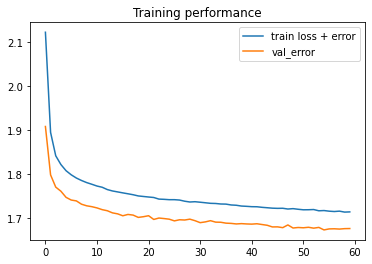

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

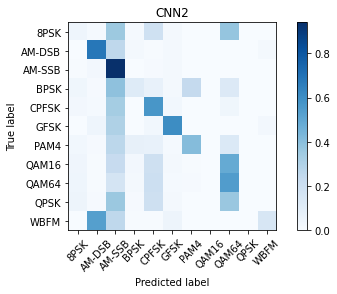

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08358098068350668


Overall Accuracy:  0.09500924214417746


Overall Accuracy:  0.09473312124425592


Overall Accuracy:  0.10330288123682362


Overall Accuracy:  0.12355491329479769


Overall Accuracy:  0.18403150733977802


Overall Accuracy:  0.24829810103905411


Overall Accuracy:  0.33103197674418605
Overall Accuracy:  0.4337948171813987


Overall Accuracy:  0.4953271028037383
Overall Accuracy:  0.49818445896877267


Overall Accuracy:  0.5192931842769564
Overall Accuracy:  0.5161290322580645


Overall Accuracy:  0.5182835820895523
Overall Accuracy:  0.5082853025936599


Overall Accuracy:  0.5224207072548305
Overall Accuracy:  0.5305442428730099


Overall Accuracy:  0.5201203459947349


Overall Accuracy:  0.5383198231392778


Overall Accuracy:  0.5333333333333333


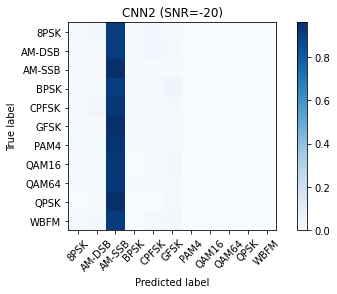

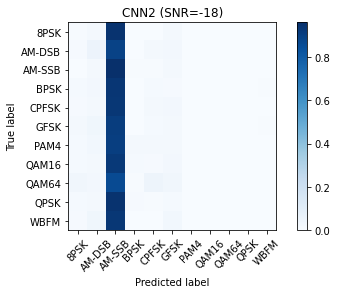

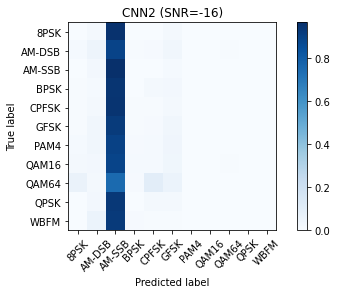

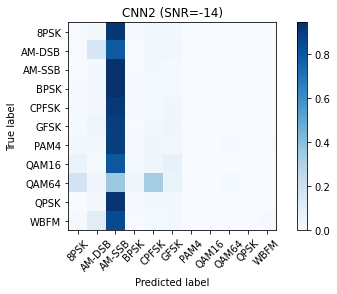

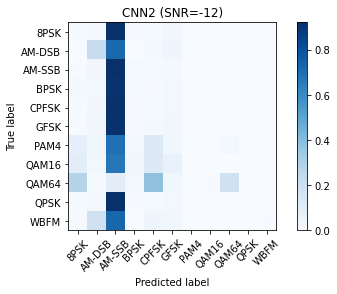

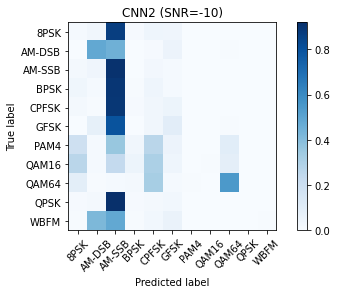

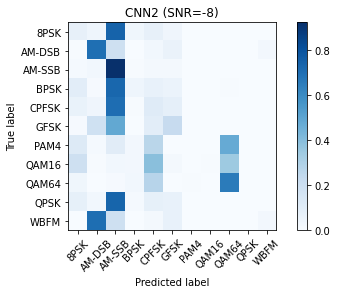

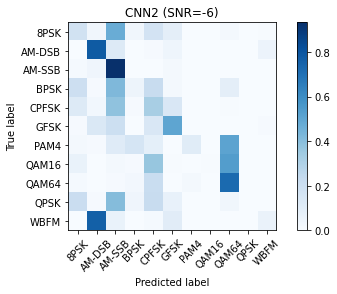

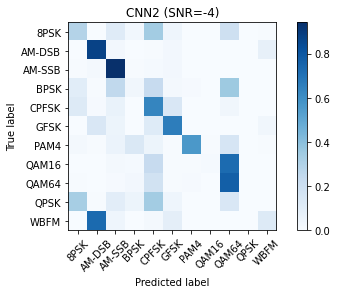

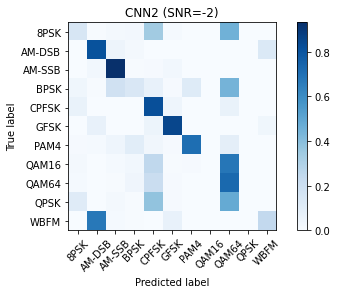

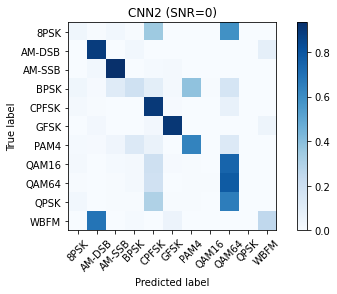

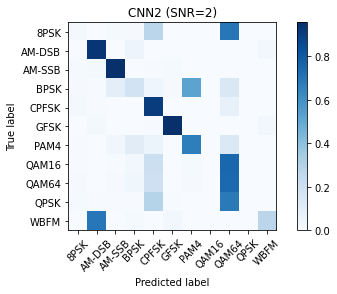

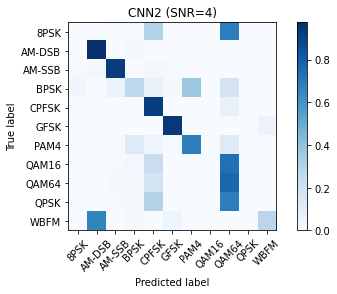

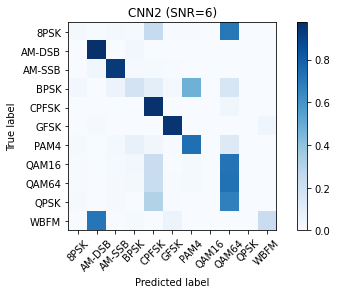

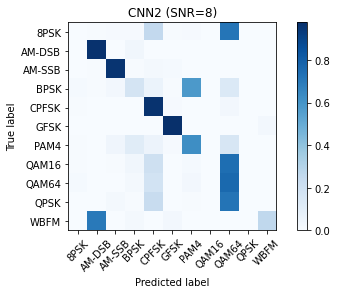

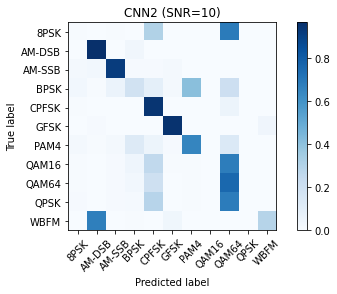

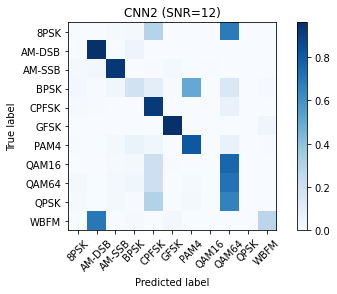

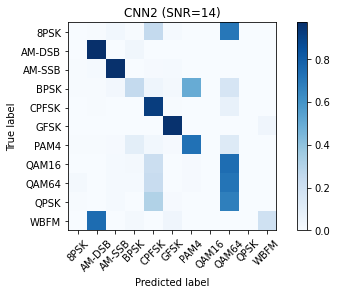

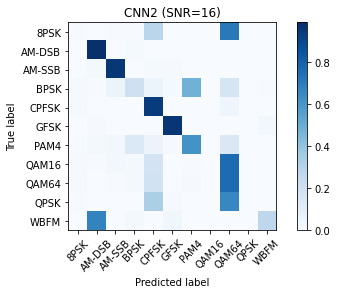

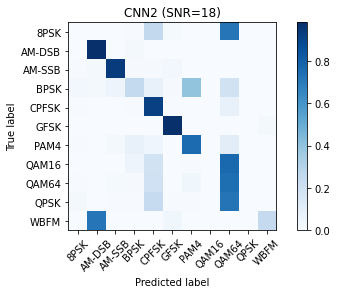

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,12,18,24,33,43,49,49,51,51,51,50,52,53,52,53,53


In [18]:
import statistics

statistics.mean(acc.values())

0.3698789328246954

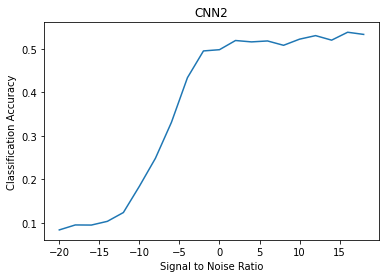

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)